# Optional - Download data for Colab
Remove "### " from all lines and enable this block when running the notebook in Google Colab

In [1]:
import gdown
import os
import shutil
import glob
from google.colab import files

# Step 1: Check if the Project_data folder exists
if os.path.exists("datasets"):
    # If it exists, delete the folder and its contents
    shutil.rmtree("datasets")
    print("datasets Project_data folder has been deleted.")
else:
    print("datasets Project_data folder does not exist.")
# Create the consolidated folder
os.makedirs("datasets", exist_ok=True)
# Step 2: Download the file using gdown
gdown.download("https://drive.google.com/uc?export=download&id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL", "download.zip", quiet=False)
# Step 3: Unzip the file into the specified directory
!unzip -o download.zip -d datasets
# Step 4: Clean up the zip file
!rm download.zip

datasets Project_data folder does not exist.


Downloading...
From (original): https://drive.google.com/uc?export=download&id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL
From (redirected): https://drive.google.com/uc?export=download&id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL&confirm=t&uuid=71606146-11a2-493f-9c77-7c07a3a9d056
To: /content/download.zip
100%|██████████| 1.71G/1.71G [00:36<00:00, 46.6MB/s]


Streaming output truncated to the last 5000 lines.
 extracting: datasets/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00050.png  
 extracting: datasets/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00052.png  
 extracting: datasets/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00054.png  
 extracting: datasets/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00056.png  
 extracting: datasets/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00058.png  
 extracting: datasets/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00060.png  
 extracting: datasets/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00062.png  
   creating: datasets/Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/
 extracting: datasets/Project_data/train/WIN_20180926_17_35_12_Pro_

# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

## Import Necessary Libraries

In [2]:
import numpy as np
import os
from skimage import io, transform
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30) --- replaced  in new version
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: datasets/Project_data**

In [4]:
train_doc = np.random.permutation(open('datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('datasets/Project_data/val.csv').readlines())
# Initialise source_path
source_path='Project_data'

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
total_frames = 30  # Total frames in each video
# Number of classes
num_of_classes=5

In [6]:
# # Function to Resize and Crop Images Based on Specific Dimensions
# Supports frames or images with dimensions 360x360 and 120x160; raises an exception for unsupported dimensions
# Ensuring a Specific Aspect Ratio (130x120) :
def resize_crop_image(image,image_height_out, image_width_out):
    height, width = image.shape[0], image.shape[1]
    # Case 1: If image is 360x360
    if height == 360 and width == 360:
        # Resize to a manageable size first if needed
        image = transform.resize(image, (120, 120))

        # Center crop a region around 120x120
        height_center, width_center = 60, 60
        image = image[(height_center - 60):(height_center + 70),
                      (width_center - 50):(width_center + 70)]

    # Case 2: If video is 120x160
    elif height == 120 and width == 160:
        # Center crop to capture a consistent 100x100 area
        height_center = height // 2  # 60
        width_center = width // 2     # 80
        image = image[(height_center - 50):(height_center + 50),
                      (width_center - 50):(width_center + 50)]

    # Case 3: Unsupported dimensions
    else:
        raise ValueError(f"Unsupported image dimensions: {height}x{width}. "
                         "Expected dimensions are 360x360 or 120x160.")

    # Final resize to target dimensions
    image = transform.resize(image, (image_height_out, image_width_out))
    return image

In [7]:
def plot_original_crop_images(paths,image_height,image_width):
  for index,path in enumerate(paths):
    image=io.imread(path)
    image_cropped=resize_crop_image(image,image_height_out=image_height,image_width_out=image_width)
    #set figure size
    plt.figure(figsize=[12,12])
    # plot original image
    plt.subplot(5,2,index*2+1)
    plt.imshow(image)
    plt.title("Original Image")
    # plot cropped image
    plt.subplot(5,2,index*2+2)
    plt.imshow(image_cropped)
    plt.title("Modified Image")
  plt.show()

In [8]:
def generator(source_path, folder_list, batch_size, img_idx, image_height, image_width):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = img_idx  #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),image_height,image_width,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = io.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = resize_crop_image(image,image_height_out=image_height,image_width_out=image_width)

                    batch_data[folder,idx,:,:,0] = image[:,:,0] #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1] #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2] #normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size * num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,len(img_idx),image_height,image_width,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = io.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = resize_crop_image(image,image_height_out=image_height,image_width_out=image_width)

                    batch_data[folder,idx,:,:,0] = image[:,:,0] #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1] #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2] #normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

### Specifically, videos have two types of dimensions - either 360x360 or 120x160 (depending on the webcam used to record the videos)

Let's visualize resize and crop function

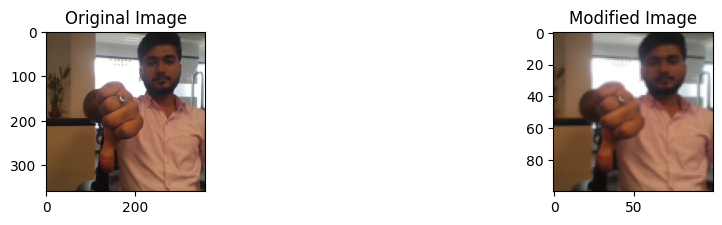

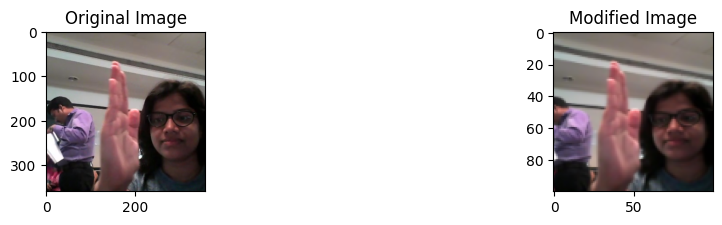

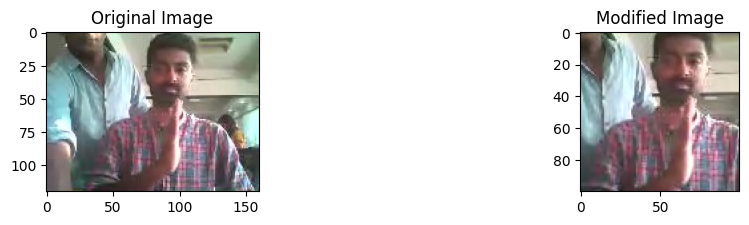

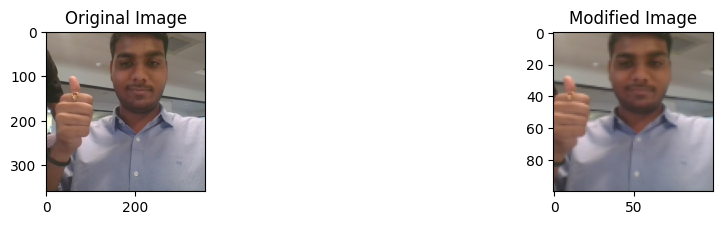

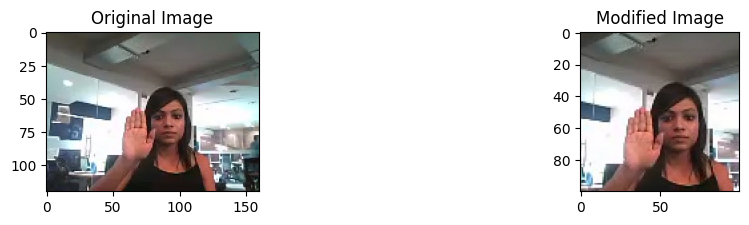

In [9]:
full_image_paths = ["datasets/Project_data/train/WIN_20180907_16_41_13_Pro_Thumbs Down_new/WIN_20180907_16_41_13_Pro_00028.png",
        "datasets/Project_data/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00052.png",
        "datasets/Project_data/train/WIN_20180926_17_43_30_Pro_Left_Swipe_new/WIN_20180926_17_43_30_Pro_00065.png",
        "datasets/Project_data/train/WIN_20180907_15_49_59_Pro_Thumbs Up_new/WIN_20180907_15_49_59_Pro_00031.png",
        "datasets/Project_data/train/WIN_20180925_17_29_33_Pro_Stop_new/WIN_20180925_17_29_33_Pro_00028.png"]
plot_original_crop_images(full_image_paths,image_height=100,image_width=100)

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [10]:
curr_dt_time = datetime.datetime.now()
train_path = 'datasets/Project_data/train'
val_path = 'datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [11]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, LSTM, GRU, Flatten, TimeDistributed, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import optimizers
from tensorflow.keras.applications import VGG16, MobileNetV2

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [12]:
# Dictionary to store histories
experiment_histories = {}

### Class DataPreprocessor:

In [13]:
class DataPreprocessor:
    def __init__(self, image_height=120, image_width=120, num_of_frames=15, batch_size=40, num_epochs=10):
        # Store hyperparameters for data preprocessing
        self.image_height = image_height
        self.image_width = image_width
        self.num_of_frames = num_of_frames
        self.batch_size = batch_size
        self.num_epochs = num_epochs

    def set_paths(self, train_path='datasets/Project_data/train', val_path='datasets/Project_data/val'):
        # Paths for training and validation data
        self.train_path = train_path
        self.val_path = val_path

    def calculate_input_shape(self):
        # Calculate and return input shape for models based on number of frames and image dimensions
        self.input_shape = (self.num_of_frames, self.image_height, self.image_width, 3)
        return self.input_shape

    def calculate_img_idx(self, total_frames):
        # Calculate evenly spaced frame indices based on the total number of frames in each video
        self.img_idx = np.linspace(0, total_frames - 1, self.num_of_frames).astype(int)
        return self.img_idx

    def get_data_generators(self, generator, train_doc, val_doc):
        # Initialize train and validation data generators
        self.train_generator = generator(self.train_path, train_doc, self.batch_size, self.img_idx, self.image_height, self.image_width)
        self.val_generator = generator(self.val_path, val_doc, self.batch_size, self.img_idx, self.image_height, self.image_width)
        return self.train_generator, self.val_generator

    def display_summary(self):
        # Display configuration summary
        print("=== Data Preprocessing Summary ===")
        print(f"Image Height: {self.image_height}")
        print(f"Image Width: {self.image_width}")
        print(f"Frames per Video: {self.num_of_frames}")
        print(f"Batch Size: {self.batch_size}")
        print(f"Number of Epochs: {self.num_epochs}")
        print(f"Training Path: {self.train_path}")
        print(f"Validation Path: {self.val_path}")
        print(f"Input Shape: {self.input_shape}")
        print(f"Frame Indices: {self.img_idx}")
        print("=================================")

    def initializePreprocessData(self, total_frames, generator, train_doc, val_doc):
        # Call all methods to calculate necessary configurations and print a summary
        self.calculate_input_shape()
        self.calculate_img_idx(total_frames)
        self.get_data_generators(generator, train_doc, val_doc)
        num_train_sequences = len(train_doc)
        num_val_sequences = len(val_doc)
        self.display_summary()

### Create a Conv3D Base Model Class
This class includes essential configurations, allowing you to customize layer sizes, kernel sizes, dropout rates, and the optimizer.

In [14]:
class Conv3DBaseModel:
    def __init__(self, input_shape, num_classes, optimizer_type='SGD', optimizer_params=None,  model_name="model_init"):
        # Initialize model parameters
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model_name = model_name
        self.optimizer_type = optimizer_type
        self.optimizer_params = optimizer_params or {}

    def build_model(self, conv_layers=[8, 16, 32],  maxpool_layers=[1,1,1], kernel_size=(3,3,3), dense_units=[128], dropout_rate=None):
        if len(conv_layers) != len(maxpool_layers):
            raise ValueError("Configuration Error: 'conv_layers' and 'maxpool_layers' must have the same length.")
        # Initialize model
        model = Sequential()

        # Add Conv3D layers
        for i, filters in enumerate(conv_layers):
            conv_name = f"Conv3D_{i+1}_{filters}F"
            if i == 0:
                model.add(Conv3D(filters, kernel_size=kernel_size, input_shape=self.input_shape, padding="same",name=conv_name))
            else:
                model.add(Conv3D(filters, kernel_size=kernel_size, padding="same",name=conv_name))
            model.add(BatchNormalization(name=f"BatchNorm_{conv_name}"))
            model.add(Activation("relu",name=f"ReLU_{conv_name}"))
            if maxpool_layers[i]==1:
                maxpool_name=f"MaxPool_{conv_name}"
                model.add(MaxPooling3D(pool_size=(2,2,2),name=maxpool_name))

        # Flatten and add Dense layers
        model.add(Flatten())
        for j,units in enumerate(dense_units):
            dense_name = f"Dense_{j+1}_{units}N"
            model.add(Dense(units,name=dense_name))
            model.add(BatchNormalization(name=f"BatchNorm_{dense_name}"))
            model.add(Activation("relu",name=f"ReLU_{dense_name}"))
            if dropout_rate:
                dropout_name = f"Dropout_{j+1}_{int(dropout_rate[j]*100)}_percent"
                model.add(Dropout(dropout_rate[j],name=dropout_name))

        # Add Output layer
        model.add(Dense(self.num_classes, activation="softmax", name="Output_Layer"))
        self.model = model
        return model

    def compile_model(self):
        # Select optimizer based on optimizer_type
        if self.optimizer_type == 'SGD':
            default_params = {'learning_rate': 0.001, 'weight_decay': 1e-6, 'momentum': 0.7, 'nesterov': True}
            sgd_params = {**default_params, **self.optimizer_params}
            optimiser = optimizers.SGD(**sgd_params)

        elif self.optimizer_type == 'Adam':
            default_params = {'learning_rate': 0.001, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-7}
            adam_params = {**default_params, **self.optimizer_params}
            optimiser = optimizers.Adam(**adam_params)

        elif self.optimizer_type == 'RMSprop':
            default_params = {'learning_rate': 0.001, 'rho': 0.9, 'momentum': 0.0, 'epsilon': 1e-7}
            rmsprop_params = {**default_params, **self.optimizer_params}
            optimiser = optimizers.RMSprop(**rmsprop_params)

        else:
            raise ValueError(f"Unsupported optimizer type: {self.optimizer_type}")

        # Compile the model
        self.model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return self.model

    def setup_directory(self):
        curr_dt_time = datetime.datetime.now()
        self.model_name = self.model_name + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
        #Ensure the model directory exists
        if not os.path.exists(self.model_name):
            os.mkdir(self.model_name)
        print(f"Directory {self.model_name} is ready.")

    def setup_callbacks(self, patience=10):
        # Ensure model directory is set up
        self.setup_directory()
        # Define callbacks for checkpoints, learning rate reduction, and early stopping
        filepath = f"{self.model_name}/model-{{epoch:02d}}-{{val_loss:.2f}}.keras"
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
        earlystop = EarlyStopping(monitor="val_loss", min_delta=0,patience=10,verbose=1)

        self.callbacks_list = [checkpoint, LR, earlystop]
        return self.callbacks_list

    def display_summary(self,config):
        # Initialize and build the model
        model = self.build_model(
            conv_layers=config["conv_layers"],
            maxpool_layers=config["maxpool_layers"],
            kernel_size=config["kernel_size"],
            dense_units=config["dense_units"],
            dropout_rate=config["dropout_rate"]
        )
        # Print model summary
        print(self.model.summary())
        return self.model

    def run_experiment(self, config, train_generator, val_generator, num_train_sequences, num_val_sequences, batch_size, num_epochs):
        """Run a single experiment based on the provided configuration."""
        print("\n--- Running Experiment ---")

        # Calculate steps per epoch and validation steps based on batch size
        if (num_train_sequences % batch_size) == 0:
            steps_per_epoch = int(num_train_sequences / batch_size)
        else:
            steps_per_epoch = (num_train_sequences // batch_size) + 1

        if (num_val_sequences % batch_size) == 0:
            validation_steps = int(num_val_sequences / batch_size)
        else:
            validation_steps = (num_val_sequences // batch_size) + 1

        # Initialize and build the model
        model = self.build_model(
            conv_layers=config["conv_layers"],
            maxpool_layers=config["maxpool_layers"],
            kernel_size=config["kernel_size"],
            dense_units=config["dense_units"],
            dropout_rate=config["dropout_rate"]
        )
        model = self.compile_model()
        self.setup_callbacks()

        # Print model summary
        print(model.summary())

        # Train model
        self.history=model.fit(
            train_generator,
            steps_per_epoch=steps_per_epoch,
            epochs=num_epochs,
            verbose=1,
            callbacks=self.callbacks_list,
            validation_data=val_generator,
            validation_steps=validation_steps,
            class_weight=None,
            initial_epoch=0
        )
        print("--- Experiment Completed ---\n")
        # Return the history for external use
        return self.history, self.model_name

    def plot_history(self):
        # Extract accuracy and validation accuracy from training history
        acc = self.history.history['categorical_accuracy']
        val_acc = self.history.history['val_categorical_accuracy']

        # Extract loss and validation loss from training history
        loss = self.history.history['loss']
        val_loss = self.history.history['val_loss']

        # Create a range of epochs for the x-axis
        epochs_range = range(len(acc))

        # Set up the plot figure with a specific size
        plt.figure(figsize=(8, 8))

        # Plot Training and Validation Accuracy
        plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
        plt.plot(epochs_range, acc, label='Training Accuracy')  # Plot training accuracy
        plt.plot(epochs_range, val_acc, label='Validation Accuracy')  # Plot validation accuracy
        plt.legend(loc='lower right')  # Position the legend
        plt.title('Training and Validation Accuracy')  # Set title for accuracy plot

        # Plot Training and Validation Loss
        plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
        plt.plot(epochs_range, loss, label='Training Loss')  # Plot training loss
        plt.plot(epochs_range, val_loss, label='Validation Loss')  # Plot validation loss
        plt.legend(loc='upper right')  # Position the legend
        plt.title('Training and Validation Loss')  # Set title for loss plot

        # Display the plots
        plt.show()

    def evaluate_model(self):
        # Extract accuracy and validation accuracy from training history
        max_train_acc = max(self.history.history['categorical_accuracy'])
        max_val_acc = max(self.history.history['val_categorical_accuracy'])
        # Extract loss and validation loss from training history
        min_train_loss = min(self.history.history['loss'])
        min_val_loss = min(self.history.history['val_loss'])
        return max_train_acc, max_val_acc, min_train_loss, min_val_loss


### Create CNN and LSTM Model Class

In [15]:
class RNNCNNModel:
    def __init__(self, input_shape, num_classes, rnn_type='LSTM', optimizer_type='SGD', optimizer_params=None, model_name="RNNCNNModel"):
        # Initialize model parameters
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.rnn_type = rnn_type
        self.model_name = model_name
        self.optimizer_type = optimizer_type
        self.optimizer_params = optimizer_params or {}

    def build_model(self, conv_layers=[16, 32, 64], maxpool_layers=[1, 1, 1],
                    kernel_size=(3, 3), rnn_units=64, dense_units=[128], dropout_rate=0.25):
        if len(conv_layers) != len(maxpool_layers):
            raise ValueError("Configuration Error: 'conv_layers' and 'maxpool_layers' must have the same length.")

        # Initialize model
        model = Sequential()

        # Add TimeDistributed Conv2D layers
        for i, filters in enumerate(conv_layers):
            conv_name = f"Conv2D_{i+1}_{filters}F"
            if i == 0:
                model.add(TimeDistributed(Conv2D(filters, kernel_size=kernel_size, padding="same"),
                                          input_shape=self.input_shape, name=conv_name))
            else:
                model.add(TimeDistributed(Conv2D(filters, kernel_size=kernel_size, padding="same"),
                                          name=conv_name))
            model.add(TimeDistributed(BatchNormalization(), name=f"BatchNorm_{conv_name}"))
            model.add(TimeDistributed(Activation("relu"), name=f"ReLU_{conv_name}"))
            if maxpool_layers[i] == 1:
                model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2)), name=f"MaxPool_{conv_name}"))

        # Flatten and add RNN layer
        model.add(TimeDistributed(Flatten(), name="Flatten_Layer"))
        if self.rnn_type == 'LSTM':
            model.add(LSTM(rnn_units, return_sequences=False, name=f"LSTM_{rnn_units}_Units"))
        elif self.rnn_type == 'GRU':
            model.add(GRU(rnn_units, return_sequences=False, name=f"GRU_{rnn_units}_Units"))
        else:
            raise ValueError("Unsupported RNN type: choose 'LSTM' or 'GRU'.")

        # Add Dense layers
        for j, units in enumerate(dense_units):
            model.add(Dense(units, activation='relu', name=f"Dense_{j+1}_{units}N"))
            if dropout_rate:
                dropout_name = f"Dropout_{j+1}_{int(dropout_rate[j]*100)}_percent"
                model.add(Dropout(dropout_rate[j],name=dropout_name))

        # Add Output layer
        model.add(Dense(self.num_classes, activation="softmax", name="Output_Layer"))
        self.model = model
        return model

    def compile_model(self):
        # Select optimizer based on optimizer_type
        if self.optimizer_type == 'SGD':
            default_params = {'learning_rate': 0.001, 'weight_decay': 1e-6, 'momentum': 0.7, 'nesterov': True}
            sgd_params = {**default_params, **self.optimizer_params}
            optimiser = optimizers.SGD(**sgd_params)

        elif self.optimizer_type == 'Adam':
            default_params = {'learning_rate': 0.001, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-7}
            adam_params = {**default_params, **self.optimizer_params}
            optimiser = optimizers.Adam(**adam_params)

        elif self.optimizer_type == 'RMSprop':
            default_params = {'learning_rate': 0.001, 'rho': 0.9, 'momentum': 0.0, 'epsilon': 1e-7}
            rmsprop_params = {**default_params, **self.optimizer_params}
            optimiser = optimizers.RMSprop(**rmsprop_params)

        else:
            raise ValueError(f"Unsupported optimizer type: {self.optimizer_type}")

        # Compile the model
        self.model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return self.model

    def setup_directory(self):
        curr_dt_time = datetime.datetime.now()
        self.model_name = self.model_name + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
        #Ensure the model directory exists
        if not os.path.exists(self.model_name):
            os.mkdir(self.model_name)
        print(f"Directory {self.model_name} is ready.")

    def setup_callbacks(self, patience=10):
        # Ensure model directory is set up
        self.setup_directory()
        # Define callbacks for checkpoints, learning rate reduction, and early stopping
        filepath = f"{self.model_name}/model-{{epoch:02d}}-{{val_loss:.2f}}.keras"
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
        earlystop = EarlyStopping(monitor="val_loss", min_delta=0,patience=10,verbose=1)

        self.callbacks_list = [checkpoint, LR, earlystop]
        return self.callbacks_list

    def display_summary(self,config):
        # Initialize and build the model
        model = self.build_model(
            conv_layers=config["conv_layers"],
            maxpool_layers=config["maxpool_layers"],
            kernel_size=config["kernel_size"],
            rnn_units=config["rnn_units"],
            dense_units=config["dense_units"],
            dropout_rate=config["dropout_rate"]
        )
        # Print model summary
        print(self.model.summary())
        return self.model

    def run_experiment(self, config, train_generator, val_generator, num_train_sequences, num_val_sequences, batch_size, num_epochs):
        """Run a single experiment based on the provided configuration."""
        print("\n--- Running Experiment ---")

        # Calculate steps per epoch and validation steps based on batch size
        if (num_train_sequences % batch_size) == 0:
            steps_per_epoch = int(num_train_sequences / batch_size)
        else:
            steps_per_epoch = (num_train_sequences // batch_size) + 1

        if (num_val_sequences % batch_size) == 0:
            validation_steps = int(num_val_sequences / batch_size)
        else:
            validation_steps = (num_val_sequences // batch_size) + 1

        # Initialize and build the model
        model = self.build_model(
            conv_layers=config["conv_layers"],
            maxpool_layers=config["maxpool_layers"],
            kernel_size=config["kernel_size"],
            rnn_units=config["rnn_units"],
            dense_units=config["dense_units"],
            dropout_rate=config["dropout_rate"]
        )
        model = self.compile_model()
        self.setup_callbacks()

        # Print model summary
        print(model.summary())

        # Train model
        self.history=model.fit(
            train_generator,
            steps_per_epoch=steps_per_epoch,
            epochs=num_epochs,
            verbose=1,
            callbacks=self.callbacks_list,
            validation_data=val_generator,
            validation_steps=validation_steps,
            class_weight=None,
            initial_epoch=0
        )
        print("--- Experiment Completed ---\n")
        # Return the history for external use
        return self.history, self.model_name

    def plot_history(self):
        # Extract accuracy and validation accuracy from training history
        acc = self.history.history['categorical_accuracy']
        val_acc = self.history.history['val_categorical_accuracy']

        # Extract loss and validation loss from training history
        loss = self.history.history['loss']
        val_loss = self.history.history['val_loss']

        # Create a range of epochs for the x-axis
        epochs_range = range(len(acc))

        # Set up the plot figure with a specific size
        plt.figure(figsize=(8, 8))

        # Plot Training and Validation Accuracy
        plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
        plt.plot(epochs_range, acc, label='Training Accuracy')  # Plot training accuracy
        plt.plot(epochs_range, val_acc, label='Validation Accuracy')  # Plot validation accuracy
        plt.legend(loc='lower right')  # Position the legend
        plt.title('Training and Validation Accuracy')  # Set title for accuracy plot

        # Plot Training and Validation Loss
        plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
        plt.plot(epochs_range, loss, label='Training Loss')  # Plot training loss
        plt.plot(epochs_range, val_loss, label='Validation Loss')  # Plot validation loss
        plt.legend(loc='upper right')  # Position the legend
        plt.title('Training and Validation Loss')  # Set title for loss plot

        # Display the plots
        plt.show()

    def evaluate_model(self):
        # Extract accuracy and validation accuracy from training history
        max_train_acc = max(self.history.history['categorical_accuracy'])
        max_val_acc = max(self.history.history['val_categorical_accuracy'])
        # Extract loss and validation loss from training history
        min_train_loss = min(self.history.history['loss'])
        min_val_loss = min(self.history.history['val_loss'])
        return max_train_acc, max_val_acc, min_train_loss, min_val_loss


### Create VGG16 , MobileNetV2 or ResNet18 Imagenet and LSTM Model Class

In [16]:
class RNNCNN_ImageNet:
    def __init__(self, input_shape, num_classes, rnn_type='LSTM', imagenet_type='VGG16', imagenet_trainable_layers=0, optimizer_type='SGD', optimizer_params=None, model_name="RNNCNN_VGGNet"):
        # Initialize model parameters
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.rnn_type = rnn_type
        self.model_name = model_name
        self.optimizer_type = optimizer_type
        self.imagenet_type=imagenet_type
        self.imagenet_trainable_layers=imagenet_trainable_layers
        self.optimizer_params = optimizer_params or {}

    def build_model(self, rnn_units=[64], rnn_dropout_rate=[0.25], dense_units=[128], dropout_rate=[0.25]):
        # Initialize Sequential model
        model = Sequential()

        # Add Input layer to specify input shape explicitly at the start
        model.add(Input(shape=self.input_shape , name="Input_Layer"))  # Add Input layer with your specified shape

        # Load imagenet without top layers, include weights but freeze them
        imagenet_layer_name = f"{self.imagenet_type}_Feature_Extractor"
        if self.imagenet_type=="VGG16":
          imagenet_model = VGG16(weights='imagenet', include_top=False, input_shape=self.input_shape[1:])
        elif self.imagenet_type=="ResNet18":
          imagenet_model = ResNet18(weights='imagenet', include_top=False, input_shape=self.input_shape[1:])
        elif self.imagenet_type=="MobileNetV2":
          imagenet_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=self.input_shape[1:])
        else:
                raise ValueError("Unsupported imagenet type: choose 'VGG16' or 'ResNet18' or 'MobileNetV2' .")
        # Ignore trainable weights
        if self.imagenet_trainable_layers==0:
          for layer in imagenet_model.layers:
            layer.trainable = False
        elif self.imagenet_trainable_layers:
          for layer in imagenet_model.layers[:self.imagenet_trainable_layers]:   # adjust layer count based on your model's layers
            layer.trainable = False
          for layer in imagenet_model.layers[self.imagenet_trainable_layers:]:
            layer.trainable = True
        else:
                raise ValueError("Unsupported imagenet trainable layers : choose 'NA' or 'after_100' .")

        # Wrap imagenet in TimeDistributed layer to apply it to each time step in sequence
        model.add(TimeDistributed(imagenet_model, name=imagenet_layer_name))

        # Add Batch Normalization layer
        #model.add(TimeDistributed(BatchNormalization(), name=f"BatchNorm_{imagenet_layer_name}"))
        # Add Max Pooling to reduce dimensions
        #model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2)), name=f"MaxPool_{imagenet_layer_name}"))

        # Add Global Average Pooling to reduce dimensions
        model.add(TimeDistributed(GlobalAveragePooling2D(), name="Global_Average_Pooling_Layer"))

        # Flatten and add RNN layer
        #model.add(TimeDistributed(Flatten(), name="Flatten_Layer"))

        # LSTM or GRU cells
        for i, units in enumerate(rnn_units):
            return_sequences = True if i < len(rnn_units) - 1 else False  # Only final RNN layer should have return_sequences=False
            if self.rnn_type == 'LSTM':
                model.add(LSTM(units, return_sequences=return_sequences, name=f"LSTM_{i+1}_{units}_Units"))
            elif self.rnn_type == 'GRU':
                model.add(GRU(units, return_sequences=return_sequences, name=f"GRU_{i+1}_{units}_Units"))
            else:
                raise ValueError("Unsupported RNN type: choose 'LSTM' or 'GRU'.")

            # Add dropouts
            if rnn_dropout_rate[i] != 0:
                rnn_dropout_name = f"Dropout_{i+1}_{int(rnn_dropout_rate[i]*100)}_percent"
                model.add(Dropout(rnn_dropout_rate[i],name=rnn_dropout_name))

        # Add Dense layers
        for j, units in enumerate(dense_units):
            model.add(Dense(units, activation='relu', name=f"Dense_{j+1}_{units}N"))
            if dropout_rate:
                dropout_name = f"Dropout_{j+1}_{int(dropout_rate[j]*100)}_percent"
                model.add(Dropout(dropout_rate[j],name=dropout_name))

        # Add Output layer
        model.add(Dense(self.num_classes, activation="softmax", name="Output_Layer"))
        self.model = model
        return model

    def compile_model(self):
        # Select optimizer based on optimizer_type
        if self.optimizer_type == 'SGD':
            default_params = {'learning_rate': 0.001, 'weight_decay': 1e-6, 'momentum': 0.7, 'nesterov': True}
            sgd_params = {**default_params, **self.optimizer_params}
            optimiser = optimizers.SGD(**sgd_params)

        elif self.optimizer_type == 'Adam':
            default_params = {'learning_rate': 0.001, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-7}
            adam_params = {**default_params, **self.optimizer_params}
            optimiser = optimizers.Adam(**adam_params)

        elif self.optimizer_type == 'RMSprop':
            default_params = {'learning_rate': 0.001, 'rho': 0.9, 'momentum': 0.0, 'epsilon': 1e-7}
            rmsprop_params = {**default_params, **self.optimizer_params}
            optimiser = optimizers.RMSprop(**rmsprop_params)

        else:
            raise ValueError(f"Unsupported optimizer type: {self.optimizer_type}")

        # Compile the model
        self.model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return self.model

    def setup_directory(self):
        curr_dt_time = datetime.datetime.now()
        self.model_name = self.model_name + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
        #Ensure the model directory exists
        if not os.path.exists(self.model_name):
            os.mkdir(self.model_name)
        print(f"Directory {self.model_name} is ready.")

    def setup_callbacks(self, patience=10):
        # Ensure model directory is set up
        self.setup_directory()
        # Define callbacks for checkpoints, learning rate reduction, and early stopping
        filepath = f"{self.model_name}/model-{{epoch:02d}}-{{val_loss:.2f}}.keras"
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
        earlystop = EarlyStopping(monitor="val_loss", min_delta=0,patience=10,verbose=1)

        self.callbacks_list = [checkpoint, LR, earlystop]
        return self.callbacks_list

    def display_summary(self,config):
        # Initialize and build the model
        model = self.build_model(
            rnn_units=config["rnn_units"],
            rnn_dropout_rate=config["rnn_dropout_rate"],
            dense_units=config["dense_units"],
            dropout_rate=config["dropout_rate"]
        )
        # Print model summary
        print(self.model.summary())
        return self.model

    def run_experiment(self, config, train_generator, val_generator, num_train_sequences, num_val_sequences, batch_size, num_epochs):
        """Run a single experiment based on the provided configuration."""
        print("\n--- Running Experiment ---")

        # Calculate steps per epoch and validation steps based on batch size
        if (num_train_sequences % batch_size) == 0:
            steps_per_epoch = int(num_train_sequences / batch_size)
        else:
            steps_per_epoch = (num_train_sequences // batch_size) + 1

        if (num_val_sequences % batch_size) == 0:
            validation_steps = int(num_val_sequences / batch_size)
        else:
            validation_steps = (num_val_sequences // batch_size) + 1

        # Initialize and build the model
        model = self.build_model(
            rnn_units=config["rnn_units"],
            rnn_dropout_rate=config["rnn_dropout_rate"],
            dense_units=config["dense_units"],
            dropout_rate=config["dropout_rate"]
        )
        model = self.compile_model()
        self.setup_callbacks()

        # Print model summary
        print(model.summary())

        # Train model
        self.history=model.fit(
            train_generator,
            steps_per_epoch=steps_per_epoch,
            epochs=num_epochs,
            verbose=1,
            callbacks=self.callbacks_list,
            validation_data=val_generator,
            validation_steps=validation_steps,
            class_weight=None,
            initial_epoch=0
        )
        print("--- Experiment Completed ---\n")
        # Return the history for external use
        return self.history, self.model_name

    def plot_history(self):
        # Extract accuracy and validation accuracy from training history
        acc = self.history.history['categorical_accuracy']
        val_acc = self.history.history['val_categorical_accuracy']

        # Extract loss and validation loss from training history
        loss = self.history.history['loss']
        val_loss = self.history.history['val_loss']

        # Create a range of epochs for the x-axis
        epochs_range = range(len(acc))

        # Set up the plot figure with a specific size
        plt.figure(figsize=(8, 8))

        # Plot Training and Validation Accuracy
        plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
        plt.plot(epochs_range, acc, label='Training Accuracy')  # Plot training accuracy
        plt.plot(epochs_range, val_acc, label='Validation Accuracy')  # Plot validation accuracy
        plt.legend(loc='lower right')  # Position the legend
        plt.title('Training and Validation Accuracy')  # Set title for accuracy plot

        # Plot Training and Validation Loss
        plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
        plt.plot(epochs_range, loss, label='Training Loss')  # Plot training loss
        plt.plot(epochs_range, val_loss, label='Validation Loss')  # Plot validation loss
        plt.legend(loc='upper right')  # Position the legend
        plt.title('Training and Validation Loss')  # Set title for loss plot

        # Display the plots
        plt.show()

    def evaluate_model(self):
        # Extract accuracy and validation accuracy from training history
        max_train_acc = max(self.history.history['categorical_accuracy'])
        max_val_acc = max(self.history.history['val_categorical_accuracy'])
        # Extract loss and validation loss from training history
        min_train_loss = min(self.history.history['loss'])
        min_val_loss = min(self.history.history['val_loss'])
        return max_train_acc, max_val_acc, min_train_loss, min_val_loss


## Identifying Optimal Model Parameters:
1. Batch Size,
2. Frame Count, and
3. Image Shape
for Efficient Model Training

Steps :
- Conducted few experiments with varying batch sizes, frame counts, and image shapes.
- Trained each configuration for 2 epochs to observe GPU, RAM, and training time.
- Findings will inform optimal parameters for final model building

### Experiment 1 -
- image_height=120,
- image_width=120,
- num_of_frames=30,
- batch_size=40,
- num_epochs=2

In [ ]:
# Initialize the DataPreprocessor
preprocessor = DataPreprocessor(image_height=120, image_width=120, num_of_frames=30, batch_size=40, num_epochs=2)
# Set paths
preprocessor.set_paths(train_path=train_path, val_path=val_path)
# Call display_summary, which will compute and print all values
preprocessor.initializePreprocessData(total_frames=total_frames, generator=generator, train_doc=train_doc, val_doc=val_doc)

=== Data Preprocessing Summary ===
Image Height: 120
Image Width: 120
Frames per Video: 30
Batch Size: 40
Number of Epochs: 2
Training Path: Project_data/train
Validation Path: Project_data/val
Input Shape: (30, 120, 120, 3)
Frame Indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]


In [ ]:
# Experiment configuration
experiment_config = {
    "conv_layers": [16, 32, 64],
    "maxpool_layers":[1, 1, 1],
    "kernel_size": (3, 3, 3),
    "dense_units": [128,64],
    "dropout_rate": [0.5,0.25]
}

# Optimizer configuration
optimizer_type = 'SGD'
optimizer_params =None

# Retrieve data generators and shapes
train_generator, val_generator = preprocessor.get_data_generators(generator, train_doc, val_doc)

# Model initialization
model = Conv3DBaseModel(preprocessor.input_shape, num_of_classes,  optimizer_type=optimizer_type, optimizer_params=optimizer_params, model_name="model_experiment")

# Running the experiment
model.run_experiment(
    config=experiment_config,
    train_generator=preprocessor.train_generator,
    val_generator=preprocessor.val_generator,
    num_train_sequences=num_train_sequences,
    num_val_sequences=num_val_sequences,
    batch_size=preprocessor.batch_size,
    num_epochs=preprocessor.num_epochs
)


--- Running Experiment ---


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Directory model_experiment_2024-11-0209_36_10.160605/ is ready.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv3D_1_16F (Conv3D)                │ (None, 30, 120, 120, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_1_16F               │ (None, 30, 120, 120, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_1_16F (Activation)       │ (None, 30, 120, 120, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_1_16F (MaxPooling3D)  │ (None, 15, 60, 60, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_2_32F (Conv3D)                │ (None, 15, 60, 60, 32)      │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_2_32F               │ (None, 15, 60, 60, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_2_32F (Activation)       │ (None, 15, 60, 60, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_2_32F (MaxPooling3D)  │ (None, 7, 30, 30, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_3_64F (Conv3D)                │ (None, 7, 30, 30, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_3_64F               │ (None, 7, 30, 30, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_3_64F (Activation)       │ (None, 7, 30, 30, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_3_64F (MaxPooling3D)  │ (None, 3, 15, 15, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 43200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_1_128N (Dense)                 │ (None, 128)                 │       5,529,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Dense_1_128N               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Dense_1_128N (Activation)       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1_50_percent (Dropout)       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_2_64N (Dense)                  │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Dense_2_64N                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │              

 Total params: 5,610,053 (21.40 MB)

 Trainable params: 5,609,445 (21.40 MB)

 Non-trainable params: 608 (2.38 KB)

None
Source path =  Project_data/train ; batch size = 40
Epoch 1/2
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - categorical_accuracy: 0.2881 - loss: 1.7695Source path =  Project_data/val ; batch size = 40

Epoch 1: saving model to model_experiment_2024-11-0209_36_10.160605//model-01-4.22.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 193s 11s/step - categorical_accuracy: 0.2899 - loss: 1.7637 - val_categorical_accuracy: 0.1800 - val_loss: 4.2203 - learning_rate: 0.0010
Epoch 2/2
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.4599 - loss: 1.2701
Epoch 2: saving model to model_experiment_2024-11-0209_36_10.160605//model-02-4.18.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 87s 5s/step - categorical_accuracy: 0.4604 - loss: 1.2698 - val_categorical_accuracy: 0.2833 - val_loss: 4.1793 - learning_rate: 0.0010
--- Experiment Completed ---



(<keras.src.callbacks.history.History at 0x7b9e5cc8a650>,
 'model_experiment_2024-11-0209_36_10.160605/')

In [ ]:
from sys import getsizeof

# Calculate memory utilization for the given array size in gigabytes
memory_util_gigs = getsizeof(np.zeros((50, 16, 30, 120, 120))) / (1024 ** 3)
print(f"Memory utilization is approximately {memory_util_gigs:.2f} GB")

Memory utilization is approximately 2.57 GB


### Experiment 2 -
- image_height=120,
- image_width=120,
- num_of_frames=15,
- batch_size=60,
- num_epochs=2

In [ ]:
# Initialize the DataPreprocessor
preprocessor = DataPreprocessor(image_height=120, image_width=120, num_of_frames=15, batch_size=60, num_epochs=2)
# Set paths
preprocessor.set_paths(train_path=train_path, val_path=val_path)
# Call display_summary, which will compute and print all values
preprocessor.initializePreprocessData(total_frames=total_frames, generator=generator, train_doc=train_doc, val_doc=val_doc)

=== Data Preprocessing Summary ===
Image Height: 120
Image Width: 120
Frames per Video: 15
Batch Size: 60
Number of Epochs: 2
Training Path: Project_data/train
Validation Path: Project_data/val
Input Shape: (15, 120, 120, 3)
Frame Indices: [ 0  2  4  6  8 10 12 14 16 18 20 22 24 26 29]


In [ ]:
# Experiment configuration
experiment_config = {
    "conv_layers": [16, 32, 64],
    "maxpool_layers":[1, 1, 1],
    "kernel_size": (3, 3, 3),
    "dense_units": [128,64],
    "dropout_rate": [0.5,0.25]
}

# Optimizer configuration
optimizer_type = 'SGD'
optimizer_params =None

# Retrieve data generators and shapes
train_generator, val_generator = preprocessor.get_data_generators(generator, train_doc, val_doc)

# Model initialization
model = Conv3DBaseModel(preprocessor.input_shape, num_of_classes,  optimizer_type=optimizer_type, optimizer_params=optimizer_params, model_name="model_experiment")

# Running the experiment
model.run_experiment(
    config=experiment_config,
    train_generator=preprocessor.train_generator,
    val_generator=preprocessor.val_generator,
    num_train_sequences=num_train_sequences,
    num_val_sequences=num_val_sequences,
    batch_size=preprocessor.batch_size,
    num_epochs=preprocessor.num_epochs
)


--- Running Experiment ---
Directory model_experiment_2024-11-0209_41_17.532128/ is ready.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv3D_1_16F (Conv3D)                │ (None, 15, 120, 120, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_1_16F               │ (None, 15, 120, 120, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_1_16F (Activation)       │ (None, 15, 120, 120, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_1_16F (MaxPooling3D)  │ (None, 7, 60, 60, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_2_32F (Conv3D)                │ (None, 7, 60, 60, 32)       │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_2_32F               │ (None, 7, 60, 60, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_2_32F (Activation)       │ (None, 7, 60, 60, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_2_32F (MaxPooling3D)  │ (None, 3, 30, 30, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_3_64F (Conv3D)                │ (None, 3, 30, 30, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_3_64F               │ (None, 3, 30, 30, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_3_64F (Activation)       │ (None, 3, 30, 30, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_3_64F (MaxPooling3D)  │ (None, 1, 15, 15, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_1_128N (Dense)                 │ (None, 128)                 │       1,843,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Dense_1_128N               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Dense_1_128N (Activation)       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1_50_percent (Dropout)       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_2_64N (Dense)                  │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Dense_2_64N                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │              

 Total params: 1,923,653 (7.34 MB)

 Trainable params: 1,923,045 (7.34 MB)

 Non-trainable params: 608 (2.38 KB)

None
Source path =  Project_data/train ; batch size = 60
Epoch 1/2
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.2302 - loss: 1.8933Source path =  Project_data/val ; batch size = 60

Epoch 1: saving model to model_experiment_2024-11-0209_41_17.532128//model-01-2.81.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 97s 8s/step - categorical_accuracy: 0.2306 - loss: 1.8889 - val_categorical_accuracy: 0.2500 - val_loss: 2.8068 - learning_rate: 0.0010
Epoch 2/2
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - categorical_accuracy: 0.4122 - loss: 1.6670
Epoch 2: saving model to model_experiment_2024-11-0209_41_17.532128//model-02-6.45.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 928ms/step - categorical_accuracy: 0.4062 - loss: 1.6805 - val_categorical_accuracy: 0.1875 - val_loss: 6.4502 - learning_rate: 0.0010
--- Experiment Completed ---



(<keras.src.callbacks.history.History at 0x7b9e86b09ed0>,
 'model_experiment_2024-11-0209_41_17.532128/')

### Experiment 3 -
- image_height=120,
- image_width=120,
- num_of_frames=15,
- batch_size=40,
- num_epochs=2

In [ ]:
# Initialize the DataPreprocessor
preprocessor = DataPreprocessor(image_height=120, image_width=120, num_of_frames=15, batch_size=40, num_epochs=2)
# Set paths
preprocessor.set_paths(train_path=train_path, val_path=val_path)
# Call display_summary, which will compute and print all values
preprocessor.initializePreprocessData(total_frames=total_frames, generator=generator, train_doc=train_doc, val_doc=val_doc)

=== Data Preprocessing Summary ===
Image Height: 120
Image Width: 120
Frames per Video: 15
Batch Size: 40
Number of Epochs: 2
Training Path: Project_data/train
Validation Path: Project_data/val
Input Shape: (15, 120, 120, 3)
Frame Indices: [ 0  2  4  6  8 10 12 14 16 18 20 22 24 26 29]


In [ ]:
# Experiment configuration
experiment_config = {
    "conv_layers": [16, 32, 64],
    "maxpool_layers":[1, 1, 1],
    "kernel_size": (3, 3, 3),
    "dense_units": [128,64],
    "dropout_rate": [0.5,0.25]
}

# Optimizer configuration
optimizer_type = 'SGD'
optimizer_params =None

# Retrieve data generators and shapes
train_generator, val_generator = preprocessor.get_data_generators(generator, train_doc, val_doc)

# Model initialization
model = Conv3DBaseModel(preprocessor.input_shape, num_of_classes,  optimizer_type=optimizer_type, optimizer_params=optimizer_params, model_name="model_experiment")

# Running the experiment
model.run_experiment(
    config=experiment_config,
    train_generator=preprocessor.train_generator,
    val_generator=preprocessor.val_generator,
    num_train_sequences=num_train_sequences,
    num_val_sequences=num_val_sequences,
    batch_size=preprocessor.batch_size,
    num_epochs=preprocessor.num_epochs
)


--- Running Experiment ---
Directory model_experiment_2024-11-0209_44_28.059433/ is ready.


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv3D_1_16F (Conv3D)                │ (None, 15, 120, 120, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_1_16F               │ (None, 15, 120, 120, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_1_16F (Activation)       │ (None, 15, 120, 120, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_1_16F (MaxPooling3D)  │ (None, 7, 60, 60, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_2_32F (Conv3D)                │ (None, 7, 60, 60, 32)       │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_2_32F               │ (None, 7, 60, 60, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_2_32F (Activation)       │ (None, 7, 60, 60, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_2_32F (MaxPooling3D)  │ (None, 3, 30, 30, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_3_64F (Conv3D)                │ (None, 3, 30, 30, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_3_64F               │ (None, 3, 30, 30, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_3_64F (Activation)       │ (None, 3, 30, 30, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_3_64F (MaxPooling3D)  │ (None, 1, 15, 15, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_1_128N (Dense)                 │ (None, 128)                 │       1,843,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Dense_1_128N               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Dense_1_128N (Activation)       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1_50_percent (Dropout)       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_2_64N (Dense)                  │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Dense_2_64N                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │              

 Total params: 1,923,653 (7.34 MB)

 Trainable params: 1,923,045 (7.34 MB)

 Non-trainable params: 608 (2.38 KB)

None
Source path =  Project_data/train ; batch size = 40
Epoch 1/2
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.2305 - loss: 1.8888Source path =  Project_data/val ; batch size = 40

Epoch 1: saving model to model_experiment_2024-11-0209_44_28.059433//model-01-5.86.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 98s 6s/step - categorical_accuracy: 0.2332 - loss: 1.8819 - val_categorical_accuracy: 0.2700 - val_loss: 5.8585 - learning_rate: 0.0010
Epoch 2/2
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.3500 - loss: 1.5720
Epoch 2: saving model to model_experiment_2024-11-0209_44_28.059433//model-02-4.90.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - categorical_accuracy: 0.3519 - loss: 1.5666 - val_categorical_accuracy: 0.2833 - val_loss: 4.8972 - learning_rate: 0.0010
--- Experiment Completed ---



(<keras.src.callbacks.history.History at 0x7b9e66578a00>,
 'model_experiment_2024-11-0209_44_28.059433/')

### Experiment 4 -
- image_height=100,
- image_width=100,
- num_of_frames=15,
- batch_size=40,
- num_epochs=2

In [ ]:
# Initialize the DataPreprocessor
preprocessor = DataPreprocessor(image_height=100, image_width=100, num_of_frames=15, batch_size=40, num_epochs=2)
# Set paths
preprocessor.set_paths(train_path=train_path, val_path=val_path)
# Call display_summary, which will compute and print all values
preprocessor.initializePreprocessData(total_frames=total_frames, generator=generator, train_doc=train_doc, val_doc=val_doc)

=== Data Preprocessing Summary ===
Image Height: 100
Image Width: 100
Frames per Video: 15
Batch Size: 40
Number of Epochs: 2
Training Path: Project_data/train
Validation Path: Project_data/val
Input Shape: (15, 100, 100, 3)
Frame Indices: [ 0  2  4  6  8 10 12 14 16 18 20 22 24 26 29]


In [ ]:
# Experiment configuration
experiment_config = {
    "conv_layers": [16, 32, 64],
    "maxpool_layers":[1, 1, 1],
    "kernel_size": (3, 3, 3),
    "dense_units": [128,64],
    "dropout_rate": [0.5,0.25]
}

# Optimizer configuration
optimizer_type = 'SGD'
optimizer_params =None

# Retrieve data generators and shapes
train_generator, val_generator = preprocessor.get_data_generators(generator, train_doc, val_doc)

# Model initialization
model = Conv3DBaseModel(preprocessor.input_shape, num_of_classes,  optimizer_type=optimizer_type, optimizer_params=optimizer_params, model_name="model_experiment")

# Running the experiment
model.run_experiment(
    config=experiment_config,
    train_generator=preprocessor.train_generator,
    val_generator=preprocessor.val_generator,
    num_train_sequences=num_train_sequences,
    num_val_sequences=num_val_sequences,
    batch_size=preprocessor.batch_size,
    num_epochs=preprocessor.num_epochs
)


--- Running Experiment ---
Directory model_experiment_2024-11-0209_47_00.475491/ is ready.


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv3D_1_16F (Conv3D)                │ (None, 15, 100, 100, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_1_16F               │ (None, 15, 100, 100, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_1_16F (Activation)       │ (None, 15, 100, 100, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_1_16F (MaxPooling3D)  │ (None, 7, 50, 50, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_2_32F (Conv3D)                │ (None, 7, 50, 50, 32)       │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_2_32F               │ (None, 7, 50, 50, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_2_32F (Activation)       │ (None, 7, 50, 50, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_2_32F (MaxPooling3D)  │ (None, 3, 25, 25, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_3_64F (Conv3D)                │ (None, 3, 25, 25, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_3_64F               │ (None, 3, 25, 25, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_3_64F (Activation)       │ (None, 3, 25, 25, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_3_64F (MaxPooling3D)  │ (None, 1, 12, 12, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_1_128N (Dense)                 │ (None, 128)                 │       1,179,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Dense_1_128N               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Dense_1_128N (Activation)       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1_50_percent (Dropout)       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_2_64N (Dense)                  │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Dense_2_64N                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │              

 Total params: 1,260,101 (4.81 MB)

 Trainable params: 1,259,493 (4.80 MB)

 Non-trainable params: 608 (2.38 KB)

None
Source path =  Project_data/train ; batch size = 40
Epoch 1/2
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.2467 - loss: 1.8935Source path =  Project_data/val ; batch size = 40

Epoch 1: saving model to model_experiment_2024-11-0209_47_00.475491//model-01-2.61.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 86s 5s/step - categorical_accuracy: 0.2485 - loss: 1.8887 - val_categorical_accuracy: 0.1700 - val_loss: 2.6089 - learning_rate: 0.0010
Epoch 2/2
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.4048 - loss: 1.5246
Epoch 2: saving model to model_experiment_2024-11-0209_47_00.475491//model-02-2.07.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - categorical_accuracy: 0.4053 - loss: 1.5229 - val_categorical_accuracy: 0.2167 - val_loss: 2.0673 - learning_rate: 0.0010
--- Experiment Completed ---



(<keras.src.callbacks.history.History at 0x7b9df53770a0>,
 'model_experiment_2024-11-0209_47_00.475491/')

### Experiment 5 -
- image_height=100,
- image_width=100,
- num_of_frames=20,
- batch_size=30,
- num_epochs=2

In [ ]:
# Initialize the DataPreprocessor
preprocessor = DataPreprocessor(image_height=100, image_width=100, num_of_frames=20, batch_size=30, num_epochs=2)
# Set paths
preprocessor.set_paths(train_path=train_path, val_path=val_path)
# Call display_summary, which will compute and print all values
preprocessor.initializePreprocessData(total_frames=total_frames, generator=generator, train_doc=train_doc, val_doc=val_doc)

=== Data Preprocessing Summary ===
Image Height: 100
Image Width: 100
Frames per Video: 20
Batch Size: 30
Number of Epochs: 2
Training Path: Project_data/train
Validation Path: Project_data/val
Input Shape: (20, 100, 100, 3)
Frame Indices: [ 0  1  3  4  6  7  9 10 12 13 15 16 18 19 21 22 24 25 27 29]


In [ ]:
# Experiment configuration
experiment_config = {
    "conv_layers": [16, 32, 64],
    "maxpool_layers":[1, 1, 1],
    "kernel_size": (3, 3, 3),
    "dense_units": [128,64],
    "dropout_rate": [0.5,0.25]
}

# Optimizer configuration
optimizer_type = 'SGD'
optimizer_params =None

# Retrieve data generators and shapes
train_generator, val_generator = preprocessor.get_data_generators(generator, train_doc, val_doc)

# Model initialization
model = Conv3DBaseModel(preprocessor.input_shape, num_of_classes,  optimizer_type=optimizer_type, optimizer_params=optimizer_params, model_name="model_experiment")

# Running the experiment
model.run_experiment(
    config=experiment_config,
    train_generator=preprocessor.train_generator,
    val_generator=preprocessor.val_generator,
    num_train_sequences=num_train_sequences,
    num_val_sequences=num_val_sequences,
    batch_size=preprocessor.batch_size,
    num_epochs=preprocessor.num_epochs
)


--- Running Experiment ---
Directory model_experiment_2024-11-0209_50_16.188609/ is ready.


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv3D_1_16F (Conv3D)                │ (None, 20, 100, 100, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_1_16F               │ (None, 20, 100, 100, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_1_16F (Activation)       │ (None, 20, 100, 100, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_1_16F (MaxPooling3D)  │ (None, 10, 50, 50, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_2_32F (Conv3D)                │ (None, 10, 50, 50, 32)      │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_2_32F               │ (None, 10, 50, 50, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_2_32F (Activation)       │ (None, 10, 50, 50, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_2_32F (MaxPooling3D)  │ (None, 5, 25, 25, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_3_64F (Conv3D)                │ (None, 5, 25, 25, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_3_64F               │ (None, 5, 25, 25, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_3_64F (Activation)       │ (None, 5, 25, 25, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_3_64F (MaxPooling3D)  │ (None, 2, 12, 12, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_1_128N (Dense)                 │ (None, 128)                 │       2,359,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Dense_1_128N               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Dense_1_128N (Activation)       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1_50_percent (Dropout)       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_2_64N (Dense)                  │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Dense_2_64N                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │              

 Total params: 2,439,749 (9.31 MB)

 Trainable params: 2,439,141 (9.30 MB)

 Non-trainable params: 608 (2.38 KB)

None
Source path =  Project_data/train ; batch size = 30
Epoch 1/2
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.1926 - loss: 1.9431Source path =  Project_data/val ; batch size = 30

Epoch 1: saving model to model_experiment_2024-11-0209_50_16.188609//model-01-9.90.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 115s 5s/step - categorical_accuracy: 0.1949 - loss: 1.9368 - val_categorical_accuracy: 0.2100 - val_loss: 9.9009 - learning_rate: 0.0010
Epoch 2/2
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - categorical_accuracy: 0.3021 - loss: 1.8381
Epoch 2: saving model to model_experiment_2024-11-0209_50_16.188609//model-02-15.23.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 526ms/step - categorical_accuracy: 0.3022 - loss: 1.8350 - val_categorical_accuracy: 0.1750 - val_loss: 15.2283 - learning_rate: 0.0010
--- Experiment Completed ---



(<keras.src.callbacks.history.History at 0x7b9de014e320>,
 'model_experiment_2024-11-0209_50_16.188609/')

### Experiment 6 -
- image_height=160,
- image_width=160,
- num_of_frames=20,
- batch_size=30,
- num_epochs=2

In [ ]:
# Initialize the DataPreprocessor
preprocessor = DataPreprocessor(image_height=160, image_width=160, num_of_frames=20, batch_size=30, num_epochs=2)
# Set paths
preprocessor.set_paths(train_path=train_path, val_path=val_path)
# Call display_summary, which will compute and print all values
preprocessor.initializePreprocessData(total_frames=total_frames, generator=generator, train_doc=train_doc, val_doc=val_doc)

=== Data Preprocessing Summary ===
Image Height: 160
Image Width: 160
Frames per Video: 20
Batch Size: 30
Number of Epochs: 2
Training Path: Project_data/train
Validation Path: Project_data/val
Input Shape: (20, 160, 160, 3)
Frame Indices: [ 0  1  3  4  6  7  9 10 12 13 15 16 18 19 21 22 24 25 27 29]


In [ ]:
# Experiment configuration
experiment_config = {
    "conv_layers": [16, 32, 64],
    "maxpool_layers":[1, 1, 1],
    "kernel_size": (3, 3, 3),
    "dense_units": [128,64],
    "dropout_rate": [0.5,0.25]
}

# Optimizer configuration
optimizer_type = 'SGD'
optimizer_params =None

# Retrieve data generators and shapes
train_generator, val_generator = preprocessor.get_data_generators(generator, train_doc, val_doc)

# Model initialization
model = Conv3DBaseModel(preprocessor.input_shape, num_of_classes,  optimizer_type=optimizer_type, optimizer_params=optimizer_params, model_name="model_experiment")

# Running the experiment
model.run_experiment(
    config=experiment_config,
    train_generator=preprocessor.train_generator,
    val_generator=preprocessor.val_generator,
    num_train_sequences=num_train_sequences,
    num_val_sequences=num_val_sequences,
    batch_size=preprocessor.batch_size,
    num_epochs=preprocessor.num_epochs
)


--- Running Experiment ---
Directory model_experiment_2024-11-0209_53_35.325690/ is ready.


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv3D_1_16F (Conv3D)                │ (None, 20, 160, 160, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_1_16F               │ (None, 20, 160, 160, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_1_16F (Activation)       │ (None, 20, 160, 160, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_1_16F (MaxPooling3D)  │ (None, 10, 80, 80, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_2_32F (Conv3D)                │ (None, 10, 80, 80, 32)      │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_2_32F               │ (None, 10, 80, 80, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_2_32F (Activation)       │ (None, 10, 80, 80, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_2_32F (MaxPooling3D)  │ (None, 5, 40, 40, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_3_64F (Conv3D)                │ (None, 5, 40, 40, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_3_64F               │ (None, 5, 40, 40, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_3_64F (Activation)       │ (None, 5, 40, 40, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_3_64F (MaxPooling3D)  │ (None, 2, 20, 20, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_1_128N (Dense)                 │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Dense_1_128N               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Dense_1_128N (Activation)       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1_50_percent (Dropout)       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_2_64N (Dense)                  │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Dense_2_64N                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │              

 Total params: 6,634,053 (25.31 MB)

 Trainable params: 6,633,445 (25.30 MB)

 Non-trainable params: 608 (2.38 KB)

None
Source path =  Project_data/train ; batch size = 30
Epoch 1/2
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.2751 - loss: 1.9120Source path =  Project_data/val ; batch size = 30
23/23 ━━━━━━━━━━━━━━━━━━━━ 164s 7s/step - categorical_accuracy: 0.2774 - loss: 1.9029 - val_categorical_accuracy: 0.2300 - val_loss: 7.5367 - learning_rate: 0.0010
Epoch 2/2
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - categorical_accuracy: 0.3484 - loss: 1.8454
Epoch 2: saving model to model_experiment_2024-11-0209_53_35.325690//model-02-20.22.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 758ms/step - categorical_accuracy: 0.3466 - loss: 1.8493 - val_categorical_accuracy: 0.2000 - val_loss: 20.2213 - learning_rate: 0.0010
--- Experiment Completed ---



(<keras.src.callbacks.history.History at 0x7b9da824add0>,
 'model_experiment_2024-11-0209_53_35.325690/')

## Observation and Decisions:
- From the above experiments, it's clear that "image resolution" and the "number of frames in each sequence" have a greater impact on training time than batch size.
- Based on this, we can keep the batch size between 20-40.
- For the number of frames, a range of 15-20 frames appears suitable.
- We'll adjust the resolution to either 100x100 or 120x120 depending on the model’s performance.

## Approach 1: Conv3D Models
Will start with this basic configuration

- Number of frames: 15
- Batch size: 32
- Image resolution: 100 x 100
- Number of epoch : 50
- Optimizer :SGD
- Equal CNN and MaxPooling Layers

### Experiment 1 -
- image_height=100,
- image_width=100,
- num_of_frames=15,
- batch_size=32,
- num_epochs=50
- less dropouts

In [ ]:
# Initialize the DataPreprocessor
preprocessor = DataPreprocessor(image_height=100, image_width=100, num_of_frames=15, batch_size=32, num_epochs=50)
# Set paths
preprocessor.set_paths(train_path=train_path, val_path=val_path)
# Call display_summary, which will compute and print all values
preprocessor.initializePreprocessData(total_frames=total_frames, generator=generator, train_doc=train_doc, val_doc=val_doc)

=== Data Preprocessing Summary ===
Image Height: 100
Image Width: 100
Frames per Video: 15
Batch Size: 32
Number of Epochs: 50
Training Path: Project_data/train
Validation Path: Project_data/val
Input Shape: (15, 100, 100, 3)
Frame Indices: [ 0  2  4  6  8 10 12 14 16 18 20 22 24 26 29]


In [ ]:
# Experiment configuration
experiment_config = {
    "conv_layers": [16, 32, 64],
    "maxpool_layers":[1, 1, 1],
    "kernel_size": (3, 3, 3),
    "dense_units": [128,64],
    "dropout_rate": [0.25,0.10]
}

# Optimizer configuration
optimizer_type = 'SGD'
optimizer_params =None

# Retrieve data generators and shapes
train_generator, val_generator = preprocessor.get_data_generators(generator, train_doc, val_doc)

# Model initialization
model = Conv3DBaseModel(preprocessor.input_shape, num_of_classes,  optimizer_type=optimizer_type, optimizer_params=optimizer_params, model_name="model_experiment")

# Running the experiment
history,model_name=model.run_experiment(
    config=experiment_config,
    train_generator=preprocessor.train_generator,
    val_generator=preprocessor.val_generator,
    num_train_sequences=num_train_sequences,
    num_val_sequences=num_val_sequences,
    batch_size=preprocessor.batch_size,
    num_epochs=preprocessor.num_epochs
)

# Store history in the dictionary for future comparision
experiment_histories[model_name] = history


--- Running Experiment ---
Directory model_experiment_2024-11-0210_06_58.438090/ is ready.


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv3D_1_16F (Conv3D)                │ (None, 15, 100, 100, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_1_16F               │ (None, 15, 100, 100, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_1_16F (Activation)       │ (None, 15, 100, 100, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_1_16F (MaxPooling3D)  │ (None, 7, 50, 50, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_2_32F (Conv3D)                │ (None, 7, 50, 50, 32)       │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_2_32F               │ (None, 7, 50, 50, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_2_32F (Activation)       │ (None, 7, 50, 50, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_2_32F (MaxPooling3D)  │ (None, 3, 25, 25, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_3_64F (Conv3D)                │ (None, 3, 25, 25, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_3_64F               │ (None, 3, 25, 25, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_3_64F (Activation)       │ (None, 3, 25, 25, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_3_64F (MaxPooling3D)  │ (None, 1, 12, 12, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_1_128N (Dense)                 │ (None, 128)                 │       1,179,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Dense_1_128N               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Dense_1_128N (Activation)       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1_25_percent (Dropout)       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_2_64N (Dense)                  │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Dense_2_64N                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │              

 Total params: 1,260,101 (4.81 MB)

 Trainable params: 1,259,493 (4.80 MB)

 Non-trainable params: 608 (2.38 KB)

None
Source path =  Project_data/train ; batch size = 32
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.2778 - loss: 1.7428Source path =  Project_data/val ; batch size = 32

Epoch 1: saving model to model_experiment_2024-11-0210_06_58.438090//model-01-4.97.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 87s 4s/step - categorical_accuracy: 0.2796 - loss: 1.7362 - val_categorical_accuracy: 0.2200 - val_loss: 4.9736 - learning_rate: 0.0010
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.5040 - loss: 1.2185
Epoch 2: saving model to model_experiment_2024-11-0210_06_58.438090//model-02-2.99.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - categorical_accuracy: 0.5051 - loss: 1.2175 - val_categorical_accuracy: 0.2500 - val_loss: 2.9916 - learning_rate: 0.0010
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.5400 - loss: 1.1742
Epoch 3: saving model to model_experiment_2024-11-0210_06_58.438090//model-03-2.52.keras
21/21 ━━━━━━━━━

(0.9383753538131714, 0.875, 0.4151866137981415, 0.6083264350891113)


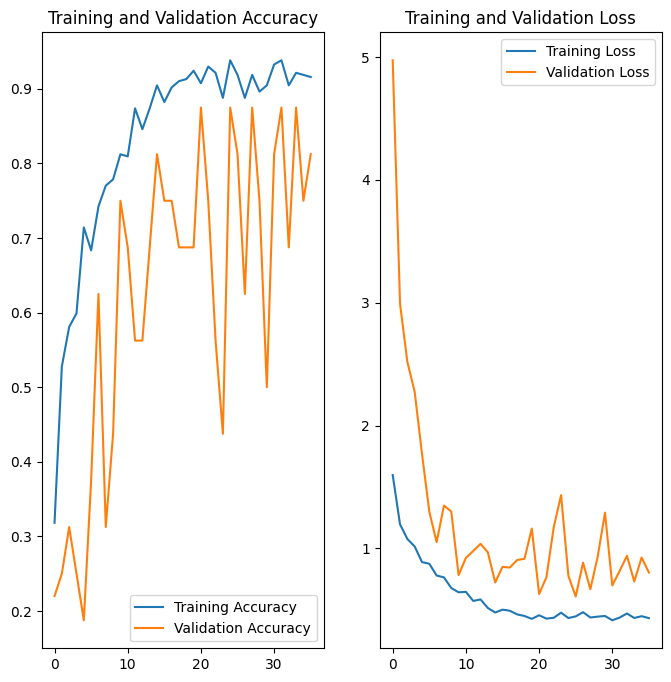

In [ ]:
# Evaluate models
print(model.evaluate_model())
# Plot history
model.plot_history()

In [ ]:
experiment_histories

{'model_experiment_2024-11-0210_06_58.438090/': <keras.src.callbacks.history.History at 0x7b9da3f16740>}

### Experiment 2 -
- image_height=100,
- image_width=100,
- num_of_frames=15,
- batch_size=32,
- num_epochs=50
- adjuster dropouts # change from previous experiment

In [ ]:
# Initialize the DataPreprocessor
preprocessor = DataPreprocessor(image_height=100, image_width=100, num_of_frames=15, batch_size=32, num_epochs=50)
# Set paths
preprocessor.set_paths(train_path=train_path, val_path=val_path)
# Call display_summary, which will compute and print all values
preprocessor.initializePreprocessData(total_frames=total_frames, generator=generator, train_doc=train_doc, val_doc=val_doc)

=== Data Preprocessing Summary ===
Image Height: 100
Image Width: 100
Frames per Video: 15
Batch Size: 32
Number of Epochs: 50
Training Path: Project_data/train
Validation Path: Project_data/val
Input Shape: (15, 100, 100, 3)
Frame Indices: [ 0  2  4  6  8 10 12 14 16 18 20 22 24 26 29]


In [ ]:
# Experiment configuration
experiment_config = {
    "conv_layers": [16, 32, 64],
    "maxpool_layers":[1, 1, 1],
    "kernel_size": (3, 3, 3),
    "dense_units": [128,64],
    "dropout_rate": [0.5,0.25]
}

# Optimizer configuration
optimizer_type = 'SGD'
optimizer_params =None

# Retrieve data generators and shapes
train_generator, val_generator = preprocessor.get_data_generators(generator, train_doc, val_doc)

# Model initialization
model = Conv3DBaseModel(preprocessor.input_shape, num_of_classes,  optimizer_type=optimizer_type, optimizer_params=optimizer_params, model_name="model_experiment")

# Running the experiment
history,model_name=model.run_experiment(
    config=experiment_config,
    train_generator=preprocessor.train_generator,
    val_generator=preprocessor.val_generator,
    num_train_sequences=num_train_sequences,
    num_val_sequences=num_val_sequences,
    batch_size=preprocessor.batch_size,
    num_epochs=preprocessor.num_epochs
)

# Store history in the dictionary for future comparision
experiment_histories[model_name] = history


--- Running Experiment ---
Directory model_experiment_2024-11-0210_32_03.807573/ is ready.


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv3D_1_16F (Conv3D)                │ (None, 15, 100, 100, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_1_16F               │ (None, 15, 100, 100, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_1_16F (Activation)       │ (None, 15, 100, 100, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_1_16F (MaxPooling3D)  │ (None, 7, 50, 50, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_2_32F (Conv3D)                │ (None, 7, 50, 50, 32)       │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_2_32F               │ (None, 7, 50, 50, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_2_32F (Activation)       │ (None, 7, 50, 50, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_2_32F (MaxPooling3D)  │ (None, 3, 25, 25, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_3_64F (Conv3D)                │ (None, 3, 25, 25, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_3_64F               │ (None, 3, 25, 25, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_3_64F (Activation)       │ (None, 3, 25, 25, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_3_64F (MaxPooling3D)  │ (None, 1, 12, 12, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_1_128N (Dense)                 │ (None, 128)                 │       1,179,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Dense_1_128N               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Dense_1_128N (Activation)       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1_50_percent (Dropout)       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_2_64N (Dense)                  │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Dense_2_64N                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │              

 Total params: 1,260,101 (4.81 MB)

 Trainable params: 1,259,493 (4.80 MB)

 Non-trainable params: 608 (2.38 KB)

None
Source path =  Project_data/train ; batch size = 32
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.2449 - loss: 1.9428Source path =  Project_data/val ; batch size = 32

Epoch 1: saving model to model_experiment_2024-11-0210_32_03.807573//model-01-5.41.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - categorical_accuracy: 0.2463 - loss: 1.9382 - val_categorical_accuracy: 0.2000 - val_loss: 5.4053 - learning_rate: 0.0010
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.3567 - loss: 1.5395
Epoch 2: saving model to model_experiment_2024-11-0210_32_03.807573//model-02-3.43.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - categorical_accuracy: 0.3580 - loss: 1.5369 - val_categorical_accuracy: 0.1875 - val_loss: 3.4255 - learning_rate: 0.0010
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.3394 - loss: 1.5396
Epoch 3: saving model to model_experiment_2024-11-0210_32_03.807573//model-03-3.54.keras
21/21 ━━━━━━━━━

(0.7927170991897583, 0.875, 0.6839925050735474, 0.6172975301742554)


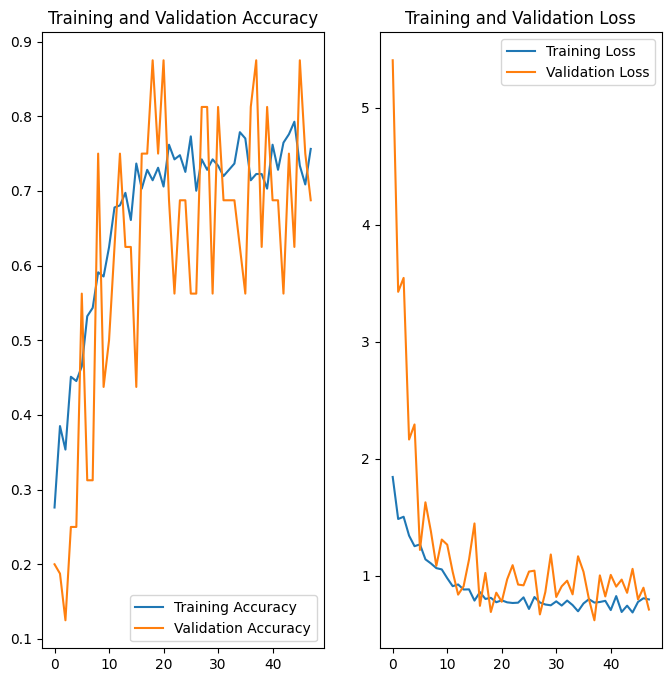

In [ ]:
# Evaluate models
print(model.evaluate_model())
# Plot history
model.plot_history()

In [ ]:
experiment_histories

{'model_experiment_2024-11-0210_06_58.438090/': <keras.src.callbacks.history.History at 0x7b9da3f16740>,
 'model_experiment_2024-11-0210_32_03.807573/': <keras.src.callbacks.history.History at 0x7b9da30f91b0>}

### Experiment 3 -
- image_height=120, # change - increased image height
- image_width=120, # change - increased image width
- num_of_frames=15,
- batch_size=32,
- num_epochs=50

In [ ]:
# Initialize the DataPreprocessor
preprocessor = DataPreprocessor(image_height=120, image_width=120, num_of_frames=15, batch_size=32, num_epochs=50)
# Set paths
preprocessor.set_paths(train_path=train_path, val_path=val_path)
# Call display_summary, which will compute and print all values
preprocessor.initializePreprocessData(total_frames=total_frames, generator=generator, train_doc=train_doc, val_doc=val_doc)

=== Data Preprocessing Summary ===
Image Height: 120
Image Width: 120
Frames per Video: 15
Batch Size: 32
Number of Epochs: 50
Training Path: Project_data/train
Validation Path: Project_data/val
Input Shape: (15, 120, 120, 3)
Frame Indices: [ 0  2  4  6  8 10 12 14 16 18 20 22 24 26 29]


In [ ]:
# Experiment configuration
experiment_config = {
    "conv_layers": [16, 32, 64],
    "maxpool_layers":[1, 1, 1],
    "kernel_size": (3, 3, 3),
    "dense_units": [128,64],
    "dropout_rate": [0.50,0.25]
}

# Optimizer configuration
optimizer_type = 'SGD'
optimizer_params =None

# Retrieve data generators and shapes
train_generator, val_generator = preprocessor.get_data_generators(generator, train_doc, val_doc)

# Model initialization
model = Conv3DBaseModel(preprocessor.input_shape, num_of_classes, optimizer_type=optimizer_type, optimizer_params=optimizer_params, model_name="model_experiment")

# Running the experiment
history,model_name=model.run_experiment(
    config=experiment_config,
    train_generator=preprocessor.train_generator,
    val_generator=preprocessor.val_generator,
    num_train_sequences=num_train_sequences,
    num_val_sequences=num_val_sequences,
    batch_size=preprocessor.batch_size,
    num_epochs=preprocessor.num_epochs
)

# Store history in the dictionary for future comparision
experiment_histories[model_name] = history


--- Running Experiment ---
Directory model_experiment_2024-11-0211_02_30.965120/ is ready.


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv3D_1_16F (Conv3D)                │ (None, 15, 120, 120, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_1_16F               │ (None, 15, 120, 120, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_1_16F (Activation)       │ (None, 15, 120, 120, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_1_16F (MaxPooling3D)  │ (None, 7, 60, 60, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_2_32F (Conv3D)                │ (None, 7, 60, 60, 32)       │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_2_32F               │ (None, 7, 60, 60, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_2_32F (Activation)       │ (None, 7, 60, 60, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_2_32F (MaxPooling3D)  │ (None, 3, 30, 30, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_3_64F (Conv3D)                │ (None, 3, 30, 30, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_3_64F               │ (None, 3, 30, 30, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_3_64F (Activation)       │ (None, 3, 30, 30, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_3_64F (MaxPooling3D)  │ (None, 1, 15, 15, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_1_128N (Dense)                 │ (None, 128)                 │       1,843,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Dense_1_128N               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Dense_1_128N (Activation)       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1_50_percent (Dropout)       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_2_64N (Dense)                  │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Dense_2_64N                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │              

 Total params: 1,923,653 (7.34 MB)

 Trainable params: 1,923,045 (7.34 MB)

 Non-trainable params: 608 (2.38 KB)

None
Source path =  Project_data/train ; batch size = 32
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.2248 - loss: 1.9087Source path =  Project_data/val ; batch size = 32

Epoch 1: saving model to model_experiment_2024-11-0211_02_30.965120//model-01-6.14.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 98s 4s/step - categorical_accuracy: 0.2263 - loss: 1.9025 - val_categorical_accuracy: 0.2200 - val_loss: 6.1407 - learning_rate: 0.0010
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.3759 - loss: 1.5223
Epoch 2: saving model to model_experiment_2024-11-0211_02_30.965120//model-02-3.44.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - categorical_accuracy: 0.3767 - loss: 1.5201 - val_categorical_accuracy: 0.1875 - val_loss: 3.4381 - learning_rate: 0.0010
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.4445 - loss: 1.3758
Epoch 3: saving model to model_experiment_2024-11-0211_02_30.965120//model-03-2.92.keras
21/21 ━━━━━━━━━

(0.7787114977836609, 0.9375, 0.7236306071281433, 0.5625859498977661)


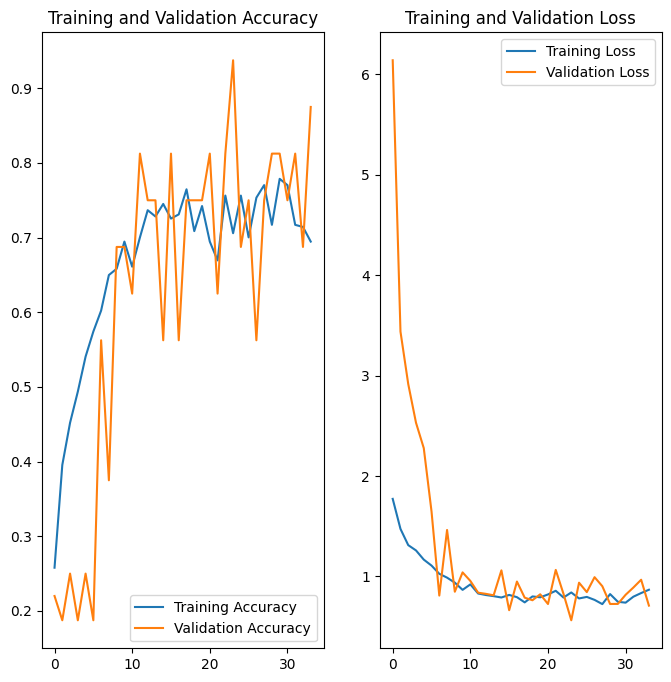

In [ ]:
# Evaluate models
print(model.evaluate_model())
# Plot history
model.plot_history()

In [ ]:
experiment_histories

{'model_experiment_2024-11-0210_06_58.438090/': <keras.src.callbacks.history.History at 0x7b9da3f16740>,
 'model_experiment_2024-11-0210_32_03.807573/': <keras.src.callbacks.history.History at 0x7b9da30f91b0>,
 'model_experiment_2024-11-0211_02_30.965120/': <keras.src.callbacks.history.History at 0x7b9da2621210>}

### Experiment 4 -
- image_height=100, # change - reduced image height to same as experiment 1
- image_width=100, # change - reduced image width to same experiment 1
- num_of_frames=20, # change - increased frame count
- batch_size=32,
- num_epochs=50

In [ ]:
# Initialize the DataPreprocessor
preprocessor = DataPreprocessor(image_height=100, image_width=100, num_of_frames=20, batch_size=32, num_epochs=50)
# Set paths
preprocessor.set_paths(train_path=train_path, val_path=val_path)
# Call display_summary, which will compute and print all values
preprocessor.initializePreprocessData(total_frames=total_frames, generator=generator, train_doc=train_doc, val_doc=val_doc)

=== Data Preprocessing Summary ===
Image Height: 100
Image Width: 100
Frames per Video: 20
Batch Size: 32
Number of Epochs: 50
Training Path: Project_data/train
Validation Path: Project_data/val
Input Shape: (20, 100, 100, 3)
Frame Indices: [ 0  1  3  4  6  7  9 10 12 13 15 16 18 19 21 22 24 25 27 29]


In [ ]:
# Experiment configuration
experiment_config = {
    "conv_layers": [16, 32, 64],
    "maxpool_layers":[1, 1, 1],
    "kernel_size": (3, 3, 3),
    "dense_units": [128,64],
    "dropout_rate": [0.50,0.25]
}

# Optimizer configuration
optimizer_type = 'SGD'
optimizer_params =None

# Retrieve data generators and shapes
train_generator, val_generator = preprocessor.get_data_generators(generator, train_doc, val_doc)

# Model initialization
model = Conv3DBaseModel(preprocessor.input_shape, num_of_classes, optimizer_type=optimizer_type, optimizer_params=optimizer_params, model_name="model_experiment")

# Running the experiment
history,model_name=model.run_experiment(
    config=experiment_config,
    train_generator=preprocessor.train_generator,
    val_generator=preprocessor.val_generator,
    num_train_sequences=num_train_sequences,
    num_val_sequences=num_val_sequences,
    batch_size=preprocessor.batch_size,
    num_epochs=preprocessor.num_epochs
)

# Store history in the dictionary for future comparision
experiment_histories[model_name] = history


--- Running Experiment ---
Directory model_experiment_2024-11-0211_27_17.013324/ is ready.


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv3D_1_16F (Conv3D)                │ (None, 20, 100, 100, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_1_16F               │ (None, 20, 100, 100, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_1_16F (Activation)       │ (None, 20, 100, 100, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_1_16F (MaxPooling3D)  │ (None, 10, 50, 50, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_2_32F (Conv3D)                │ (None, 10, 50, 50, 32)      │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_2_32F               │ (None, 10, 50, 50, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_2_32F (Activation)       │ (None, 10, 50, 50, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_2_32F (MaxPooling3D)  │ (None, 5, 25, 25, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_3_64F (Conv3D)                │ (None, 5, 25, 25, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_3_64F               │ (None, 5, 25, 25, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_3_64F (Activation)       │ (None, 5, 25, 25, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_3_64F (MaxPooling3D)  │ (None, 2, 12, 12, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_1_128N (Dense)                 │ (None, 128)                 │       2,359,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Dense_1_128N               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Dense_1_128N (Activation)       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1_50_percent (Dropout)       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_2_64N (Dense)                  │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Dense_2_64N                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │              

 Total params: 2,439,749 (9.31 MB)

 Trainable params: 2,439,141 (9.30 MB)

 Non-trainable params: 608 (2.38 KB)

None
Source path =  Project_data/train ; batch size = 32
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.2498 - loss: 1.9323Source path =  Project_data/val ; batch size = 32

Epoch 1: saving model to model_experiment_2024-11-0211_27_17.013324//model-01-5.60.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 117s 5s/step - categorical_accuracy: 0.2508 - loss: 1.9276 - val_categorical_accuracy: 0.2300 - val_loss: 5.5959 - learning_rate: 0.0010
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.3693 - loss: 1.4542
Epoch 2: saving model to model_experiment_2024-11-0211_27_17.013324//model-02-4.99.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - categorical_accuracy: 0.3702 - loss: 1.4517 - val_categorical_accuracy: 0.3125 - val_loss: 4.9915 - learning_rate: 0.0010
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.4656 - loss: 1.3527
Epoch 3: saving model to model_experiment_2024-11-0211_27_17.013324//model-03-2.41.keras
21/21 ━━━━━━━━

(0.918767511844635, 0.9375, 0.4157131314277649, 0.43138277530670166)


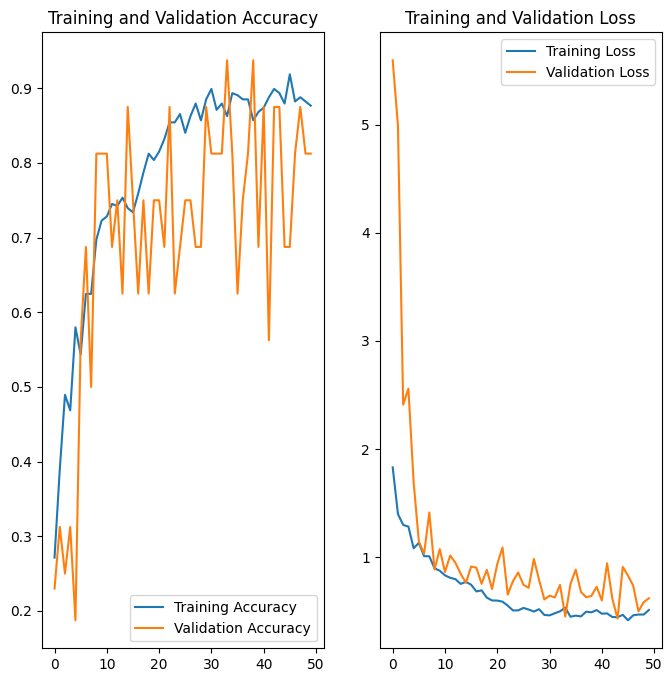

In [ ]:
# Evaluate models
print(model.evaluate_model())
# Plot history
model.plot_history()

In [ ]:
experiment_histories

{'model_experiment_2024-11-0210_06_58.438090/': <keras.src.callbacks.history.History at 0x7b9da3f16740>,
 'model_experiment_2024-11-0210_32_03.807573/': <keras.src.callbacks.history.History at 0x7b9da30f91b0>,
 'model_experiment_2024-11-0211_02_30.965120/': <keras.src.callbacks.history.History at 0x7b9da2621210>,
 'model_experiment_2024-11-0211_27_17.013324/': <keras.src.callbacks.history.History at 0x7b9da25e32b0>}

### Experiment 5 -
- image_height=50, # change - reduced image height upto 50%
- image_width=50, # change - reduced image width upto 50%
- num_of_frames=20,
- batch_size=32,
- num_epochs=50

In [ ]:
# Initialize the DataPreprocessor
preprocessor = DataPreprocessor(image_height=50, image_width=50, num_of_frames=20, batch_size=32, num_epochs=50)
# Set paths
preprocessor.set_paths(train_path=train_path, val_path=val_path)
# Call display_summary, which will compute and print all values
preprocessor.initializePreprocessData(total_frames=total_frames, generator=generator, train_doc=train_doc, val_doc=val_doc)

=== Data Preprocessing Summary ===
Image Height: 50
Image Width: 50
Frames per Video: 20
Batch Size: 32
Number of Epochs: 50
Training Path: Project_data/train
Validation Path: Project_data/val
Input Shape: (20, 50, 50, 3)
Frame Indices: [ 0  1  3  4  6  7  9 10 12 13 15 16 18 19 21 22 24 25 27 29]


In [ ]:
# Experiment configuration
experiment_config = {
    "conv_layers": [16, 32, 64],
    "kernel_size": (3, 3, 3),
    "dense_units": [128, 64],
    "dropout_rate": [0.50, 0.25],
    "maxpool_layers":[1, 1, 1]
}

# Optimizer configuration
optimizer_type = 'SGD'
optimizer_params =None

# Retrieve data generators and shapes
train_generator, val_generator = preprocessor.get_data_generators(generator, train_doc, val_doc)

# Model initialization
model = Conv3DBaseModel(preprocessor.input_shape, num_of_classes, optimizer_type=optimizer_type, optimizer_params=optimizer_params, model_name="model_experiment")

# Running the experiment
history,model_name=model.run_experiment(
    config=experiment_config,
    train_generator=preprocessor.train_generator,
    val_generator=preprocessor.val_generator,
    num_train_sequences=num_train_sequences,
    num_val_sequences=num_val_sequences,
    batch_size=preprocessor.batch_size,
    num_epochs=preprocessor.num_epochs
)


--- Running Experiment ---
Directory model_experiment_2024-11-0212_09_44.741585/ is ready.


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv3D_1_16F (Conv3D)                │ (None, 20, 50, 50, 16)      │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_1_16F               │ (None, 20, 50, 50, 16)      │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_1_16F (Activation)       │ (None, 20, 50, 50, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_1_16F (MaxPooling3D)  │ (None, 10, 25, 25, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_2_32F (Conv3D)                │ (None, 10, 25, 25, 32)      │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_2_32F               │ (None, 10, 25, 25, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_2_32F (Activation)       │ (None, 10, 25, 25, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_2_32F (MaxPooling3D)  │ (None, 5, 12, 12, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_3_64F (Conv3D)                │ (None, 5, 12, 12, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_3_64F               │ (None, 5, 12, 12, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_3_64F (Activation)       │ (None, 5, 12, 12, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_3_64F (MaxPooling3D)  │ (None, 2, 6, 6, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_1_128N (Dense)                 │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Dense_1_128N               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Dense_1_128N (Activation)       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1_50_percent (Dropout)       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_2_64N (Dense)                  │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Dense_2_64N                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │              

 Total params: 670,277 (2.56 MB)

 Trainable params: 669,669 (2.55 MB)

 Non-trainable params: 608 (2.38 KB)

None
Source path =  Project_data/train ; batch size = 32
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.2295 - loss: 1.9329Source path =  Project_data/val ; batch size = 32

Epoch 1: saving model to model_experiment_2024-11-0212_09_44.741585//model-01-1.81.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 92s 4s/step - categorical_accuracy: 0.2295 - loss: 1.9315 - val_categorical_accuracy: 0.2700 - val_loss: 1.8064 - learning_rate: 0.0010
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.3270 - loss: 1.6125
Epoch 2: saving model to model_experiment_2024-11-0212_09_44.741585//model-02-1.48.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - categorical_accuracy: 0.3261 - loss: 1.6140 - val_categorical_accuracy: 0.3750 - val_loss: 1.4811 - learning_rate: 0.0010
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.3723 - loss: 1.5148
Epoch 3: saving model to model_experiment_2024-11-0212_09_44.741585//model-03-2.03.keras
21/21 ━━━━━━━━━

(0.6358543634414673, 0.8125, 1.0354087352752686, 0.9141055345535278)


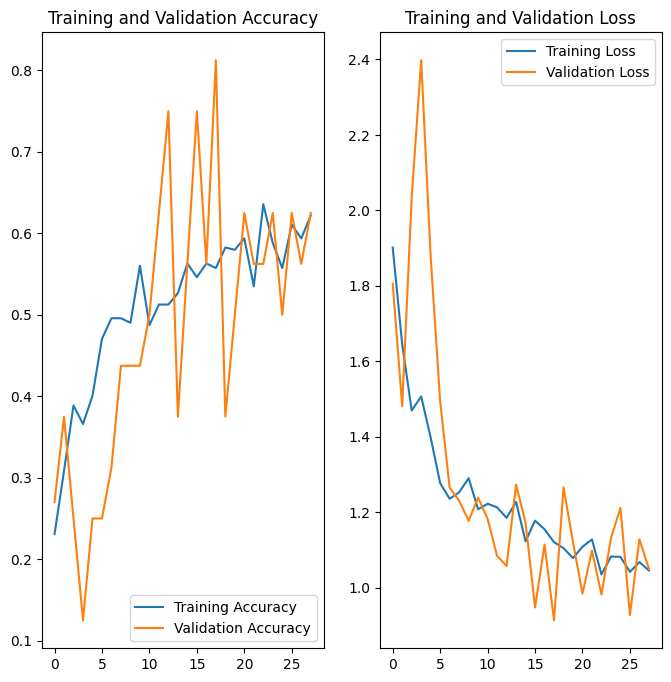

In [ ]:
# Evaluate models
print(model.evaluate_model())
# Plot history
model.plot_history()

In [ ]:
# Store history in the dictionary for future comparision
experiment_histories[model_name] = history
experiment_histories

{'model_experiment_2024-11-0210_06_58.438090/': <keras.src.callbacks.history.History at 0x7b9da3f16740>,
 'model_experiment_2024-11-0210_32_03.807573/': <keras.src.callbacks.history.History at 0x7b9da30f91b0>,
 'model_experiment_2024-11-0211_02_30.965120/': <keras.src.callbacks.history.History at 0x7b9da2621210>,
 'model_experiment_2024-11-0211_27_17.013324/': <keras.src.callbacks.history.History at 0x7b9da25e32b0>,
 'model_experiment_2024-11-0212_09_44.741585/': <keras.src.callbacks.history.History at 0x7b9da1a64640>}

### Experiment 6 -
- image_height=100, # change - same as used in experiment 4
- image_width=100, # change - same as used in experiment 4
- num_of_frames=20, # same as used in experiment 4
- batch_size=32, # same as used in experiment 4
- num_epochs=50 # same as used in experiment 4
- Extra CNN Layer # change - from previous experiment

In [ ]:
# Initialize the DataPreprocessor
preprocessor = DataPreprocessor(image_height=100, image_width=100, num_of_frames=20, batch_size=32, num_epochs=50)
# Set paths
preprocessor.set_paths(train_path=train_path, val_path=val_path)
# Call display_summary, which will compute and print all values
preprocessor.initializePreprocessData(total_frames=total_frames, generator=generator, train_doc=train_doc, val_doc=val_doc)

=== Data Preprocessing Summary ===
Image Height: 100
Image Width: 100
Frames per Video: 20
Batch Size: 32
Number of Epochs: 50
Training Path: Project_data/train
Validation Path: Project_data/val
Input Shape: (20, 100, 100, 3)
Frame Indices: [ 0  1  3  4  6  7  9 10 12 13 15 16 18 19 21 22 24 25 27 29]


In [ ]:
# Experiment configuration
experiment_config = {
    "conv_layers": [16, 32, 64, 128],
    "maxpool_layers":[1, 1, 1, 1],
    "kernel_size": (3, 3, 3),
    "dense_units": [128,64],
    "dropout_rate": [0.50,0.25]
}

# Optimizer configuration
optimizer_type = 'SGD'
optimizer_params =None

# Retrieve data generators and shapes
train_generator, val_generator = preprocessor.get_data_generators(generator, train_doc, val_doc)

# Model initialization
model = Conv3DBaseModel(preprocessor.input_shape, num_of_classes, optimizer_type=optimizer_type, optimizer_params=optimizer_params, model_name="model_experiment")

# Running the experiment
history,model_name=model.run_experiment(
    config=experiment_config,
    train_generator=preprocessor.train_generator,
    val_generator=preprocessor.val_generator,
    num_train_sequences=num_train_sequences,
    num_val_sequences=num_val_sequences,
    batch_size=preprocessor.batch_size,
    num_epochs=preprocessor.num_epochs
)

# Store history in the dictionary for future comparision
experiment_histories[model_name] = history


--- Running Experiment ---
Directory model_experiment_2024-11-0212_54_06.162495/ is ready.


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv3D_1_16F (Conv3D)                │ (None, 20, 100, 100, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_1_16F               │ (None, 20, 100, 100, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_1_16F (Activation)       │ (None, 20, 100, 100, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_1_16F (MaxPooling3D)  │ (None, 10, 50, 50, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_2_32F (Conv3D)                │ (None, 10, 50, 50, 32)      │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_2_32F               │ (None, 10, 50, 50, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_2_32F (Activation)       │ (None, 10, 50, 50, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_2_32F (MaxPooling3D)  │ (None, 5, 25, 25, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_3_64F (Conv3D)                │ (None, 5, 25, 25, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_3_64F               │ (None, 5, 25, 25, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_3_64F (Activation)       │ (None, 5, 25, 25, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_3_64F (MaxPooling3D)  │ (None, 2, 12, 12, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_4_128F (Conv3D)               │ (None, 2, 12, 12, 128)      │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_4_128F              │ (None, 2, 12, 12, 128)      │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_4_128F (Activation)      │ (None, 2, 12, 12, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_4_128F (MaxPooling3D) │ (None, 1, 6, 6, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_1_128N (Dense)                 │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Dense_1_128N               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │              

 Total params: 892,101 (3.40 MB)

 Trainable params: 891,237 (3.40 MB)

 Non-trainable params: 864 (3.38 KB)

None
Source path =  Project_data/train ; batch size = 32
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.2300 - loss: 1.8445Source path =  Project_data/val ; batch size = 32

Epoch 1: saving model to model_experiment_2024-11-0212_54_06.162495//model-01-1.91.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 110s 5s/step - categorical_accuracy: 0.2325 - loss: 1.8401 - val_categorical_accuracy: 0.3500 - val_loss: 1.9146 - learning_rate: 0.0010
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.3831 - loss: 1.4955
Epoch 2: saving model to model_experiment_2024-11-0212_54_06.162495//model-02-1.79.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - categorical_accuracy: 0.3818 - loss: 1.4962 - val_categorical_accuracy: 0.3125 - val_loss: 1.7881 - learning_rate: 0.0010
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.4567 - loss: 1.3401
Epoch 3: saving model to model_experiment_2024-11-0212_54_06.162495//model-03-2.43.keras
21/21 ━━━━━━━━

(0.7086834907531738, 1.0, 0.8283394575119019, 0.7288434505462646)


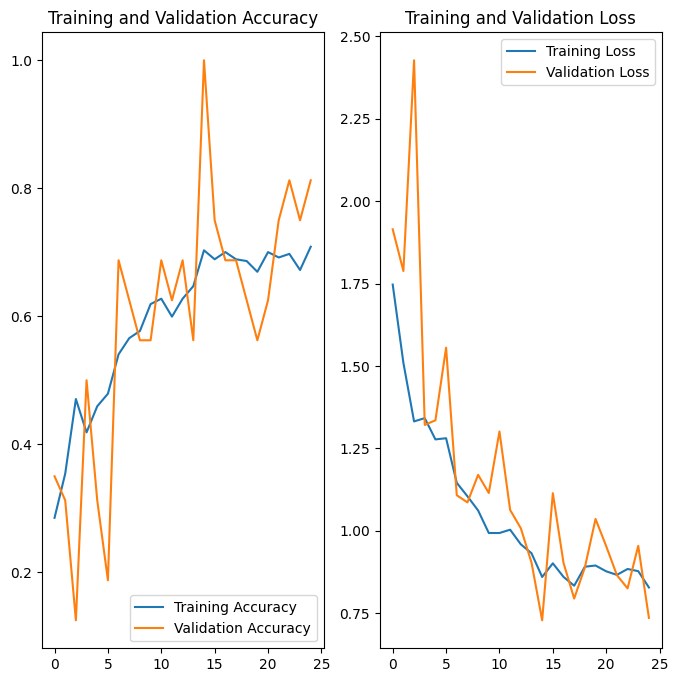

In [ ]:
# Evaluate models
print(model.evaluate_model())
# Plot history
model.plot_history()

In [ ]:
experiment_histories

{'model_experiment_2024-11-0210_06_58.438090/': <keras.src.callbacks.history.History at 0x7b9da3f16740>,
 'model_experiment_2024-11-0210_32_03.807573/': <keras.src.callbacks.history.History at 0x7b9da30f91b0>,
 'model_experiment_2024-11-0211_02_30.965120/': <keras.src.callbacks.history.History at 0x7b9da2621210>,
 'model_experiment_2024-11-0211_27_17.013324/': <keras.src.callbacks.history.History at 0x7b9da25e32b0>,
 'model_experiment_2024-11-0212_09_44.741585/': <keras.src.callbacks.history.History at 0x7b9da1a64640>,
 'model_experiment_2024-11-0212_54_06.162495/': <keras.src.callbacks.history.History at 0x7b9da21414e0>}

### Experiment 7 -
- image_height=100, # change - same as used in experiment 4
- image_width=100, # change - same as used in experiment 4
- num_of_frames=20, # same as used in experiment 4
- batch_size=32, # same as used in experiment 4
- num_epochs=50 # same as used in experiment 4
- Extra CNN Layer # change - from previous experiment
- More Dense Layers # change - extra Dense layer

In [ ]:
# Initialize the DataPreprocessor
preprocessor = DataPreprocessor(image_height=100, image_width=100, num_of_frames=20, batch_size=32, num_epochs=50)
# Set paths
preprocessor.set_paths(train_path=train_path, val_path=val_path)
# Call display_summary, which will compute and print all values
preprocessor.initializePreprocessData(total_frames=total_frames, generator=generator, train_doc=train_doc, val_doc=val_doc)

=== Data Preprocessing Summary ===
Image Height: 100
Image Width: 100
Frames per Video: 20
Batch Size: 32
Number of Epochs: 50
Training Path: Project_data/train
Validation Path: Project_data/val
Input Shape: (20, 100, 100, 3)
Frame Indices: [ 0  1  3  4  6  7  9 10 12 13 15 16 18 19 21 22 24 25 27 29]


In [ ]:
# Experiment configuration
experiment_config = {
    "conv_layers": [16, 32, 64, 128],
    "maxpool_layers":[1, 1, 1, 1],
    "kernel_size": (3, 3, 3),
    "dense_units": [256, 128, 64],
    "dropout_rate": [0.50, 0.40, 0.30]
}

# Optimizer configuration
optimizer_type = 'SGD'
optimizer_params =None

# Retrieve data generators and shapes
train_generator, val_generator = preprocessor.get_data_generators(generator, train_doc, val_doc)

# Model initialization
model = Conv3DBaseModel(preprocessor.input_shape, num_of_classes, optimizer_type=optimizer_type, optimizer_params=optimizer_params, model_name="model_experiment")

# Running the experiment
history,model_name=model.run_experiment(
    config=experiment_config,
    train_generator=preprocessor.train_generator,
    val_generator=preprocessor.val_generator,
    num_train_sequences=num_train_sequences,
    num_val_sequences=num_val_sequences,
    batch_size=preprocessor.batch_size,
    num_epochs=preprocessor.num_epochs
)

# Store history in the dictionary for future comparision
experiment_histories[model_name] = history


--- Running Experiment ---
Directory model_experiment_2024-11-0212_54_06.162495/ is ready.


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv3D_1_16F (Conv3D)                │ (None, 20, 100, 100, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_1_16F               │ (None, 20, 100, 100, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_1_16F (Activation)       │ (None, 20, 100, 100, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_1_16F (MaxPooling3D)  │ (None, 10, 50, 50, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_2_32F (Conv3D)                │ (None, 10, 50, 50, 32)      │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_2_32F               │ (None, 10, 50, 50, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_2_32F (Activation)       │ (None, 10, 50, 50, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_2_32F (MaxPooling3D)  │ (None, 5, 25, 25, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_3_64F (Conv3D)                │ (None, 5, 25, 25, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_3_64F               │ (None, 5, 25, 25, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_3_64F (Activation)       │ (None, 5, 25, 25, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_3_64F (MaxPooling3D)  │ (None, 2, 12, 12, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_4_128F (Conv3D)               │ (None, 2, 12, 12, 128)      │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_4_128F              │ (None, 2, 12, 12, 128)      │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_4_128F (Activation)      │ (None, 2, 12, 12, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_4_128F (MaxPooling3D) │ (None, 1, 6, 6, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_1_128N (Dense)                 │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Dense_1_128N               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │              

 Total params: 892,101 (3.40 MB)

 Trainable params: 891,237 (3.40 MB)

 Non-trainable params: 864 (3.38 KB)

None
Source path =  Project_data/train ; batch size = 32
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.2300 - loss: 1.8445Source path =  Project_data/val ; batch size = 32

Epoch 1: saving model to model_experiment_2024-11-0212_54_06.162495//model-01-1.91.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 110s 5s/step - categorical_accuracy: 0.2325 - loss: 1.8401 - val_categorical_accuracy: 0.3500 - val_loss: 1.9146 - learning_rate: 0.0010
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.3831 - loss: 1.4955
Epoch 2: saving model to model_experiment_2024-11-0212_54_06.162495//model-02-1.79.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - categorical_accuracy: 0.3818 - loss: 1.4962 - val_categorical_accuracy: 0.3125 - val_loss: 1.7881 - learning_rate: 0.0010
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.4567 - loss: 1.3401
Epoch 3: saving model to model_experiment_2024-11-0212_54_06.162495//model-03-2.43.keras
21/21 ━━━━━━━━

(0.7086834907531738, 1.0, 0.8283394575119019, 0.7288434505462646)


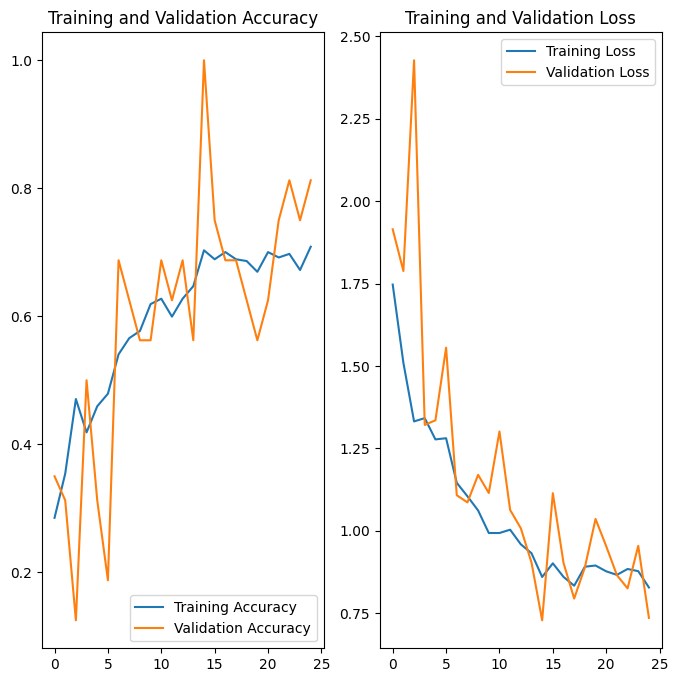

In [ ]:
# Evaluate models
print(model.evaluate_model())
# Plot history
model.plot_history()

In [ ]:
experiment_histories

{'model_experiment_2024-11-0210_06_58.438090/': <keras.src.callbacks.history.History at 0x7b9da3f16740>,
 'model_experiment_2024-11-0210_32_03.807573/': <keras.src.callbacks.history.History at 0x7b9da30f91b0>,
 'model_experiment_2024-11-0211_02_30.965120/': <keras.src.callbacks.history.History at 0x7b9da2621210>,
 'model_experiment_2024-11-0211_27_17.013324/': <keras.src.callbacks.history.History at 0x7b9da25e32b0>,
 'model_experiment_2024-11-0212_09_44.741585/': <keras.src.callbacks.history.History at 0x7b9da1a64640>,
 'model_experiment_2024-11-0212_54_06.162495/': <keras.src.callbacks.history.History at 0x7b9da21414e0>}

### Experiment 8 -
- image_height=100, # change - same as used in experiment 4
- image_width=100, # change - same as used in experiment 4
- num_of_frames=20, # same as used in experiment 4
- batch_size=32, # same as used in experiment 4
- num_epochs=50 # same as used in experiment 4
- More CNN Layers , and alternate MaxPoolLayers in Conv layers # change - major change in CNN architecture

In [ ]:
# Initialize the DataPreprocessor
preprocessor = DataPreprocessor(image_height=100, image_width=100, num_of_frames=20, batch_size=32, num_epochs=50)
# Set paths
preprocessor.set_paths(train_path=train_path, val_path=val_path)
# Call display_summary, which will compute and print all values
preprocessor.initializePreprocessData(total_frames=total_frames, generator=generator, train_doc=train_doc, val_doc=val_doc)

=== Data Preprocessing Summary ===
Image Height: 100
Image Width: 100
Frames per Video: 20
Batch Size: 32
Number of Epochs: 50
Training Path: Project_data/train
Validation Path: Project_data/val
Input Shape: (20, 100, 100, 3)
Frame Indices: [ 0  1  3  4  6  7  9 10 12 13 15 16 18 19 21 22 24 25 27 29]


In [ ]:
# Experiment configuration
experiment_config = {
    "conv_layers": [16, 16, 32, 32, 64, 64, 128, 128],
    "maxpool_layers":[0, 1, 0, 1, 0, 1, 0, 1],
    "kernel_size": (3, 3, 3),
    "dense_units": [128, 64],
    "dropout_rate": [0.50,0.25]
}

# Optimizer configuration
optimizer_type = 'SGD'
optimizer_params =None

# Retrieve data generators and shapes
train_generator, val_generator = preprocessor.get_data_generators(generator, train_doc, val_doc)

# Model initialization
model = Conv3DBaseModel(preprocessor.input_shape, num_of_classes, optimizer_type=optimizer_type, optimizer_params=optimizer_params, model_name="model_experiment")

# Running the experiment
history,model_name=model.run_experiment(
    config=experiment_config,
    train_generator=preprocessor.train_generator,
    val_generator=preprocessor.val_generator,
    num_train_sequences=num_train_sequences,
    num_val_sequences=num_val_sequences,
    batch_size=preprocessor.batch_size,
    num_epochs=preprocessor.num_epochs
)


--- Running Experiment ---
Directory model_experiment_2024-11-0213_16_07.504287/ is ready.


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv3D_1_16F (Conv3D)                │ (None, 20, 100, 100, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_1_16F               │ (None, 20, 100, 100, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_1_16F (Activation)       │ (None, 20, 100, 100, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_2_16F (Conv3D)                │ (None, 20, 100, 100, 16)    │           6,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_2_16F               │ (None, 20, 100, 100, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_2_16F (Activation)       │ (None, 20, 100, 100, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_2_16F (MaxPooling3D)  │ (None, 10, 50, 50, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_3_32F (Conv3D)                │ (None, 10, 50, 50, 32)      │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_3_32F               │ (None, 10, 50, 50, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_3_32F (Activation)       │ (None, 10, 50, 50, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_4_32F (Conv3D)                │ (None, 10, 50, 50, 32)      │          27,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_4_32F               │ (None, 10, 50, 50, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_4_32F (Activation)       │ (None, 10, 50, 50, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_4_32F (MaxPooling3D)  │ (None, 5, 25, 25, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_5_64F (Conv3D)                │ (None, 5, 25, 25, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_5_64F               │ (None, 5, 25, 25, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_5_64F (Activation)       │ (None, 5, 25, 25, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_6_64F (Conv3D)                │ (None, 5, 25, 25, 64)       │         110,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_6_64F               │ (None, 5, 25, 25, 64)       │             2

 Total params: 1,480,821 (5.65 MB)

 Trainable params: 1,479,477 (5.64 MB)

 Non-trainable params: 1,344 (5.25 KB)

None
Source path =  Project_data/train ; batch size = 32
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.2389 - loss: 1.9021Source path =  Project_data/val ; batch size = 32

Epoch 1: saving model to model_experiment_2024-11-0213_16_07.504287//model-01-1.65.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 143s 6s/step - categorical_accuracy: 0.2403 - loss: 1.8978 - val_categorical_accuracy: 0.2000 - val_loss: 1.6536 - learning_rate: 0.0010
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.3937 - loss: 1.5663
Epoch 2: saving model to model_experiment_2024-11-0213_16_07.504287//model-02-1.53.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - categorical_accuracy: 0.3925 - loss: 1.5666 - val_categorical_accuracy: 0.3125 - val_loss: 1.5313 - learning_rate: 0.0010
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.3733 - loss: 1.4968
Epoch 3: saving model to model_experiment_2024-11-0213_16_07.504287//model-03-1.45.keras
21/21 ━━━━━━━━

(0.8711484670639038, 0.9375, 0.4362711012363434, 0.33637839555740356)


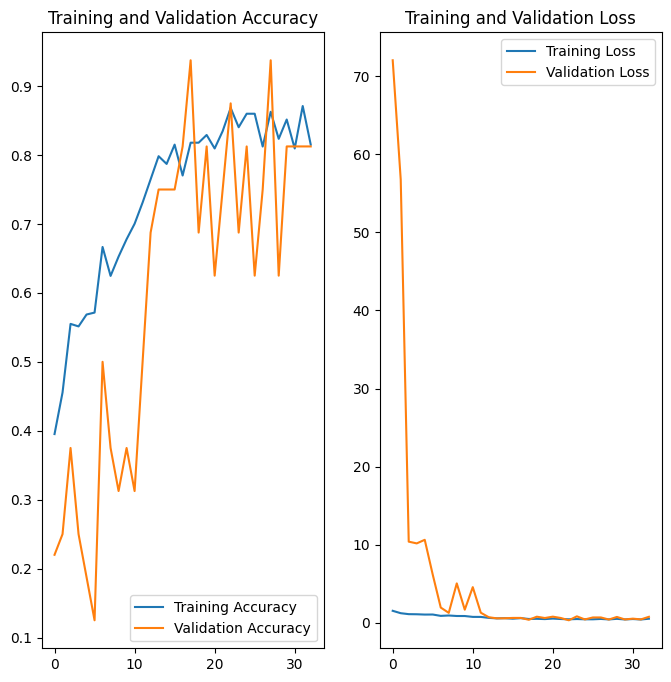

In [ ]:
# Evaluate models
print(model.evaluate_model())
# Plot history
model.plot_history()

In [ ]:
# Store history in the dictionary for future comparision
experiment_histories[model_name] = history
experiment_histories

{'model_experiment_2024-11-0210_06_58.438090/': <keras.src.callbacks.history.History at 0x7b9da3f16740>,
 'model_experiment_2024-11-0210_32_03.807573/': <keras.src.callbacks.history.History at 0x7b9da30f91b0>,
 'model_experiment_2024-11-0211_02_30.965120/': <keras.src.callbacks.history.History at 0x7b9da2621210>,
 'model_experiment_2024-11-0211_27_17.013324/': <keras.src.callbacks.history.History at 0x7b9da25e32b0>,
 'model_experiment_2024-11-0212_09_44.741585/': <keras.src.callbacks.history.History at 0x7b9da1a64640>,
 'model_experiment_2024-11-0212_54_06.162495/': <keras.src.callbacks.history.History at 0x7b9da21414e0>,
 'model_experiment_2024-11-0213_16_07.504287/': <keras.src.callbacks.history.History at 0x7b9d4a6765f0>}

### Experiment 9 -
- image_height=100, # change - same as used in experiment 4
- image_width=100, # change - same as used in experiment 4
- num_of_frames=20, # same as used in experiment 4
- batch_size=32, # same as used in experiment 4
- num_epochs=50 # same as used in experiment 4
- More CNN Layers , and alternate MaxPoolLayers in Conv layers # change - major change in CNN architecture
- Optimizer = "Adam" # change - SGD to Adam

In [ ]:
# Initialize the DataPreprocessor
preprocessor = DataPreprocessor(image_height=100, image_width=100, num_of_frames=20, batch_size=32, num_epochs=50)
# Set paths
preprocessor.set_paths(train_path=train_path, val_path=val_path)
# Call display_summary, which will compute and print all values
preprocessor.initializePreprocessData(total_frames=total_frames, generator=generator, train_doc=train_doc, val_doc=val_doc)

=== Data Preprocessing Summary ===
Image Height: 100
Image Width: 100
Frames per Video: 20
Batch Size: 32
Number of Epochs: 50
Training Path: Project_data/train
Validation Path: Project_data/val
Input Shape: (20, 100, 100, 3)
Frame Indices: [ 0  1  3  4  6  7  9 10 12 13 15 16 18 19 21 22 24 25 27 29]


In [ ]:
# Experiment configuration
experiment_config = {
    "conv_layers": [16, 16, 32, 32, 64, 64, 128, 128],
    "maxpool_layers":[0, 1, 0, 1, 0, 1, 0, 1],
    "kernel_size": (3, 3, 3),
    "dense_units": [128, 64],
    "dropout_rate": [0.50,0.25]
}

# Optimizer configuration
optimizer_type = 'Adam'
optimizer_params =None

# Retrieve data generators and shapes
train_generator, val_generator = preprocessor.get_data_generators(generator, train_doc, val_doc)

# Model initialization
model = Conv3DBaseModel(preprocessor.input_shape, num_of_classes, optimizer_type=optimizer_type, optimizer_params=optimizer_params, model_name="model_experiment")

# Running the experiment
history,model_name=model.run_experiment(
    config=experiment_config,
    train_generator=preprocessor.train_generator,
    val_generator=preprocessor.val_generator,
    num_train_sequences=num_train_sequences,
    num_val_sequences=num_val_sequences,
    batch_size=preprocessor.batch_size,
    num_epochs=preprocessor.num_epochs
)


--- Running Experiment ---


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Directory model_experiment_2024-11-0218_20_07.442089/ is ready.


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv3D_1_16F (Conv3D)                │ (None, 20, 100, 100, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_1_16F               │ (None, 20, 100, 100, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_1_16F (Activation)       │ (None, 20, 100, 100, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_2_16F (Conv3D)                │ (None, 20, 100, 100, 16)    │           6,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_2_16F               │ (None, 20, 100, 100, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_2_16F (Activation)       │ (None, 20, 100, 100, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_2_16F (MaxPooling3D)  │ (None, 10, 50, 50, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_3_32F (Conv3D)                │ (None, 10, 50, 50, 32)      │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_3_32F               │ (None, 10, 50, 50, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_3_32F (Activation)       │ (None, 10, 50, 50, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_4_32F (Conv3D)                │ (None, 10, 50, 50, 32)      │          27,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_4_32F               │ (None, 10, 50, 50, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_4_32F (Activation)       │ (None, 10, 50, 50, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_4_32F (MaxPooling3D)  │ (None, 5, 25, 25, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_5_64F (Conv3D)                │ (None, 5, 25, 25, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_5_64F               │ (None, 5, 25, 25, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_5_64F (Activation)       │ (None, 5, 25, 25, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_6_64F (Conv3D)                │ (None, 5, 25, 25, 64)       │         110,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_6_64F               │ (None, 5, 25, 25, 64)       │             2

 Total params: 1,480,821 (5.65 MB)

 Trainable params: 1,479,477 (5.64 MB)

 Non-trainable params: 1,344 (5.25 KB)

None
Source path =  Project_data/train ; batch size = 32
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.3525 - loss: 1.6577Source path =  Project_data/val ; batch size = 32

Epoch 1: saving model to model_experiment_2024-11-0218_20_07.442089//model-01-72.02.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 159s 6s/step - categorical_accuracy: 0.3544 - loss: 1.6527 - val_categorical_accuracy: 0.2200 - val_loss: 72.0241 - learning_rate: 0.0010
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.4513 - loss: 1.2625
Epoch 2: saving model to model_experiment_2024-11-0218_20_07.442089//model-02-56.76.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - categorical_accuracy: 0.4515 - loss: 1.2616 - val_categorical_accuracy: 0.2500 - val_loss: 56.7618 - learning_rate: 0.0010
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.5284 - loss: 1.1860
Epoch 3: saving model to model_experiment_2024-11-0218_20_07.442089//model-03-10.40.keras
21/21 ━━━

(0.8711484670639038, 0.9375, 0.4362711012363434, 0.33637839555740356)


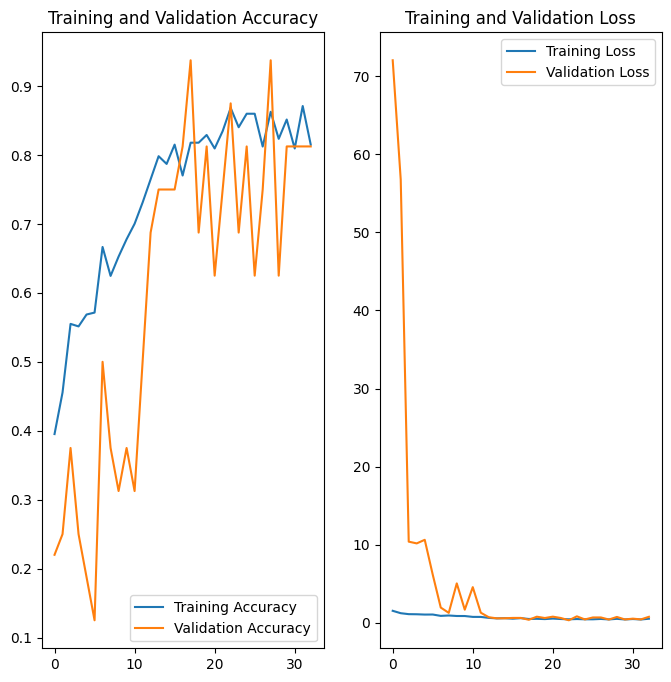

In [ ]:
# Evaluate models
print(model.evaluate_model())
# Plot history
model.plot_history()

In [ ]:
# Store history in the dictionary for future comparision
experiment_histories[model_name] = history
experiment_histories

{'model_experiment_2024-11-0218_20_07.442089/': <keras.src.callbacks.history.History at 0x7d11f4561c90>}

### Experiment 10 -
- image_height=100, # change - same as used in experiment 4
- image_width=100, # change - same as used in experiment 4
- num_of_frames=20, # same as used in experiment 4
- batch_size=32, # same as used in experiment 4
- num_epochs=50 # same as used in experiment 4
- More CNN Layers , and alternate MaxPoolLayers in Conv layers # change - major change in CNN architecture
- Optimizer = "Adam" # change - SGD to Adam
- More Dense Layers # change - extra Dense layer

In [ ]:
# Initialize the DataPreprocessor
preprocessor = DataPreprocessor(image_height=100, image_width=100, num_of_frames=20, batch_size=32, num_epochs=50)
# Set paths
preprocessor.set_paths(train_path=train_path, val_path=val_path)
# Call display_summary, which will compute and print all values
preprocessor.initializePreprocessData(total_frames=total_frames, generator=generator, train_doc=train_doc, val_doc=val_doc)

=== Data Preprocessing Summary ===
Image Height: 100
Image Width: 100
Frames per Video: 20
Batch Size: 32
Number of Epochs: 50
Training Path: Project_data/train
Validation Path: Project_data/val
Input Shape: (20, 100, 100, 3)
Frame Indices: [ 0  1  3  4  6  7  9 10 12 13 15 16 18 19 21 22 24 25 27 29]


In [ ]:
# Experiment configuration
experiment_config = {
    "conv_layers": [16, 16, 32, 32, 64, 64, 128, 128],
    "maxpool_layers":[0, 1, 0, 1, 0, 1, 0, 1],
    "kernel_size": (3, 3, 3),
    "dense_units": [256, 128, 64],
    "dropout_rate": [0.50, 0.40, 0.30]
}

# Optimizer configuration
optimizer_type = 'Adam'
optimizer_params =None

# Retrieve data generators and shapes
train_generator, val_generator = preprocessor.get_data_generators(generator, train_doc, val_doc)

# Model initialization
model = Conv3DBaseModel(preprocessor.input_shape, num_of_classes, optimizer_type=optimizer_type, optimizer_params=optimizer_params, model_name="model_experiment")

# Running the experiment
history,model_name=model.run_experiment(
    config=experiment_config,
    train_generator=preprocessor.train_generator,
    val_generator=preprocessor.val_generator,
    num_train_sequences=num_train_sequences,
    num_val_sequences=num_val_sequences,
    batch_size=preprocessor.batch_size,
    num_epochs=preprocessor.num_epochs
)


--- Running Experiment ---


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Directory model_experiment_2024-11-0219_06_17.208860/ is ready.


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv3D_1_16F (Conv3D)                │ (None, 20, 100, 100, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_1_16F               │ (None, 20, 100, 100, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_1_16F (Activation)       │ (None, 20, 100, 100, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_2_16F (Conv3D)                │ (None, 20, 100, 100, 16)    │           6,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_2_16F               │ (None, 20, 100, 100, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_2_16F (Activation)       │ (None, 20, 100, 100, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_2_16F (MaxPooling3D)  │ (None, 10, 50, 50, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_3_32F (Conv3D)                │ (None, 10, 50, 50, 32)      │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_3_32F               │ (None, 10, 50, 50, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_3_32F (Activation)       │ (None, 10, 50, 50, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_4_32F (Conv3D)                │ (None, 10, 50, 50, 32)      │          27,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_4_32F               │ (None, 10, 50, 50, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_4_32F (Activation)       │ (None, 10, 50, 50, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_4_32F (MaxPooling3D)  │ (None, 5, 25, 25, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_5_64F (Conv3D)                │ (None, 5, 25, 25, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_5_64F               │ (None, 5, 25, 25, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_5_64F (Activation)       │ (None, 5, 25, 25, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_6_64F (Conv3D)                │ (None, 5, 25, 25, 64)       │         110,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_6_64F               │ (None, 5, 25, 25, 64)       │             2

 Total params: 2,104,693 (8.03 MB)

 Trainable params: 2,102,837 (8.02 MB)

 Non-trainable params: 1,856 (7.25 KB)

None
Source path =  Project_data/train ; batch size = 32
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.3295 - loss: 1.7584Source path =  Project_data/val ; batch size = 32

Epoch 1: saving model to model_experiment_2024-11-0219_06_17.208860//model-01-44.02.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 123s 5s/step - categorical_accuracy: 0.3299 - loss: 1.7543 - val_categorical_accuracy: 0.2500 - val_loss: 44.0172 - learning_rate: 0.0010
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.3570 - loss: 1.5614
Epoch 2: saving model to model_experiment_2024-11-0219_06_17.208860//model-02-23.53.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - categorical_accuracy: 0.3570 - loss: 1.5594 - val_categorical_accuracy: 0.2500 - val_loss: 23.5265 - learning_rate: 0.0010
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.3429 - loss: 1.4813
Epoch 3: saving model to model_experiment_2024-11-0219_06_17.208860//model-03-14.39.keras
21/21 ━━━

(0.7759103775024414, 0.9375, 0.6330054402351379, 0.3492669463157654)


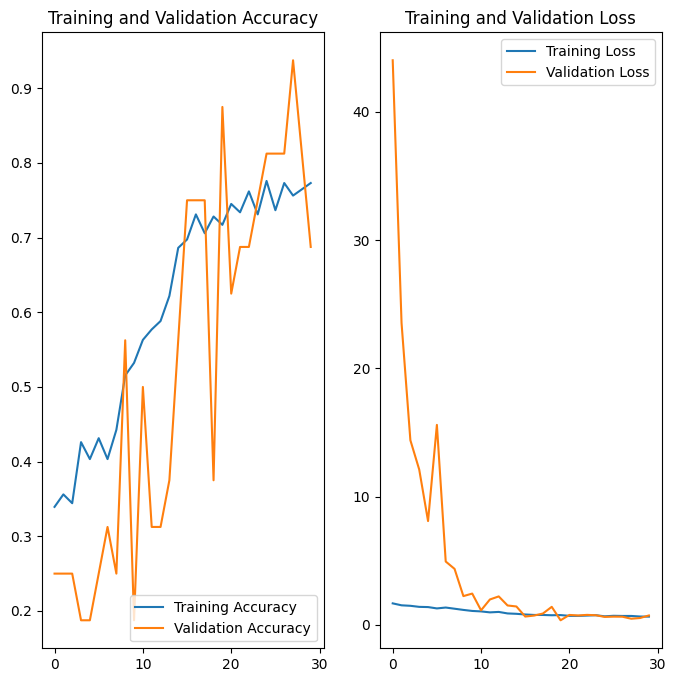

In [ ]:
# Evaluate models
print(model.evaluate_model())
# Plot history
model.plot_history()

In [ ]:
# Store history in the dictionary for future comparision
experiment_histories[model_name] = history
experiment_histories

{'model_experiment_2024-11-0218_20_07.442089/': <keras.src.callbacks.history.History at 0x7d11f4561c90>,
 'model_experiment_2024-11-0219_06_17.208860/': <keras.src.callbacks.history.History at 0x7d11e4cbd060>}

### Experiment 11 -
- image_height=100, # change - same as used in experiment 4
- image_width=100, # change - same as used in experiment 4
- num_of_frames=20, # same as used in experiment 4
- batch_size=32, # same as used in experiment 4
- num_epochs=50 # same as used in experiment 4
- More CNN Layers , and alternate MaxPoolLayers in Conv layers # change - major change in CNN architecture
- Optimizer = "SGD" # change - Adam to SGD
- More Dense Layers # change - extra Dense layer

In [ ]:
# Initialize the DataPreprocessor
preprocessor = DataPreprocessor(image_height=100, image_width=100, num_of_frames=20, batch_size=32, num_epochs=50)
# Set paths
preprocessor.set_paths(train_path=train_path, val_path=val_pathsssss)
# Call display_summary, which will compute and print all values
preprocessor.initializePreprocessData(total_frames=total_frames, generator=generator, train_doc=train_doc, val_doc=val_doc)

=== Data Preprocessing Summary ===
Image Height: 100
Image Width: 100
Frames per Video: 20
Batch Size: 32
Number of Epochs: 50
Training Path: Project_data/train
Validation Path: Project_data/val
Input Shape: (20, 100, 100, 3)
Frame Indices: [ 0  1  3  4  6  7  9 10 12 13 15 16 18 19 21 22 24 25 27 29]


In [ ]:
# Experiment configuration
experiment_config = {
    "conv_layers": [16, 16, 32, 32, 64, 64, 128, 128],
    "maxpool_layers":[0, 1, 0, 1, 0, 1, 0, 1],
    "kernel_size": (3, 3, 3),
    "dense_units": [256, 128, 64],
    "dropout_rate": [0.50, 0.40, 0.30]
}

# Optimizer configuration
optimizer_type = 'SGD'
optimizer_params =None

# Retrieve data generators and shapes
train_generator, val_generator = preprocessor.get_data_generators(generator, train_doc, val_doc)

# Model initialization
model = Conv3DBaseModel(preprocessor.input_shape, num_of_classes, optimizer_type=optimizer_type, optimizer_params=optimizer_params, model_name="model_experiment")

# Running the experiment
history,model_name=model.run_experiment(
    config=experiment_config,
    train_generator=preprocessor.train_generator,
    val_generator=preprocessor.val_generator,
    num_train_sequences=num_train_sequences,
    num_val_sequences=num_val_sequences,
    batch_size=preprocessor.batch_size,
    num_epochs=preprocessor.num_epochs
)


--- Running Experiment ---


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Directory model_experiment_2024-11-0219_06_17.208860/ is ready.


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv3D_1_16F (Conv3D)                │ (None, 20, 100, 100, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_1_16F               │ (None, 20, 100, 100, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_1_16F (Activation)       │ (None, 20, 100, 100, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_2_16F (Conv3D)                │ (None, 20, 100, 100, 16)    │           6,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_2_16F               │ (None, 20, 100, 100, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_2_16F (Activation)       │ (None, 20, 100, 100, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_2_16F (MaxPooling3D)  │ (None, 10, 50, 50, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_3_32F (Conv3D)                │ (None, 10, 50, 50, 32)      │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_3_32F               │ (None, 10, 50, 50, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_3_32F (Activation)       │ (None, 10, 50, 50, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_4_32F (Conv3D)                │ (None, 10, 50, 50, 32)      │          27,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_4_32F               │ (None, 10, 50, 50, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_4_32F (Activation)       │ (None, 10, 50, 50, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_4_32F (MaxPooling3D)  │ (None, 5, 25, 25, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_5_64F (Conv3D)                │ (None, 5, 25, 25, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_5_64F               │ (None, 5, 25, 25, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_5_64F (Activation)       │ (None, 5, 25, 25, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_6_64F (Conv3D)                │ (None, 5, 25, 25, 64)       │         110,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_6_64F               │ (None, 5, 25, 25, 64)       │             2

 Total params: 2,104,693 (8.03 MB)

 Trainable params: 2,102,837 (8.02 MB)

 Non-trainable params: 1,856 (7.25 KB)

None
Source path =  Project_data/train ; batch size = 32
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.3295 - loss: 1.7584Source path =  Project_data/val ; batch size = 32

Epoch 1: saving model to model_experiment_2024-11-0219_06_17.208860//model-01-44.02.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 123s 5s/step - categorical_accuracy: 0.3299 - loss: 1.7543 - val_categorical_accuracy: 0.2500 - val_loss: 44.0172 - learning_rate: 0.0010
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.3570 - loss: 1.5614
Epoch 2: saving model to model_experiment_2024-11-0219_06_17.208860//model-02-23.53.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - categorical_accuracy: 0.3570 - loss: 1.5594 - val_categorical_accuracy: 0.2500 - val_loss: 23.5265 - learning_rate: 0.0010
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.3429 - loss: 1.4813
Epoch 3: saving model to model_experiment_2024-11-0219_06_17.208860//model-03-14.39.keras
21/21 ━━━

(0.7759103775024414, 0.9375, 0.6330054402351379, 0.3492669463157654)


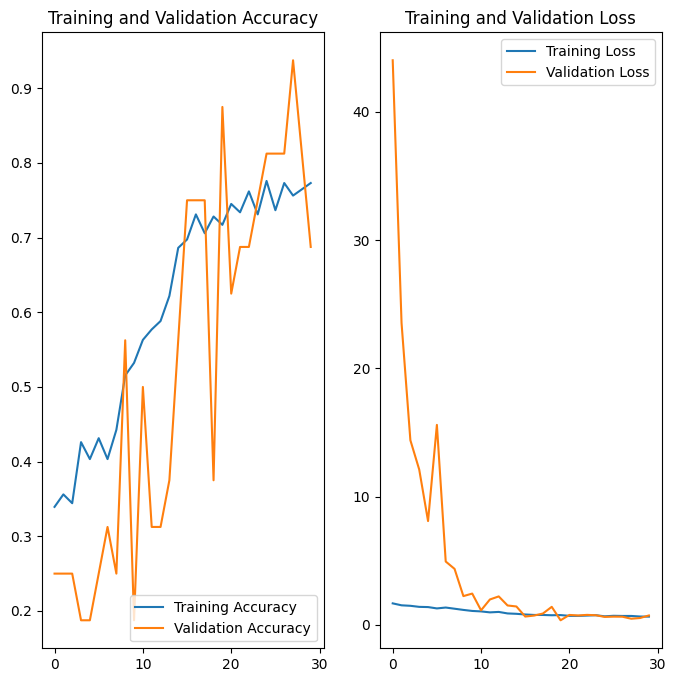

In [ ]:
# Evaluate models
print(model.evaluate_model())
# Plot history
model.plot_history()

In [ ]:
# Store history in the dictionary for future comparision
experiment_histories[model_name] = history
experiment_histories

{'model_experiment_2024-11-0218_20_07.442089/': <keras.src.callbacks.history.History at 0x7d11f4561c90>,
 'model_experiment_2024-11-0219_06_17.208860/': <keras.src.callbacks.history.History at 0x7d11e4cbd060>}

### Experiment 12 -
- image_height=100, # change - same as used in experiment 4
- image_width=100, # change - same as used in experiment 4
- num_of_frames=20, # same as used in experiment 9
- batch_size=32, # same as used in experiment 9
- num_epochs=50 # same as used in experiment 9
- More CNN Layers , and alternate MaxPoolLayers in Conv layers # same as used in experiment 9
- Optimizer = "Adam" # change - Adam to SGD
- More Dense Layers # same as used in experiment 9
- Learning Rate - 0.0005

In [ ]:
# Initialize the DataPreprocessor
preprocessor = DataPreprocessor(image_height=100, image_width=100, num_of_frames=20, batch_size=32, num_epochs=50)
# Set paths
preprocessor.set_paths(train_path=train_path, val_path=val_path)
# Call display_summary, which will compute and print all values
preprocessor.initializePreprocessData(total_frames=total_frames, generator=generator, train_doc=train_doc, val_doc=val_doc)

=== Data Preprocessing Summary ===
Image Height: 100
Image Width: 100
Frames per Video: 20
Batch Size: 32
Number of Epochs: 50
Training Path: Project_data/train
Validation Path: Project_data/val
Input Shape: (20, 100, 100, 3)
Frame Indices: [ 0  1  3  4  6  7  9 10 12 13 15 16 18 19 21 22 24 25 27 29]


In [ ]:
# Experiment configuration
experiment_config = {
    "conv_layers": [16, 16, 32, 32, 64, 64, 128, 128],
    "maxpool_layers":[0, 1, 0, 1, 0, 1, 0, 1],
    "kernel_size": (3, 3, 3),
    "dense_units": [256, 128, 64],
    "dropout_rate": [0.50, 0.40, 0.30]
}

# Optimizer configuration
optimizer_type = 'Adam'
optimizer_params ={'learning_rate': 0.0005, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-7}

# Retrieve data generators and shapes
train_generator, val_generator = preprocessor.get_data_generators(generator, train_doc, val_doc)

# Model initialization
model = Conv3DBaseModel(preprocessor.input_shape, num_of_classes, optimizer_type=optimizer_type, optimizer_params=optimizer_params, model_name="model_experiment")

# Running the experiment
history,model_name=model.run_experiment(
    config=experiment_config,
    train_generator=preprocessor.train_generator,
    val_generator=preprocessor.val_generator,
    num_train_sequences=num_train_sequences,
    num_val_sequences=num_val_sequences,
    batch_size=preprocessor.batch_size,
    num_epochs=preprocessor.num_epochs
)


--- Running Experiment ---
Directory model_experiment_2024-11-0221_00_23.560868/ is ready.


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv3D_1_16F (Conv3D)                │ (None, 20, 100, 100, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_1_16F               │ (None, 20, 100, 100, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_1_16F (Activation)       │ (None, 20, 100, 100, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_2_16F (Conv3D)                │ (None, 20, 100, 100, 16)    │           6,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_2_16F               │ (None, 20, 100, 100, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_2_16F (Activation)       │ (None, 20, 100, 100, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_2_16F (MaxPooling3D)  │ (None, 10, 50, 50, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_3_32F (Conv3D)                │ (None, 10, 50, 50, 32)      │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_3_32F               │ (None, 10, 50, 50, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_3_32F (Activation)       │ (None, 10, 50, 50, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_4_32F (Conv3D)                │ (None, 10, 50, 50, 32)      │          27,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_4_32F               │ (None, 10, 50, 50, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_4_32F (Activation)       │ (None, 10, 50, 50, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_4_32F (MaxPooling3D)  │ (None, 5, 25, 25, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_5_64F (Conv3D)                │ (None, 5, 25, 25, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_5_64F               │ (None, 5, 25, 25, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_5_64F (Activation)       │ (None, 5, 25, 25, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_6_64F (Conv3D)                │ (None, 5, 25, 25, 64)       │         110,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_6_64F               │ (None, 5, 25, 25, 64)       │             2

 Total params: 2,104,693 (8.03 MB)

 Trainable params: 2,102,837 (8.02 MB)

 Non-trainable params: 1,856 (7.25 KB)

None
Source path =  Project_data/train ; batch size = 32
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.2796 - loss: 1.8798Source path =  Project_data/val ; batch size = 32

Epoch 1: saving model to model_experiment_2024-11-0221_00_23.560868//model-01-7.64.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 120s 5s/step - categorical_accuracy: 0.2793 - loss: 1.8746 - val_categorical_accuracy: 0.2200 - val_loss: 7.6403 - learning_rate: 5.0000e-04
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.3699 - loss: 1.4726
Epoch 2: saving model to model_experiment_2024-11-0221_00_23.560868//model-02-1.81.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - categorical_accuracy: 0.3706 - loss: 1.4727 - val_categorical_accuracy: 0.2500 - val_loss: 1.8079 - learning_rate: 5.0000e-04
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.3982 - loss: 1.4099
Epoch 3: saving model to model_experiment_2024-11-0221_00_23.560868//model-03-1.40.keras
21/21 

(0.7310924530029297, 0.8125, 0.7514426112174988, 0.4913274049758911)


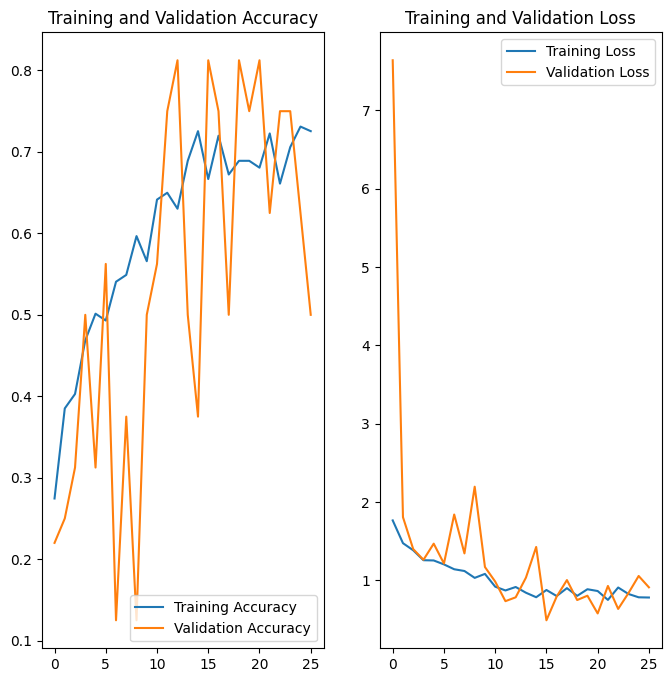

In [ ]:
# Evaluate models
print(model.evaluate_model())
# Plot history
model.plot_history()

In [ ]:
# Store history in the dictionary for future comparision
experiment_histories[model_name] = history
experiment_histories

{'model_experiment_2024-11-0220_21_34.233813/': <keras.src.callbacks.history.History at 0x7a4924abeda0>,
 'model_experiment_2024-11-0221_00_23.560868/': <keras.src.callbacks.history.History at 0x7a485828ada0>}

## Approach 2 : Conv2D + RNN Models
Will start with this basic configuration

- Number of frames: 20
- Batch size: 32
- Image resolution: 100 x 100
- Number of epoch : 50
- Optimizer : SGD
- CNN and LSTM layers

### Experiment 1 -
- image_height=100,
- image_width=100,
- num_of_frames=20,
- batch_size=32,
- num_epochs=50,
- Optimizer = SGD
- 4 Conv2D , MaxPooling layers
- 2 Dense layers with usual dropouts
- LSTM : 128 rnn units

In [ ]:
# Initialize the DataPreprocessor
preprocessor = DataPreprocessor(image_height=100, image_width=100, num_of_frames=20, batch_size=32, num_epochs=50)
# Set paths
preprocessor.set_paths(train_path=train_path, val_path=val_path)
# Call display_summary, which will compute and print all values
preprocessor.initializePreprocessData(total_frames=total_frames, generator=generator, train_doc=train_doc, val_doc=val_doc)

=== Data Preprocessing Summary ===
Image Height: 100
Image Width: 100
Frames per Video: 20
Batch Size: 32
Number of Epochs: 50
Training Path: Project_data/train
Validation Path: Project_data/val
Input Shape: (20, 100, 100, 3)
Frame Indices: [ 0  1  3  4  6  7  9 10 12 13 15 16 18 19 21 22 24 25 27 29]


In [ ]:
# Experiment configuration
experiment_config = {
    "conv_layers": [16, 32, 64, 128],
    "maxpool_layers":[1, 1, 1, 1],
    "kernel_size": (3, 3),
    "rnn_units": 128,
    "dense_units": [128, 64],
    "dropout_rate": [0.50, 0.25]
}

# Optimizer configuration
optimizer_type = 'SGD'
optimizer_params =None

# RNN type
rnn_type = 'LSTM'

# Retrieve data generators and shapes
train_generator, val_generator = preprocessor.get_data_generators(generator, train_doc, val_doc)

# Model initialization
model = RNNCNNModel(preprocessor.input_shape, num_of_classes, rnn_type=rnn_type, optimizer_type=optimizer_type, optimizer_params=optimizer_params, model_name="model_experiment")

# Running the experiment
history,model_name=model.run_experiment(
    config=experiment_config,
    train_generator=preprocessor.train_generator,
    val_generator=preprocessor.val_generator,
    num_train_sequences=num_train_sequences,
    num_val_sequences=num_val_sequences,
    batch_size=preprocessor.batch_size,
    num_epochs=preprocessor.num_epochs
)



--- Running Experiment ---
Directory model_experiment_2024-11-0307_52_15.225662/ is ready.


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv2D_1_16F (TimeDistributed)       │ (None, 20, 100, 100, 16)    │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv2D_1_16F               │ (None, 20, 100, 100, 16)    │              64 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv2D_1_16F (TimeDistributed)  │ (None, 20, 100, 100, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv2D_1_16F                 │ (None, 20, 50, 50, 16)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_2_32F (TimeDistributed)       │ (None, 20, 50, 50, 32)      │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv2D_2_32F               │ (None, 20, 50, 50, 32)      │             128 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv2D_2_32F (TimeDistributed)  │ (None, 20, 50, 50, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv2D_2_32F                 │ (None, 20, 25, 25, 32)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_3_64F (TimeDistributed)       │ (None, 20, 25, 25, 64)      │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv2D_3_64F               │ (None, 20, 25, 25, 64)      │             256 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv2D_3_64F (TimeDistributed)  │ (None, 20, 25, 25, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv2D_3_64F                 │ (None, 20, 12, 12, 64)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_4_128F (TimeDistributed)      │ (None, 20, 12, 12, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv2D_4_128F              │ (None, 20, 12, 12, 128)     │             512 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv2D_4_128F (TimeDistributed) │ (None, 20, 12, 12, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv2D_4_128F                │ (None, 20, 6, 6, 128)       │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten_Layer (TimeDistributed)      │ (None, 20, 4608)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,311,589 (5.00 MB)

 Trainable params: 1,311,109 (5.00 MB)

 Non-trainable params: 480 (1.88 KB)

None
Source path =  Project_data/train ; batch size = 32
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.2129 - loss: 1.6639Source path =  Project_data/val ; batch size = 32

Epoch 1: saving model to model_experiment_2024-11-0307_52_15.225662//model-01-1.62.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 156s 6s/step - categorical_accuracy: 0.2130 - loss: 1.6629 - val_categorical_accuracy: 0.2300 - val_loss: 1.6152 - learning_rate: 0.0010
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.2168 - loss: 1.6334
Epoch 2: saving model to model_experiment_2024-11-0307_52_15.225662//model-02-1.62.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 84s 4s/step - categorical_accuracy: 0.2166 - loss: 1.6329 - val_categorical_accuracy: 0.2500 - val_loss: 1.6163 - learning_rate: 0.0010
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.2366 - loss: 1.5764
Epoch 3: saving model to model_experiment_2024-11-0307_52_15.225662//model-03-1.55.keras
21/21 ━━━━━━━━

(0.518207311630249, 0.75, 1.23501455783844, 1.0346825122833252)


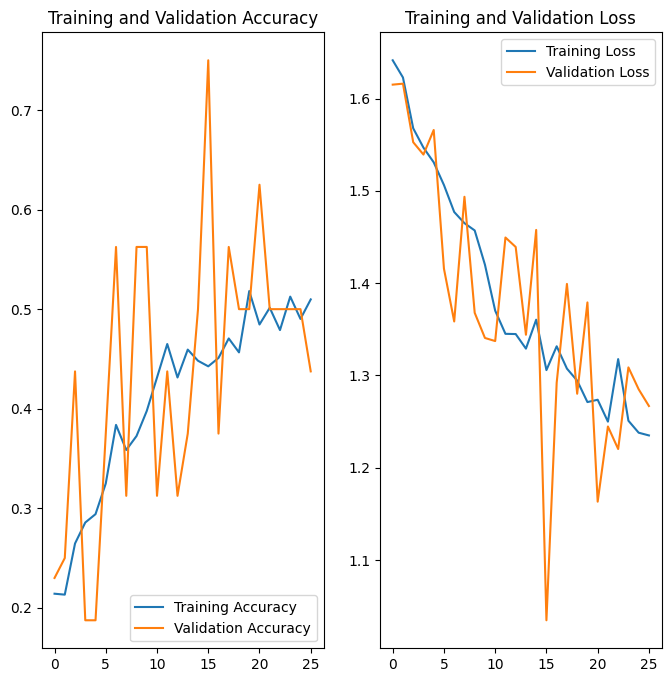

In [ ]:
# Evaluate models
print(model.evaluate_model())
# Plot history
model.plot_history()

In [ ]:
# Store history in the dictionary for future comparision
experiment_histories[model_name] = history
experiment_histories

### Experiment 2 -
- image_height=100,
- image_width=100,
- num_of_frames=20,
- batch_size=32,
- num_epochs=50,
- Optimizer = SGD
- 4 Conv2D , MaxPooling layers
- 1 LSTM cell : 128 rnn units
- 1 Dense layer with usual dropout

In [ ]:
# Initialize the DataPreprocessor
preprocessor = DataPreprocessor(image_height=100, image_width=100, num_of_frames=20, batch_size=32, num_epochs=50)
# Set paths
preprocessor.set_paths(train_path=train_path, val_path=val_path)
# Call display_summary, which will compute and print all values
preprocessor.initializePreprocessData(total_frames=total_frames, generator=generator, train_doc=train_doc, val_doc=val_doc)

=== Data Preprocessing Summary ===
Image Height: 100
Image Width: 100
Frames per Video: 20
Batch Size: 32
Number of Epochs: 50
Training Path: Project_data/train
Validation Path: Project_data/val
Input Shape: (20, 100, 100, 3)
Frame Indices: [ 0  1  3  4  6  7  9 10 12 13 15 16 18 19 21 22 24 25 27 29]


In [ ]:
# Experiment configuration
experiment_config = {
    "conv_layers": [16, 32, 64, 128],
    "maxpool_layers":[1, 1, 1, 1],
    "kernel_size": (3, 3),
    "rnn_units": 128,
    "dense_units": [64],
    "dropout_rate": [0.50]
}

# Optimizer configuration
optimizer_type = 'SGD'
optimizer_params =None

# RNN type
rnn_type = 'LSTM'

# Retrieve data generators and shapes
train_generator, val_generator = preprocessor.get_data_generators(generator, train_doc, val_doc)

# Model initialization
model = RNNCNNModel(preprocessor.input_shape, num_of_classes, rnn_type=rnn_type, optimizer_type=optimizer_type, optimizer_params=optimizer_params, model_name="model_experiment")

# Running the experiment
history,model_name=model.run_experiment(
    config=experiment_config,
    train_generator=preprocessor.train_generator,
    val_generator=preprocessor.val_generator,
    num_train_sequences=num_train_sequences,
    num_val_sequences=num_val_sequences,
    batch_size=preprocessor.batch_size,
    num_epochs=preprocessor.num_epochs
)



--- Running Experiment ---
Directory model_experiment_2024-11-0308_28_20.811397/ is ready.


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv2D_1_16F (TimeDistributed)       │ (None, 20, 100, 100, 16)    │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv2D_1_16F               │ (None, 20, 100, 100, 16)    │              64 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv2D_1_16F (TimeDistributed)  │ (None, 20, 100, 100, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv2D_1_16F                 │ (None, 20, 50, 50, 16)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_2_32F (TimeDistributed)       │ (None, 20, 50, 50, 32)      │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv2D_2_32F               │ (None, 20, 50, 50, 32)      │             128 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv2D_2_32F (TimeDistributed)  │ (None, 20, 50, 50, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv2D_2_32F                 │ (None, 20, 25, 25, 32)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_3_64F (TimeDistributed)       │ (None, 20, 25, 25, 64)      │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv2D_3_64F               │ (None, 20, 25, 25, 64)      │             256 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv2D_3_64F (TimeDistributed)  │ (None, 20, 25, 25, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv2D_3_64F                 │ (None, 20, 12, 12, 64)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_4_128F (TimeDistributed)      │ (None, 20, 12, 12, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv2D_4_128F              │ (None, 20, 12, 12, 128)     │             512 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv2D_4_128F (TimeDistributed) │ (None, 20, 12, 12, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv2D_4_128F                │ (None, 20, 6, 6, 128)       │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten_Layer (TimeDistributed)      │ (None, 20, 4608)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,299,173 (4.96 MB)

 Trainable params: 1,298,693 (4.95 MB)

 Non-trainable params: 480 (1.88 KB)

None
Source path =  Project_data/train ; batch size = 32
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.2060 - loss: 1.6227Source path =  Project_data/val ; batch size = 32

Epoch 1: saving model to model_experiment_2024-11-0308_28_20.811397//model-01-1.51.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 149s 6s/step - categorical_accuracy: 0.2069 - loss: 1.6214 - val_categorical_accuracy: 0.3100 - val_loss: 1.5063 - learning_rate: 0.0010
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.3082 - loss: 1.5209
Epoch 2: saving model to model_experiment_2024-11-0308_28_20.811397//model-02-1.41.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - categorical_accuracy: 0.3105 - loss: 1.5193 - val_categorical_accuracy: 0.4375 - val_loss: 1.4118 - learning_rate: 0.0010
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.4013 - loss: 1.3962
Epoch 3: saving model to model_experiment_2024-11-0308_28_20.811397//model-03-1.28.keras
21/21 ━━━━━━━━

(0.7198879718780518, 0.8125, 0.8737373948097229, 0.8813190460205078)


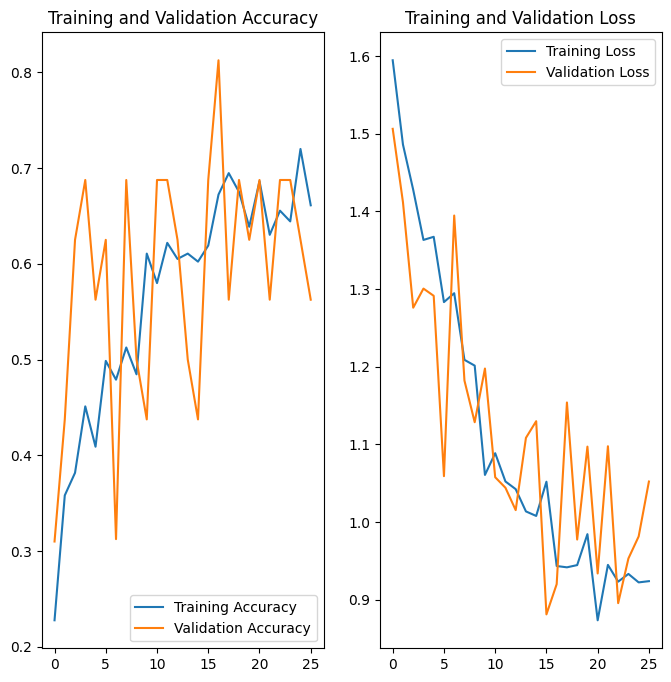

In [ ]:
# Evaluate models
print(model.evaluate_model())
# Plot history
model.plot_history()

In [ ]:
# Store history in the dictionary for future comparision
experiment_histories[model_name] = history
experiment_histories

{'model_experiment_2024-11-0308_28_20.811397/': <keras.src.callbacks.history.History at 0x7b076ed6e500>}

### Experiment 3 -
- image_height=100,
- image_width=100,
- num_of_frames=20,
- batch_size=32,
- num_epochs=50,
- Optimizer = Adam
- 4 Conv2D , MaxPooling layers
- 1 LSTM cell : 128 rnn units
- 1 Dense layer with usual dropout

In [ ]:
# Initialize the DataPreprocessor
preprocessor = DataPreprocessor(image_height=100, image_width=100, num_of_frames=20, batch_size=32, num_epochs=50)
# Set paths
preprocessor.set_paths(train_path=train_path, val_path=val_path)
# Call display_summary, which will compute and print all values
preprocessor.initializePreprocessData(total_frames=total_frames, generator=generator, train_doc=train_doc, val_doc=val_doc)

=== Data Preprocessing Summary ===
Image Height: 100
Image Width: 100
Frames per Video: 20
Batch Size: 32
Number of Epochs: 50
Training Path: Project_data/train
Validation Path: Project_data/val
Input Shape: (20, 100, 100, 3)
Frame Indices: [ 0  1  3  4  6  7  9 10 12 13 15 16 18 19 21 22 24 25 27 29]


In [ ]:
# Experiment configuration
experiment_config = {
    "conv_layers": [16, 32, 64, 128],
    "maxpool_layers":[1, 1, 1, 1],
    "kernel_size": (3, 3),
    "rnn_units": 128,
    "dense_units": [64],
    "dropout_rate": [0.50]
}

# Optimizer configuration
optimizer_type = 'Adam'
optimizer_params =None

# RNN type
rnn_type = 'LSTM'

# Retrieve data generators and shapes
train_generator, val_generator = preprocessor.get_data_generators(generator, train_doc, val_doc)

# Model initialization
model = RNNCNNModel(preprocessor.input_shape, num_of_classes, rnn_type=rnn_type, optimizer_type=optimizer_type, optimizer_params=optimizer_params, model_name="model_experiment")

# Running the experiment
history,model_name=model.run_experiment(
    config=experiment_config,
    train_generator=preprocessor.train_generator,
    val_generator=preprocessor.val_generator,
    num_train_sequences=num_train_sequences,
    num_val_sequences=num_val_sequences,
    batch_size=preprocessor.batch_size,
    num_epochs=preprocessor.num_epochs
)



--- Running Experiment ---


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Directory model_experiment_2024-11-0309_26_03.369247/ is ready.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv2D_1_16F (TimeDistributed)       │ (None, 20, 100, 100, 16)    │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv2D_1_16F               │ (None, 20, 100, 100, 16)    │              64 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv2D_1_16F (TimeDistributed)  │ (None, 20, 100, 100, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv2D_1_16F                 │ (None, 20, 50, 50, 16)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_2_32F (TimeDistributed)       │ (None, 20, 50, 50, 32)      │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv2D_2_32F               │ (None, 20, 50, 50, 32)      │             128 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv2D_2_32F (TimeDistributed)  │ (None, 20, 50, 50, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv2D_2_32F                 │ (None, 20, 25, 25, 32)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_3_64F (TimeDistributed)       │ (None, 20, 25, 25, 64)      │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv2D_3_64F               │ (None, 20, 25, 25, 64)      │             256 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv2D_3_64F (TimeDistributed)  │ (None, 20, 25, 25, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv2D_3_64F                 │ (None, 20, 12, 12, 64)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_4_128F (TimeDistributed)      │ (None, 20, 12, 12, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv2D_4_128F              │ (None, 20, 12, 12, 128)     │             512 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv2D_4_128F (TimeDistributed) │ (None, 20, 12, 12, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv2D_4_128F                │ (None, 20, 6, 6, 128)       │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten_Layer (TimeDistributed)      │ (None, 20, 4608)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,299,173 (4.96 MB)

 Trainable params: 1,298,693 (4.95 MB)

 Non-trainable params: 480 (1.88 KB)

None
Source path =  Project_data/train ; batch size = 32
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.1986 - loss: 1.6756Source path =  Project_data/val ; batch size = 32

Epoch 1: saving model to model_experiment_2024-11-0309_26_03.369247//model-01-1.53.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 157s 6s/step - categorical_accuracy: 0.1984 - loss: 1.6741 - val_categorical_accuracy: 0.2500 - val_loss: 1.5279 - learning_rate: 0.0010
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.2929 - loss: 1.5512
Epoch 2: saving model to model_experiment_2024-11-0309_26_03.369247//model-02-1.46.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - categorical_accuracy: 0.2912 - loss: 1.5520 - val_categorical_accuracy: 0.5000 - val_loss: 1.4601 - learning_rate: 0.0010
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.3624 - loss: 1.5071
Epoch 3: saving model to model_experiment_2024-11-0309_26_03.369247//model-03-1.37.keras
21/21 ━━━━━━━━

(0.7450980544090271, 0.8125, 0.812762975692749, 0.680497407913208)


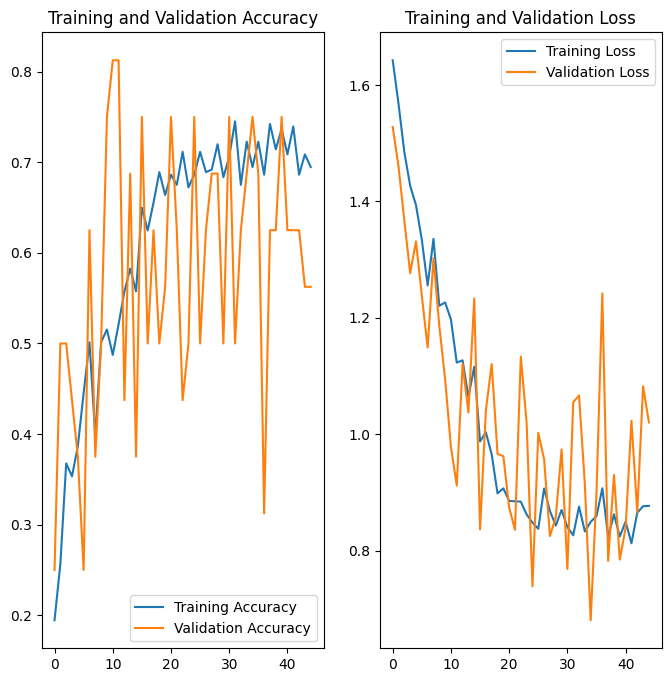

In [ ]:
# Evaluate models
print(model.evaluate_model())
# Plot history
model.plot_history()

In [ ]:
# Store history in the dictionary for future comparision
experiment_histories[model_name] = history
experiment_histories

{'model_experiment_2024-11-0309_26_03.369247/': <keras.src.callbacks.history.History at 0x7b9880197a60>}

### Experiment 4 -
- image_height=100,
- image_width=100,
- num_of_frames=20,
- batch_size=32,
- num_epochs=30,
- Optimizer = Adam
- 4 Conv2D , MaxPooling layers
- 1 LSTM cell : 128 rnn units
- 1 Dense layer with usual dropout

In [ ]:
# Initialize the DataPreprocessor
preprocessor = DataPreprocessor(image_height=100, image_width=100, num_of_frames=20, batch_size=32, num_epochs=30)
# Set paths
preprocessor.set_paths(train_path=train_path, val_path=val_path)
# Call display_summary, which will compute and print all values
preprocessor.initializePreprocessData(total_frames=total_frames, generator=generator, train_doc=train_doc, val_doc=val_doc)

=== Data Preprocessing Summary ===
Image Height: 100
Image Width: 100
Frames per Video: 20
Batch Size: 32
Number of Epochs: 30
Training Path: Project_data/train
Validation Path: Project_data/val
Input Shape: (20, 100, 100, 3)
Frame Indices: [ 0  1  3  4  6  7  9 10 12 13 15 16 18 19 21 22 24 25 27 29]


In [ ]:
# Experiment configuration
experiment_config = {
    "conv_layers": [16, 32, 64, 128],
    "maxpool_layers":[1, 1, 1, 1],
    "kernel_size": (3, 3),
    "rnn_units": 128,
    "dense_units": [64],
    "dropout_rate": [0.50]
}

# Optimizer configuration
optimizer_type = 'Adam'
optimizer_params =None

# RNN type
rnn_type = 'LSTM'

# Retrieve data generators and shapes
train_generator, val_generator = preprocessor.get_data_generators(generator, train_doc, val_doc)

# Model initialization
model = RNNCNNModel(preprocessor.input_shape, num_of_classes, rnn_type=rnn_type, optimizer_type=optimizer_type, optimizer_params=optimizer_params, model_name="model_experiment")

# Running the experiment
history,model_name=model.run_experiment(
    config=experiment_config,
    train_generator=preprocessor.train_generator,
    val_generator=preprocessor.val_generator,
    num_train_sequences=num_train_sequences,
    num_val_sequences=num_val_sequences,
    batch_size=preprocessor.batch_size,
    num_epochs=preprocessor.num_epochs
)



--- Running Experiment ---
Directory model_experiment_2024-11-0310_17_15.091678/ is ready.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv2D_1_16F (TimeDistributed)       │ (None, 20, 100, 100, 16)    │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv2D_1_16F               │ (None, 20, 100, 100, 16)    │              64 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv2D_1_16F (TimeDistributed)  │ (None, 20, 100, 100, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv2D_1_16F                 │ (None, 20, 50, 50, 16)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_2_32F (TimeDistributed)       │ (None, 20, 50, 50, 32)      │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv2D_2_32F               │ (None, 20, 50, 50, 32)      │             128 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv2D_2_32F (TimeDistributed)  │ (None, 20, 50, 50, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv2D_2_32F                 │ (None, 20, 25, 25, 32)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_3_64F (TimeDistributed)       │ (None, 20, 25, 25, 64)      │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv2D_3_64F               │ (None, 20, 25, 25, 64)      │             256 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv2D_3_64F (TimeDistributed)  │ (None, 20, 25, 25, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv2D_3_64F                 │ (None, 20, 12, 12, 64)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_4_128F (TimeDistributed)      │ (None, 20, 12, 12, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv2D_4_128F              │ (None, 20, 12, 12, 128)     │             512 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv2D_4_128F (TimeDistributed) │ (None, 20, 12, 12, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv2D_4_128F                │ (None, 20, 6, 6, 128)       │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten_Layer (TimeDistributed)      │ (None, 20, 4608)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,299,173 (4.96 MB)

 Trainable params: 1,298,693 (4.95 MB)

 Non-trainable params: 480 (1.88 KB)

None
Source path =  Project_data/train ; batch size = 32
Epoch 1/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.2664 - loss: 1.6367Source path =  Project_data/val ; batch size = 32

Epoch 1: saving model to model_experiment_2024-11-0310_17_15.091678//model-01-1.43.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 156s 6s/step - categorical_accuracy: 0.2673 - loss: 1.6338 - val_categorical_accuracy: 0.4200 - val_loss: 1.4312 - learning_rate: 0.0010
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.4140 - loss: 1.4108
Epoch 2: saving model to model_experiment_2024-11-0310_17_15.091678//model-02-1.36.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - categorical_accuracy: 0.4128 - loss: 1.4101 - val_categorical_accuracy: 0.3750 - val_loss: 1.3617 - learning_rate: 0.0010
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.4469 - loss: 1.3386
Epoch 3: saving model to model_experiment_2024-11-0310_17_15.091678//model-03-1.13.keras
21/21 ━━━━━━━━

(0.8263305425643921, 0.875, 0.6260629296302795, 0.5606642961502075)


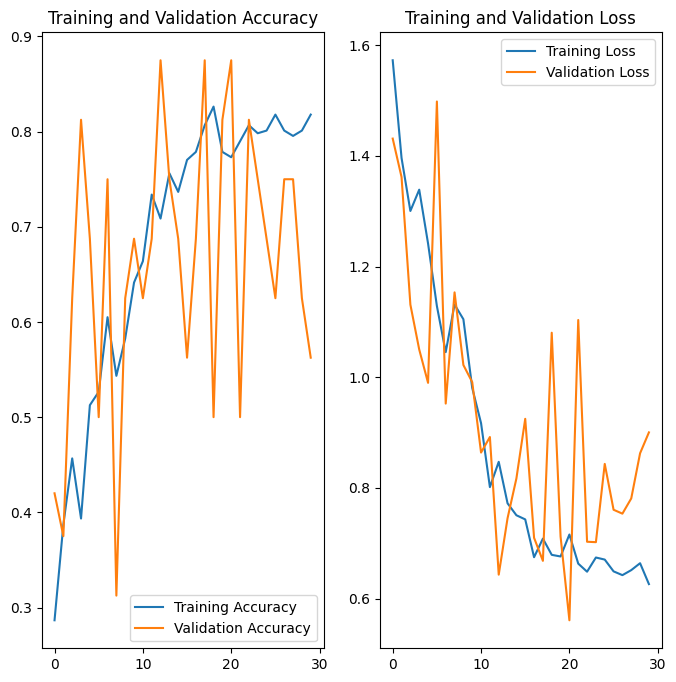

In [ ]:
# Evaluate models
print(model.evaluate_model())
# Plot history
model.plot_history()

In [ ]:
# Store history in the dictionary for future comparision
experiment_histories[model_name] = history
experiment_histories

{'model_experiment_2024-11-0309_26_03.369247/': <keras.src.callbacks.history.History at 0x7b9880197a60>,
 'model_experiment_2024-11-0310_17_15.091678/': <keras.src.callbacks.history.History at 0x7b97f8da84f0>}

### Experiment 5 -
- image_height=100,
- image_width=100,
- num_of_frames=20,
- batch_size=32,
- num_epochs=30,
- Optimizer = Adam
- 4 Conv2D , MaxPooling layers
- 1 GRU cell : 128 rnn units
- 1 Dense layer with usual dropout

In [ ]:
# Initialize the DataPreprocessor
preprocessor = DataPreprocessor(image_height=100, image_width=100, num_of_frames=20, batch_size=32, num_epochs=30)
# Set paths
preprocessor.set_paths(train_path=train_path, val_path=val_path)
# Call display_summary, which will compute and print all values
preprocessor.initializePreprocessData(total_frames=total_frames, generator=generator, train_doc=train_doc, val_doc=val_doc)

=== Data Preprocessing Summary ===
Image Height: 100
Image Width: 100
Frames per Video: 20
Batch Size: 32
Number of Epochs: 30
Training Path: Project_data/train
Validation Path: Project_data/val
Input Shape: (20, 100, 100, 3)
Frame Indices: [ 0  1  3  4  6  7  9 10 12 13 15 16 18 19 21 22 24 25 27 29]


In [ ]:
# Experiment configuration
experiment_config = {
    "conv_layers": [16, 32, 64, 128],
    "maxpool_layers":[1, 1, 1, 1],
    "kernel_size": (3, 3),
    "rnn_units": 128,
    "dense_units": [64],
    "dropout_rate": [0.50]
}

# Optimizer configuration
optimizer_type = 'Adam'
optimizer_params =None

# RNN type
rnn_type = 'GRU'

# Retrieve data generators and shapes
train_generator, val_generator = preprocessor.get_data_generators(generator, train_doc, val_doc)

# Model initialization
model = RNNCNNModel(preprocessor.input_shape, num_of_classes, rnn_type=rnn_type, optimizer_type=optimizer_type, optimizer_params=optimizer_params, model_name="model_experiment")

# Running the experiment
history,model_name=model.run_experiment(
    config=experiment_config,
    train_generator=preprocessor.train_generator,
    val_generator=preprocessor.val_generator,
    num_train_sequences=num_train_sequences,
    num_val_sequences=num_val_sequences,
    batch_size=preprocessor.batch_size,
    num_epochs=preprocessor.num_epochs
)



--- Running Experiment ---
Directory model_experiment_2024-11-0310_55_05.791082/ is ready.


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv2D_1_16F (TimeDistributed)       │ (None, 20, 100, 100, 16)    │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv2D_1_16F               │ (None, 20, 100, 100, 16)    │              64 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv2D_1_16F (TimeDistributed)  │ (None, 20, 100, 100, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv2D_1_16F                 │ (None, 20, 50, 50, 16)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_2_32F (TimeDistributed)       │ (None, 20, 50, 50, 32)      │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv2D_2_32F               │ (None, 20, 50, 50, 32)      │             128 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv2D_2_32F (TimeDistributed)  │ (None, 20, 50, 50, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv2D_2_32F                 │ (None, 20, 25, 25, 32)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_3_64F (TimeDistributed)       │ (None, 20, 25, 25, 64)      │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv2D_3_64F               │ (None, 20, 25, 25, 64)      │             256 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv2D_3_64F (TimeDistributed)  │ (None, 20, 25, 25, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv2D_3_64F                 │ (None, 20, 12, 12, 64)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_4_128F (TimeDistributed)      │ (None, 20, 12, 12, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv2D_4_128F              │ (None, 20, 12, 12, 128)     │             512 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv2D_4_128F (TimeDistributed) │ (None, 20, 12, 12, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv2D_4_128F                │ (None, 20, 6, 6, 128)       │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten_Layer (TimeDistributed)      │ (None, 20, 4608)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,000,293 (3.82 MB)

 Trainable params: 999,813 (3.81 MB)

 Non-trainable params: 480 (1.88 KB)

None
Source path =  Project_data/train ; batch size = 32
Epoch 1/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.2388 - loss: 1.7852Source path =  Project_data/val ; batch size = 32

Epoch 1: saving model to model_experiment_2024-11-0310_55_05.791082//model-01-1.39.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 153s 6s/step - categorical_accuracy: 0.2387 - loss: 1.7802 - val_categorical_accuracy: 0.6100 - val_loss: 1.3926 - learning_rate: 0.0010
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.4266 - loss: 1.4215
Epoch 2: saving model to model_experiment_2024-11-0310_55_05.791082//model-02-1.32.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - categorical_accuracy: 0.4263 - loss: 1.4209 - val_categorical_accuracy: 0.5625 - val_loss: 1.3169 - learning_rate: 0.0010
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.4009 - loss: 1.3804
Epoch 3: saving model to model_experiment_2024-11-0310_55_05.791082//model-03-1.13.keras
21/21 ━━━━━━━━

(0.7198879718780518, 0.8125, 0.8708227872848511, 0.8518065214157104)


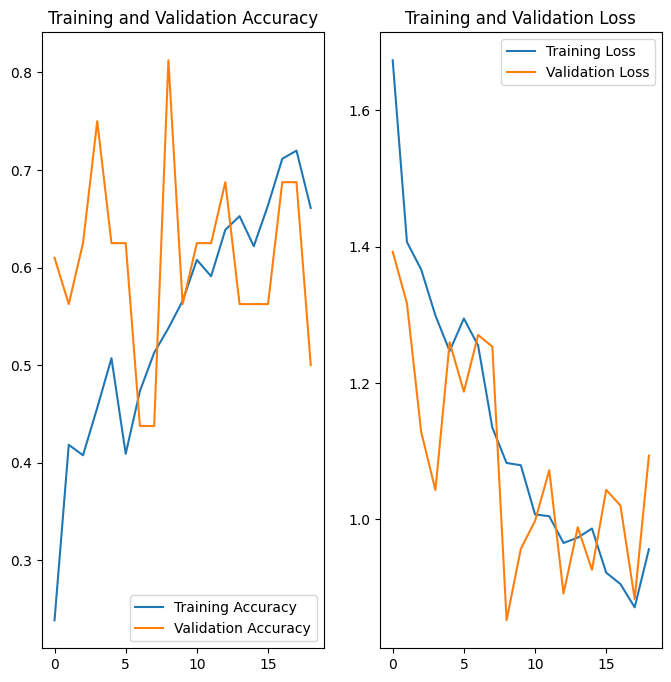

In [ ]:
# Evaluate models
print(model.evaluate_model())
# Plot history
model.plot_history()

In [ ]:
# Store history in the dictionary for future comparision
experiment_histories[model_name] = history
experiment_histories

{'model_experiment_2024-11-0309_26_03.369247/': <keras.src.callbacks.history.History at 0x7b9880197a60>,
 'model_experiment_2024-11-0310_17_15.091678/': <keras.src.callbacks.history.History at 0x7b97f8da84f0>,
 'model_experiment_2024-11-0310_55_05.791082/': <keras.src.callbacks.history.History at 0x7b96946d0df0>}

## Approach 3 - Transfer Learning in Conv2D + RNN Models

### Experiment 1 -
- image_height=128, # change - adjusted for VGGNet16
- image_width=128, # change - adjusted for VGGNet16
- num_of_frames=16, # change - adjusted for VGGNet16
- batch_size=32,
- num_epochs=30,
- Optimizer = Adam
- 1 LSTM cell : 128 rnn units
- 1 Dense layer : 64 neurons with usual dropout
- Transfer Learning from VGGNet16
- Global Average Pooling to reduce feature size and training time

In [ ]:
# Initialize the DataPreprocessor
preprocessor = DataPreprocessor(image_height=128, image_width=128, num_of_frames=16, batch_size=32, num_epochs=30)
# Set paths
preprocessor.set_paths(train_path=train_path, val_path=val_path)
# Call display_summary, which will compute and print all values
preprocessor.initializePreprocessData(total_frames=total_frames, generator=generator, train_doc=train_doc, val_doc=val_doc)

=== Data Preprocessing Summary ===
Image Height: 128
Image Width: 128
Frames per Video: 16
Batch Size: 32
Number of Epochs: 30
Training Path: Project_data/train
Validation Path: Project_data/val
Input Shape: (16, 128, 128, 3)
Frame Indices: [ 0  1  3  5  7  9 11 13 15 17 19 21 23 25 27 29]


In [ ]:
# Experiment configuration
experiment_config = {
    "rnn_units": [128],
    "rnn_dropout_rate": [0],
    "dense_units": [64],
    "dropout_rate": [0.50]
}

# Optimizer configuration
optimizer_type = 'Adam'
optimizer_params =None

# RNN type
rnn_type = 'LSTM'

# Retrieve data generators and shapes
train_generator, val_generator = preprocessor.get_data_generators(generator, train_doc, val_doc)

# Model initialization
model = RNNCNN_ImageNet(preprocessor.input_shape, num_of_classes, rnn_type=rnn_type, imagenet_type='VGG16', imagenet_trainable_layers=0, optimizer_type=optimizer_type, optimizer_params=optimizer_params, model_name="model_experiment")

# Running the experiment
history,model_name=model.run_experiment(
    config=experiment_config,
    train_generator=preprocessor.train_generator,
    val_generator=preprocessor.val_generator,
    num_train_sequences=num_train_sequences,
    num_val_sequences=num_val_sequences,
    batch_size=preprocessor.batch_size,
    num_epochs=preprocessor.num_epochs
)


--- Running Experiment ---
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Directory model_experiment_2024-11-0408_54_22.340367/ is ready.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ VGG16_Feature_Extractor              │ (None, 16, 4, 4, 512)       │      14,714,688 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Global_Average_Pooling_Layer         │ (None, 16, 512)             │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ LSTM_1_128_Units (LSTM)              │ (None, 128)                 │         328,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_1_64N (Dense)                  │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1_50_percent (Dropout)       │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (Dense)                 │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,051,461 (57.42 MB)

 Trainable params: 336,773 (1.28 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Source path =  Project_data/train ; batch size = 32
Epoch 1/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.2539 - loss: 1.6652Source path =  Project_data/val ; batch size = 32

Epoch 1: saving model to model_experiment_2024-11-0408_54_22.340367//model-01-1.45.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 114s 5s/step - categorical_accuracy: 0.2552 - loss: 1.6626 - val_categorical_accuracy: 0.4800 - val_loss: 1.4549 - learning_rate: 0.0010
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.4015 - loss: 1.4307
Epoch 2: saving model to model_experiment_2024-11-0408_54_22.340367//model-02-1.40.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - categorical_accuracy: 0.4027 - loss: 1.4276 - val_categorical_accuracy: 0.4375 - val_loss: 1.3971 - learning_rate: 0.0010
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.5656 - loss: 1.1671
Epoch 3: saving model to model_experiment_2024-11-0408_54_22.340367//model-03-1.12.keras
21/21 ━━━━━━━━

(0.9523809552192688, 0.9375, 0.24994143843650818, 0.24210402369499207)


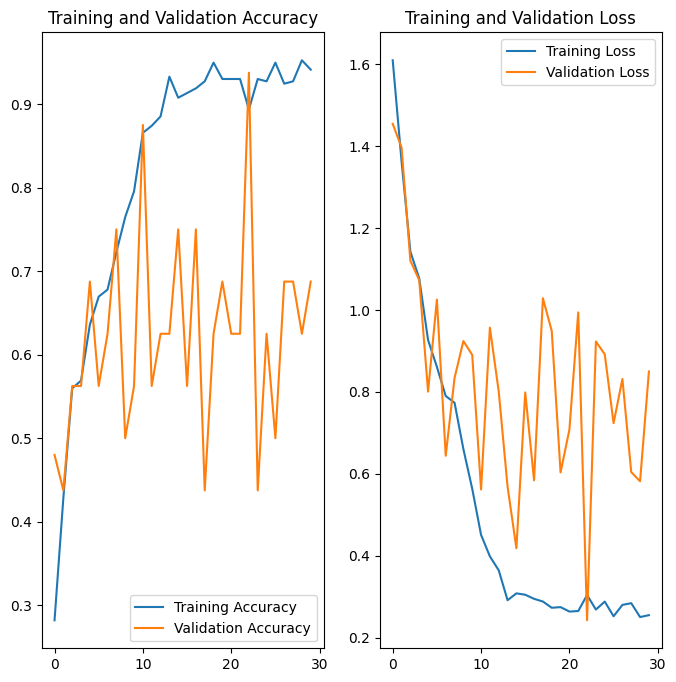

In [ ]:
# Evaluate models
print(model.evaluate_model())
# Plot history
model.plot_history()

In [ ]:
# Store history in the dictionary for future comparision
experiment_histories[model_name] = history
experiment_histories

{'model_experiment_2024-11-0408_54_22.340367/': <keras.src.callbacks.history.History at 0x7b09f40a0d00>}

### Experiment 2 -
- image_height=128, # change - adjusted for VGGNet16
- image_width=128, # change - adjusted for VGGNet16
- num_of_frames=16, # change - adjusted for VGGNet16
- batch_size=32,
- num_epochs=30,
- Optimizer = Adam
- 1 LSTM cell : 256 rnn units # change units from prev experiment
- 1 Dense layer : 128 neurons with usual dropout # change units from prev experiment
- Transfer Learning from VGGNet16
- Global Average Pooling to reduce feature size and training time

In [ ]:
# Initialize the DataPreprocessor
preprocessor = DataPreprocessor(image_height=128, image_width=128, num_of_frames=16, batch_size=32, num_epochs=30)
# Set paths
preprocessor.set_paths(train_path=train_path, val_path=val_path)
# Call display_summary, which will compute and print all values
preprocessor.initializePreprocessData(total_frames=total_frames, generator=generator, train_doc=train_doc, val_doc=val_doc)

=== Data Preprocessing Summary ===
Image Height: 128
Image Width: 128
Frames per Video: 16
Batch Size: 32
Number of Epochs: 30
Training Path: Project_data/train
Validation Path: Project_data/val
Input Shape: (16, 128, 128, 3)
Frame Indices: [ 0  1  3  5  7  9 11 13 15 17 19 21 23 25 27 29]


In [ ]:
# Experiment configuration
experiment_config = {
    "rnn_units": [256],
    "rnn_dropout_rate": [0],
    "dense_units": [128],
    "dropout_rate": [0.50]
}

# Optimizer configuration
optimizer_type = 'Adam'
optimizer_params =None

# RNN type
rnn_type = 'LSTM'

# Retrieve data generators and shapes
train_generator, val_generator = preprocessor.get_data_generators(generator, train_doc, val_doc)

# Model initialization
model = RNNCNN_ImageNet(preprocessor.input_shape, num_of_classes, rnn_type=rnn_type, imagenet_type='VGG16', imagenet_trainable_layers=0, optimizer_type=optimizer_type, optimizer_params=optimizer_params, model_name="model_experiment")

# Running the experiment
history,model_name=model.run_experiment(
   config=experiment_config,
   train_generator=preprocessor.train_generator,
   val_generator=preprocessor.val_generator,
   num_train_sequences=num_train_sequences,
   num_val_sequences=num_val_sequences,
   batch_size=preprocessor.batch_size,
   num_epochs=preprocessor.num_epochs
)


--- Running Experiment ---
Directory model_experiment_2024-11-0409_52_45.725754/ is ready.


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ VGG16_Feature_Extractor              │ (None, 16, 4, 4, 512)       │      14,714,688 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Global_Average_Pooling_Layer         │ (None, 16, 512)             │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ LSTM_1_256_Units (LSTM)              │ (None, 256)                 │         787,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_1_128N (Dense)                 │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1_50_percent (Dropout)       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (Dense)                 │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,535,685 (59.26 MB)

 Trainable params: 820,997 (3.13 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Source path =  Project_data/train ; batch size = 32
Epoch 1/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.2907 - loss: 1.6471Source path =  Project_data/val ; batch size = 32

Epoch 1: saving model to model_experiment_2024-11-0409_52_45.725754//model-01-1.25.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 109s 5s/step - categorical_accuracy: 0.2928 - loss: 1.6427 - val_categorical_accuracy: 0.5500 - val_loss: 1.2530 - learning_rate: 0.0010
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.5394 - loss: 1.1983
Epoch 2: saving model to model_experiment_2024-11-0409_52_45.725754//model-02-0.98.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - categorical_accuracy: 0.5392 - loss: 1.1986 - val_categorical_accuracy: 0.7500 - val_loss: 0.9830 - learning_rate: 0.0010
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.6525 - loss: 1.0358
Epoch 3: saving model to model_experiment_2024-11-0409_52_45.725754//model-03-1.22.keras
21/21 ━━━━━━━━

(0.994397759437561, 0.9375, 0.0912335142493248, 0.3701116740703583)


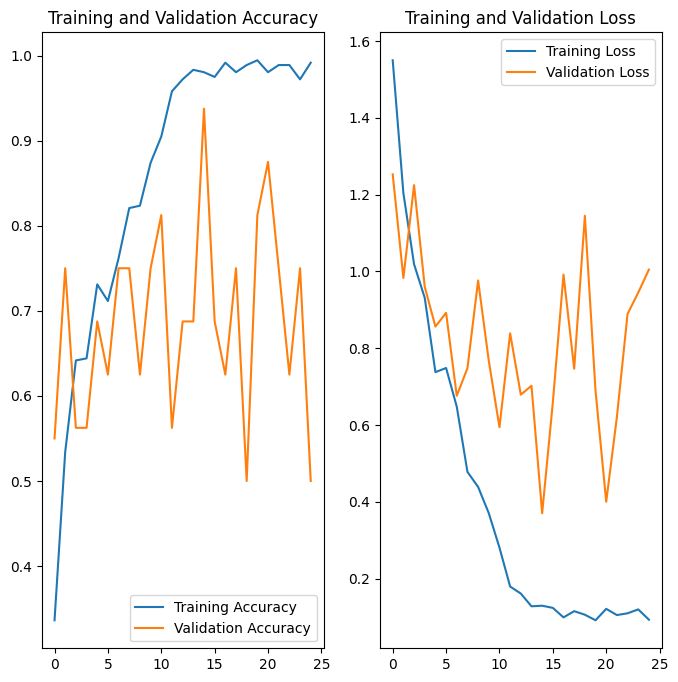

In [ ]:
# Evaluate models
print(model.evaluate_model())
# Plot history
model.plot_history()

In [ ]:
# Store history in the dictionary for future comparision
experiment_histories[model_name] = history
experiment_histories

{'model_experiment_2024-11-0408_54_22.340367/': <keras.src.callbacks.history.History at 0x7b09f40a0d00>,
 'model_experiment_2024-11-0409_52_45.725754/': <keras.src.callbacks.history.History at 0x7b094c1b3f10>}

### Let's increase number of epochs and observe the learning pattern

### Experiment 3 -
- image_height=128, # change - adjusted for VGGNet16
- image_width=128, # change - adjusted for VGGNet16
- num_of_frames=16, # change - adjusted for VGGNet16
- batch_size=32,
- num_epochs=50,
- Optimizer = Adam
- 1 LSTM cell : 256 rnn units # change units from prev experiment
- 1 Dense layer : 128 neurons with usual dropout # change units from prev experiment
- Transfer Learning from VGGNet16
- Global Average Pooling to reduce feature size and training time

In [ ]:
# Initialize the DataPreprocessor
preprocessor = DataPreprocessor(image_height=128, image_width=128, num_of_frames=16, batch_size=32, num_epochs=50)
# Set paths
preprocessor.set_paths(train_path=train_path, val_path=val_path)
# Call display_summary, which will compute and print all values
preprocessor.initializePreprocessData(total_frames=total_frames, generator=generator, train_doc=train_doc, val_doc=val_doc)

=== Data Preprocessing Summary ===
Image Height: 128
Image Width: 128
Frames per Video: 16
Batch Size: 32
Number of Epochs: 50
Training Path: Project_data/train
Validation Path: Project_data/val
Input Shape: (16, 128, 128, 3)
Frame Indices: [ 0  1  3  5  7  9 11 13 15 17 19 21 23 25 27 29]


In [ ]:
# Experiment configuration
experiment_config = {
    "rnn_units": [256],
    "rnn_dropout_rate": [0],
    "dense_units": [128],
    "dropout_rate": [0.50]
}

# Optimizer configuration
optimizer_type = 'Adam'
optimizer_params =None

# RNN type
rnn_type = 'LSTM'

# Retrieve data generators and shapes
train_generator, val_generator = preprocessor.get_data_generators(generator, train_doc, val_doc)

# Model initialization
model = RNNCNN_ImageNet(preprocessor.input_shape, num_of_classes, rnn_type=rnn_type, imagenet_type='VGG16', imagenet_trainable_layers=0, optimizer_type=optimizer_type, optimizer_params=optimizer_params, model_name="model_experiment")

# Running the experiment
history,model_name=model.run_experiment(
   config=experiment_config,
   train_generator=preprocessor.train_generator,
   val_generator=preprocessor.val_generator,
   num_train_sequences=num_train_sequences,
   num_val_sequences=num_val_sequences,
   batch_size=preprocessor.batch_size,
   num_epochs=preprocessor.num_epochs
)


--- Running Experiment ---
Directory model_experiment_2024-11-0409_21_05.315911/ is ready.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ VGG16_Feature_Extractor              │ (None, 16, 4, 4, 512)       │      14,714,688 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Global_Average_Pooling_Layer         │ (None, 16, 512)             │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ LSTM_1_256_Units (LSTM)              │ (None, 256)                 │         787,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_1_128N (Dense)                 │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1_50_percent (Dropout)       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (Dense)                 │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,535,685 (59.26 MB)

 Trainable params: 820,997 (3.13 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Source path =  Project_data/train ; batch size = 32
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.3146 - loss: 1.6133Source path =  Project_data/val ; batch size = 32

Epoch 1: saving model to model_experiment_2024-11-0409_21_05.315911//model-01-1.26.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 110s 5s/step - categorical_accuracy: 0.3166 - loss: 1.6083 - val_categorical_accuracy: 0.5600 - val_loss: 1.2615 - learning_rate: 0.0010
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.5229 - loss: 1.1795
Epoch 2: saving model to model_experiment_2024-11-0409_21_05.315911//model-02-0.93.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - categorical_accuracy: 0.5240 - loss: 1.1776 - val_categorical_accuracy: 0.6250 - val_loss: 0.9340 - learning_rate: 0.0010
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.5564 - loss: 1.0659
Epoch 3: saving model to model_experiment_2024-11-0409_21_05.315911//model-03-1.04.keras
21/21 ━━━━━━━━

(0.9775910377502441, 0.9375, 0.13634298741817474, 0.18511459231376648)


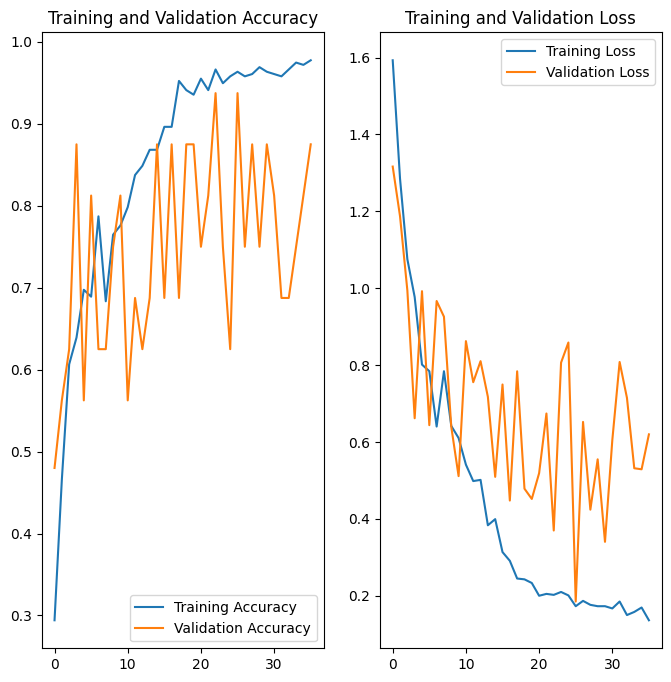

In [ ]:
# Evaluate models
print(model.evaluate_model())
# Plot history
model.plot_history()

In [ ]:
# Store history in the dictionary for future comparision
experiment_histories[model_name] = history
experiment_histories

{'model_experiment_2024-11-0314_42_05.013830/': <keras.src.callbacks.history.History at 0x7ac1840ec280>,
 'model_experiment_2024-11-0315_18_51.882888/': <keras.src.callbacks.history.History at 0x7ac1a36cb820>}

### This is also not helping much. Let's try to build model using transfer learning from MobileNetV2

### Experiment 5 -
- image_height=96, # change - adjusted for MobileNetV2
- image_width=96, # change - adjusted for MobileNetV2
- num_of_frames=16, change - adjusted for MobileNetV2
- batch_size=32,
- num_epochs=30,
- Optimizer = Adam
- 1 LSTM cell : 256 rnn units # change units from prev experiment
- 1 Dense layer : 128 neurons with usual dropout # change units from prev experiment
- Transfer Learning from MobileNetV2
- Global Average Pooling to reduce feature size and training time

In [ ]:
# Initialize the DataPreprocessor
preprocessor = DataPreprocessor(image_height=96, image_width=96, num_of_frames=16, batch_size=32, num_epochs=30)
# Set paths
preprocessor.set_paths(train_path=train_path, val_path=val_path)
# Call display_summary, which will compute and print all values
preprocessor.initializePreprocessData(total_frames=total_frames, generator=generator, train_doc=train_doc, val_doc=val_doc)

=== Data Preprocessing Summary ===
Image Height: 96
Image Width: 96
Frames per Video: 16
Batch Size: 32
Number of Epochs: 30
Training Path: Project_data/train
Validation Path: Project_data/val
Input Shape: (16, 96, 96, 3)
Frame Indices: [ 0  1  3  5  7  9 11 13 15 17 19 21 23 25 27 29]


In [ ]:
# Experiment configuration
experiment_config = {
    "rnn_units": [256],
    "rnn_dropout_rate": [0],
    "dense_units": [128],
    "dropout_rate": [0.50]
}

# Optimizer configuration
optimizer_type = 'Adam'
optimizer_params = None

# RNN type
rnn_type = 'LSTM'

# Retrieve data generators and shapes
train_generator, val_generator = preprocessor.get_data_generators(generator, train_doc, val_doc)

# Model initialization
model = RNNCNN_ImageNet(preprocessor.input_shape, num_of_classes, rnn_type=rnn_type, imagenet_type='MobileNetV2', imagenet_trainable_layers=0, optimizer_type=optimizer_type, optimizer_params=optimizer_params, model_name="model_experiment")
#model.display_summary(config=experiment_config)
# Running the experiment
history,model_name=model.run_experiment(
   config=experiment_config,
   train_generator=preprocessor.train_generator,
   val_generator=preprocessor.val_generator,
   num_train_sequences=num_train_sequences,
   num_val_sequences=num_val_sequences,
   batch_size=preprocessor.batch_size,
   num_epochs=preprocessor.num_epochs
)


--- Running Experiment ---
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Directory model_experiment_2024-11-0410_23_38.234339/ is ready.


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ MobileNetV2_Feature_Extractor        │ (None, 16, 3, 3, 1280)      │       2,257,984 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Global_Average_Pooling_Layer         │ (None, 16, 1280)            │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ LSTM_1_256_Units (LSTM)              │ (None, 256)                 │       1,573,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_1_128N (Dense)                 │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1_50_percent (Dropout)       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (Dense)                 │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,865,413 (14.75 MB)

 Trainable params: 1,607,429 (6.13 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

None
Source path =  Project_data/train ; batch size = 32
Epoch 1/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.2226 - loss: 1.7331Source path =  Project_data/val ; batch size = 32

Epoch 1: saving model to model_experiment_2024-11-0410_23_38.234339//model-01-1.56.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 156s 5s/step - categorical_accuracy: 0.2236 - loss: 1.7302 - val_categorical_accuracy: 0.1900 - val_loss: 1.5630 - learning_rate: 0.0010
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.2605 - loss: 1.5810
Epoch 2: saving model to model_experiment_2024-11-0410_23_38.234339//model-02-1.58.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - categorical_accuracy: 0.2613 - loss: 1.5805 - val_categorical_accuracy: 0.2500 - val_loss: 1.5769 - learning_rate: 0.0010
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.2957 - loss: 1.5484
Epoch 3: saving model to model_experiment_2024-11-0410_23_38.234339//model-03-1.43.keras
21/21 ━━━━━━━━

(0.5742297172546387, 0.5625, 1.1114002466201782, 1.1489222049713135)


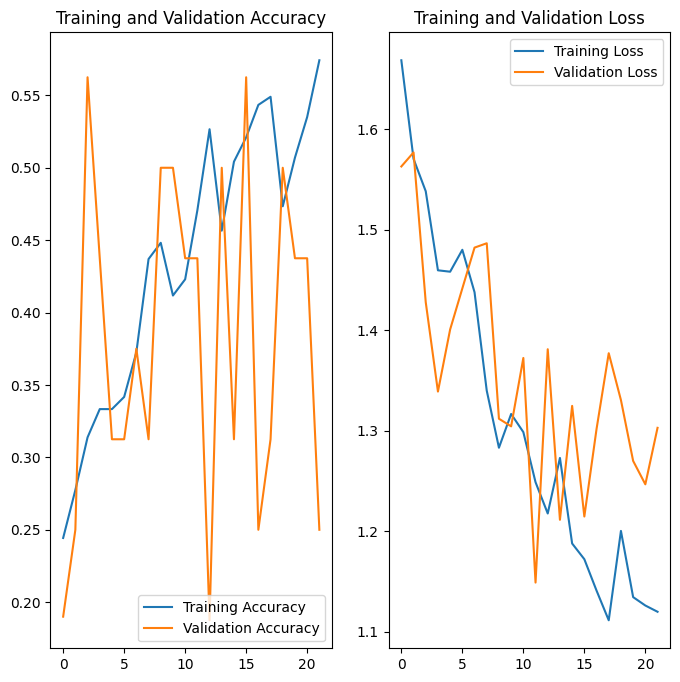

In [ ]:
# Evaluate models
print(model.evaluate_model())
# Plot history
model.plot_history()

In [ ]:
# Store history in the dictionary for future comparision
experiment_histories[model_name] = history
experiment_histories

{'model_experiment_2024-11-0408_54_22.340367/': <keras.src.callbacks.history.History at 0x7b09f40a0d00>,
 'model_experiment_2024-11-0409_52_45.725754/': <keras.src.callbacks.history.History at 0x7b094c1b3f10>,
 'model_experiment_2024-11-0410_23_38.234339/': <keras.src.callbacks.history.History at 0x7b0921f0d6f0>}

### Experiment 6 -
- image_height=96, # change - adjusted for MobileNetV2
- image_width=96, # change - adjusted for MobileNetV2
- num_of_frames=16, change - adjusted for MobileNetV2
- batch_size=32,
- num_epochs=30,
- Optimizer = Adam
- 1 LSTM cells : 256 rnn units
- 1 Dense layers : 128 neurons with usual dropout
- Transfer Learning from MobileNetV2
- Trainable layers of MobileNetV2 - all weights after initial 100 layers # change - from previous experiment
- Global Average Pooling to reduce feature size and training time

In [ ]:
# Initialize the DataPreprocessor
preprocessor = DataPreprocessor(image_height=96, image_width=96, num_of_frames=16, batch_size=32, num_epochs=30)
# Set paths
preprocessor.set_paths(train_path=train_path, val_path=val_path)
# Call display_summary, which will compute and print all values
preprocessor.initializePreprocessData(total_frames=total_frames, generator=generator, train_doc=train_doc, val_doc=val_doc)

=== Data Preprocessing Summary ===
Image Height: 96
Image Width: 96
Frames per Video: 16
Batch Size: 32
Number of Epochs: 30
Training Path: Project_data/train
Validation Path: Project_data/val
Input Shape: (16, 96, 96, 3)
Frame Indices: [ 0  1  3  5  7  9 11 13 15 17 19 21 23 25 27 29]


In [ ]:
# Experiment configuration
experiment_config = {
    "rnn_units": [256],
    "rnn_dropout_rate": [0],
    "dense_units": [128],
    "dropout_rate": [0.50]
}

# Optimizer configuration
optimizer_type = 'Adam'
optimizer_params = None

# RNN type
rnn_type = 'LSTM'

# Retrieve data generators and shapes
train_generator, val_generator = preprocessor.get_data_generators(generator, train_doc, val_doc)

# Model initialization
model = RNNCNN_ImageNet(preprocessor.input_shape, num_of_classes, rnn_type=rnn_type, imagenet_type='MobileNetV2', imagenet_trainable_layers=100, optimizer_type=optimizer_type, optimizer_params=optimizer_params, model_name="model_experiment")

# Running the experiment
history,model_name=model.run_experiment(
   config=experiment_config,
   train_generator=preprocessor.train_generator,
   val_generator=preprocessor.val_generator,
   num_train_sequences=num_train_sequences,
   num_val_sequences=num_val_sequences,
   batch_size=preprocessor.batch_size,
   num_epochs=preprocessor.num_epochs
)


--- Running Experiment ---
Directory model_experiment_2024-11-0411_37_40.740582/ is ready.


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ MobileNetV2_Feature_Extractor        │ (None, 16, 3, 3, 1280)      │       2,257,984 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Global_Average_Pooling_Layer         │ (None, 16, 1280)            │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ LSTM_1_256_Units (LSTM)              │ (None, 256)                 │       1,573,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_1_128N (Dense)                 │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1_50_percent (Dropout)       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (Dense)                 │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,865,413 (14.75 MB)

 Trainable params: 3,468,869 (13.23 MB)

 Non-trainable params: 396,544 (1.51 MB)

None
Source path =  Project_data/train ; batch size = 32
Epoch 1/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.2552 - loss: 1.6280Source path =  Project_data/val ; batch size = 32

Epoch 1: saving model to model_experiment_2024-11-0411_37_40.740582//model-01-1.74.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 205s 5s/step - categorical_accuracy: 0.2580 - loss: 1.6235 - val_categorical_accuracy: 0.1900 - val_loss: 1.7377 - learning_rate: 0.0010
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.5461 - loss: 1.1426
Epoch 2: saving model to model_experiment_2024-11-0411_37_40.740582//model-02-1.84.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - categorical_accuracy: 0.5469 - loss: 1.1419 - val_categorical_accuracy: 0.3750 - val_loss: 1.8405 - learning_rate: 0.0010
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.6745 - loss: 0.9288
Epoch 3: saving model to model_experiment_2024-11-0411_37_40.740582//model-03-1.86.keras
21/21 ━━━━━━━━

(0.9831932783126831, 0.9375, 0.09612209349870682, 0.1799052208662033)


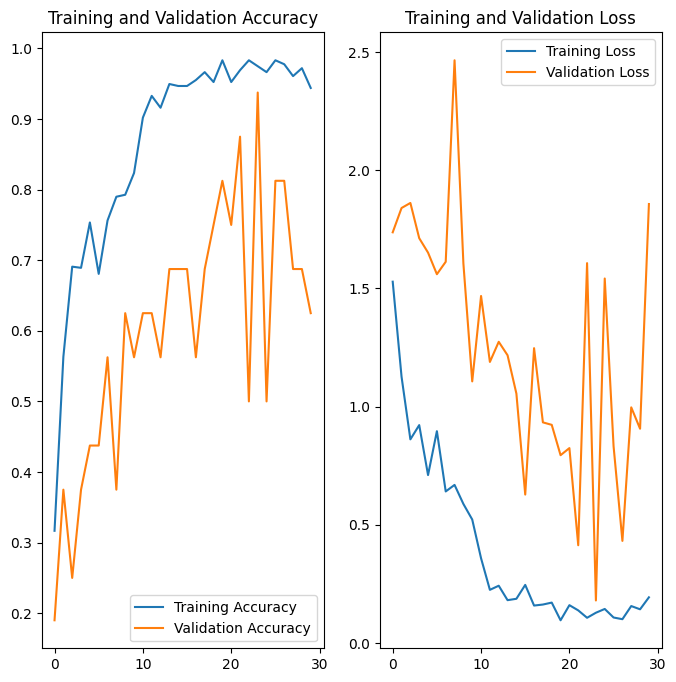

In [ ]:
# Evaluate models
print(model.evaluate_model())
# Plot history
model.plot_history()

In [ ]:
# Store history in the dictionary for future comparision
experiment_histories[model_name] = history
experiment_histories

{'model_experiment_2024-11-0408_54_22.340367/': <keras.src.callbacks.history.History at 0x7b09f40a0d00>,
 'model_experiment_2024-11-0409_52_45.725754/': <keras.src.callbacks.history.History at 0x7b094c1b3f10>,
 'model_experiment_2024-11-0410_23_38.234339/': <keras.src.callbacks.history.History at 0x7b0921f0d6f0>,
 'model_experiment_2024-11-0411_37_40.740582/': <keras.src.callbacks.history.History at 0x7b06071b7580>}

## Identify and Categorize Top Results

### Findings 1: Maximum accuracy and minimum loss across epochs -
- Approach 3 - Experiment 6 -
  - image_height=96,
  - image_width=96,
  - num_of_frames=16,
  - batch_size=32,
  - num_epochs=30,
  - Optimizer = Adam
  - 1 LSTM cells : 256 rnn units
  - 1 Dense layers : 128 neurons with usual dropout
  - Transfer Learning from MobileNetV2
  - Trainable layers of MobileNetV2 - all weights after   initial 100 layers
  - Global Average Pooling to reduce feature size and training time

### Findings 2 : Moderate number of parameters and average computational cost and training time with descent accuracy and loss in few epochs -
1. Approach 3 - Experiment 6 -
  - image_height=128,
  - image_width=128,
  - num_of_frames=16,
  - batch_size=32,
  - num_epochs=30,
  - Optimizer = Adam
  - 1 LSTM cell : 256 rnn units,
  - 1 Dense layer : 128 neurons with usual dropout,
  - Transfer Learning from VGGNet16
  - Global Average Pooling to reduce feature size and training time

2. Approach 2 - Experiment 4 -
  - image_height=100,
  - image_width=100,
  - num_of_frames=20,
  - batch_size=32,
  - num_epochs=30,
  - Optimizer = Adam
  - 4 Conv2D , MaxPooling layers
  - 1 LSTM cell : 128 rnn units
  - 1 Dense layer with usual dropout

3. Approach 2 - Experiment 5 -
  - image_height=100,
  - image_width=100,
  - num_of_frames=20,
  - batch_size=32,
  - num_epochs=30,
  - Optimizer = Adam
  - 4 Conv2D , MaxPooling layers
  - 1 GRU cell : 128 rnn units
  - 1 Dense layer with usual dropout

4.  Approach 1 - Experiment 10 -
  - image_height=100,
  - image_width=100,
  - num_of_frames=20,
  - batch_size=32,
  - num_epochs=50 ,
  - More CNN Layers , and alternate MaxPoolLayers in  Conv layers # change - major change in CNN architecture
  - Optimizer = "Adam"
  - More Dense Layers

## Final Model Recommendation and Conclusion

Based on the experiments, Approach 3 - Experiment 6 (MobileNetV2 with transfer learning) appears to be the optimal choice for the final model. It offers a well-balanced trade-off between accuracy, loss, and computational efficiency:

  - High Accuracy and Low Loss: This approach achieved the best results, with a maximum training accuracy of 0.9831, maximum validation accuracy of 0.9375, minimum training loss of 0.0961, and minimum validation loss of 0.1799.
  - Moderate Parameters: By freezing the initial 100 layers of MobileNetV2, the model maintains a manageable parameter count while effectively leveraging transfer learning.
  - Efficient Training Time: Global Average Pooling reduces the feature size, resulting in faster training without sacrificing performance.
Future Work and Improvements: Further experimentation could involve adjusting frame dimensions or exploring more efficient CNN backbones. Testing the model on larger datasets or in real-time scenarios could also enhance robustness and practical applicability.

## Optional - For Google Colab - Consolidate and Download .keras files
Remove "### " from all lines and enable this block when running the notebook in Google Colab

In [ ]:
### import glob
### import zipfile
### from google.colab import drive
###
### # Mount Google Drive
### drive.mount('/content/drive')
###
### # Define the path where you want to save the zip file in your Google Drive
### curr_dt_time = datetime.datetime.now()
### drive_zip_path = f'/content/drive/My Drive/Gesture_Recognition_Project_{curr_dt_time}.zip'
###
### # Define a destination folder to consolidate all experiment folders
### consolidated_folder = '/content/Gesture_Recognition_Project'
###
### # Step 1: Check if the Project_data folder exists
### if os.path.exists(consolidated_folder):
###     # If it exists, delete the folder and its contents
###     shutil.rmtree(consolidated_folder)
###     print(f"{consolidated_folder} folder has been deleted.")
### else:
###     print(f"{consolidated_folder}  folder does not exist.")
###
### # Create the consolidated folder
### os.makedirs(consolidated_folder, exist_ok=True)
###
### # Find all folders starting with 'model_experiment' and copy them to the consolidated folder
### experiment_folders = glob.glob('/content/model_experiment_2024-11-0221_00_23.560868')
### for folder in experiment_folders:
###     # Copy each folder to the consolidated destination
###     shutil.copytree(folder, os.path.join(consolidated_folder, os.path.basename(folder)))
###
### # Create a ZIP file
### with zipfile.ZipFile(drive_zip_path, 'w') as zipf:
###     # Walk the directory and add files to the zip file
###     for root, dirs, files in os.walk(consolidated_folder):
###         for file in files:
###             file_path = os.path.join(root, file)
###             # Add file to the zip file, maintaining the folder structure
###             zipf.write(file_path, os.path.relpath(file_path, consolidated_folder))
###
### print(f"ZIP file has been saved to: {drive_zip_path}")
###
### # Cleanup: remove the consolidated folder after zipping
### shutil.rmtree(consolidated_folder)

Mounted at /content/drive
/content/Gesture_Recognition_Project  folder does not exist.
ZIP file has been saved to: /content/drive/My Drive/Gesture_Recognition_Project_2024-11-04 12:02:17.702168.zip
